## 1. Introduction

### 1.1 Goals to achieve

This project will show how it is possible to accurately classify audio sounds with deep learning. We will focus on an audio dataset (more details will be explained in the following sections). Firstly, we will consider supervised learning models in order to solve the classification problem using a CNN model and a feed-forward neural network model to compare the results. Then, we will consider (gaussian) noise injection and the related responses in terms of psychometric curves by the two supervised models. After that, we are going to generate adversarial samples with the FGSM and evaluate the models' performances on the basis of an increasing factor, considering also in this case psychometric curves. Finally, we will explore an unsupervised learning model for the denoising of audio samples and audio generation: Convolutional Variational Autoencoder (CVAE). In the following sections, we will deepen all those aspects.

### 1.2 UrbanSound8K dataset

The [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset will be used for this project. This dataset contains 8732 labeled sound excerpts (`.wav` files) ($\le4 \: s$) of urban sounds from 10 classes: `air_conditioner`, `car_horn`, `children_playing`, `dog_bark`, `drilling`, `enginge_idling`, `gun_shot`, `jackhammer`, `siren` and `street_music`. The classes are drawn from the [urban sound taxonomy](https://urbansounddataset.weebly.com/taxonomy.html).

To explore the dataset, a very useful file is `UrbanSound8k.csv`.
The latter contains meta-data information about every audio file in the dataset. In the following, We are going to report only the information which are useful for our scope.

* `slice_file_name`: the name of the audio file.
  It takes the following format: `[fsID]-[classID]-[occurrenceID]-[sliceID].wav`, where:
    * `[fsID]`: the freesound ID of the recording from which this excerp (slice) is taken;
    * `[classID]`: a numeric identifier of the sound class (see description of classID below for further details);
    * `[occurrenceID]`: a numeric identifier to distinguish different occurrences of the sound within the original recording;
    * `[sliceID]`: a numeric identifier to distinguish different slices taken from the same occurrence.

* `classID`:
a numeric identifier of the sound class.
  * 0 = `air_conditioner`;
  * 1 = `car_horn`;
  * 2 = `children_playing`;
  * 3 = `dog_bark`;
  * 4 = `drilling`;
  * 5 = `engine_idling`;
  * 6 = `gun_shot`;
  * 7 = `jackhammer`;
  * 8 = `siren`;
  * 9 = `street_music`.

* `class`: the class name.

### 1.3 Importing all the necessary modules and hardware

There are 5 main modules that will be used for this particular project.  

1. **os**: this is a python built-in module that allows to access the local or cloud file systems;
2. **librosa**: python package typically used for music and audio analysis. We are also going to be using it for feature extraction;
3. **numpy**: scientific computing that will be used to process the raw audio files for deep learning;
4. **tensorflow**: deep learning framework that is going to be used to build and train our models;
5. **matplotlib**: useful for visualization during EDA and all the other following sections.



In [ ]:
import os # We are going to need os to import the .wav files into the notebook to be processed.
import numpy as np # This will be used to put the wave features of each .wav file into datasets.
import seaborn as sn # This will be used for the confusion matrix.
import pandas as pd # This will be used for visualizing data frame and confusion matrix.
import librosa # This is the audio file processing library.
import IPython.display as ipd # This is used to reproduce sounds and to display the dataframe.
import librosa.display # This will be used to display MFCCs.
import random # This is used for shuffling the datasets once they are created.
import matplotlib.pyplot as plt # This is used during all the project to plot quantities of interest.
import tensorflow as tf # Deep learning framework used to develop the models.
import warnings # This is used to filter UserWarnings.
%matplotlib inline

In order to define models with `tensorflow.keras` framework, we need to import some useful modules.

In [ ]:
from keras import backend as K # This is used for the definition of the CVAE.
from keras.callbacks import ReduceLROnPlateau, EarlyStopping # This are callbacks which we are going to use in training process.
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Conv1DTranspose, UpSampling1D # Layers for defining our models (1).
from keras.layers import Reshape, Dropout, Activation, Flatten, Lambda # Layers for defining our models (2).
from keras.losses import categorical_crossentropy, mse # Losses for models evaluation performances.
from keras.models import Sequential, Model # Definition of the type of model we are going to use to define a particular predictor.
from keras.utils import plot_model # This is used to plot a model as a sequence of blocks.
from keras.utils import to_categorical # This is used to one-hot encode labels.
from keras.optimizers import Adam # This is used for optimization in training process.
from keras.metrics import CategoricalAccuracy # This is used as a metric for evaluating models perfomances.
from keras.regularizers import l2 # L2 regularization to reduce overfitting.

The following modules are used for the unsupervised learning part.

In [ ]:
from sklearn.metrics import silhouette_score # Score to evaluate the clustering.
from sklearn.manifold import TSNE # This is used to reduce the dimentionality of latent representations, in order to be 'visualizable'.

Let's install and import [keract](https://pypi.org/project/keract/), which is an helpful module for feature representations.

In [ ]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keract import get_activations, display_activations

For this project, we want to use a GPU. This will help to drastically speed up training of the model. In order to change runtime type, we could follow those steps: *Runtime $→$ Change runtime type $→$ Change to GPU runtime*. 

In [ ]:
# This block of code is to check if the GPU instance is running on this notebook session.
# We want to use a GPU to speed up data processing and CNN training time.

# We want to see if the Google Colab GPU is available for use in this notebook session.
# If it is available, the return on the notebook should say:
# Found GPU at: /device:GPU:0

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 1.4 Mounting the Google Drive to access the audio dataset

For this project, the `UrbanSound8K` dataset will be used. Due to limitations in unzipping the file directly on the Google Drive, it is necessary to unzip the file locally and then upload it to the Google Drive. In this scenario, a shortcut was created for the data folder.

In [ ]:
# This script would mount the drive onto the Colab Notebook.
# If there is a drive mounted, the notebook would return:
# "Mounted at /content/drive" or 
# "Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True)."

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.5 Visualizing Urban8K dataset

Let's define the paths to the audio dataset and to the `.csv` file.

In [ ]:
# Path to audio dataset.
AUDIO_DATASET = "/content/drive/MyDrive/UrbanSound8K/audio/"

# Path to CSV file.
AUDIO_DATASET_CSV = "/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv"

Now, we are going to use `pandas` library to visualize the `.csv` file and all its entries.

In [ ]:
data_frame = pd.read_csv(AUDIO_DATASET_CSV)
ipd.display(data_frame)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
classes = data_frame['class'].unique()
print("Classes: \n"+str(classes))
print("Number of classes: "+str(classes.shape[0]))

Classes: 
['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
Number of classes: 10


As we can see from the output above, we have a classification problem to solve related to the association of each `.wav` file to a label between the 10 labels listed above.

### 1.6 Librosa

In order to process the dataset, [Librosa](https://librosa.org/) library will be used for this project. Librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa.load()` method loads an audio file as a floating point time series. Audio will be automatically resampled to the given rate (default sr=22050).

* $x$ $\rightarrow$ sound time series;

* $sr$ $\rightarrow$ sound frequency (Hz).

We will use the following `.wav` input to analysis.

In [ ]:
# Load a sample with librosa.load(): children playing.
sample = AUDIO_DATASET + "/100263-2-0-126.wav"
x, frequency = librosa.load(sample)
sample_rate = frequency

Let's print some characteristics of the above sample.

In [ ]:
print("Shape of the signal: "+str(x.shape))
print("Frequency of the signal: "+str(frequency))

Shape of the signal: (88200,)
Frequency of the signal: 22050


Sound can be played with `ipd` library as follows.

In [ ]:
# Use the IPython display function to display the audio sample.
# The audio will be played using the rate 22050.
ipd.Audio(sample)

### 1.7 Mel-Frequency Cepstral Coefficients (MFCCs)

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency. [Mel-Frequency Cepstral Coefficients](https://www.analyticsvidhya.com/blog/2021/06/mfcc-technique-for-speech-recognition/) (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a non-linear "spectrum-of-a-spectrum"). The Mel Frequency Cepstral Coefficients are commonly used in order to extract essential information from a voice signal and became a popular feature extractor used in audio processing. To extract these coefficients, we will use `librosa.feature.mfcc` as specified in Tensorflow [documentation](https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html).

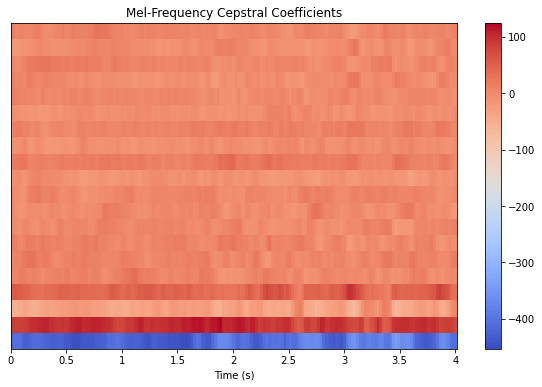

In [ ]:
# Derive MFCCs with librosa.feature.mfcc().
mfcc = librosa.feature.mfcc(x, sr=sample_rate)

# Plot the MFCCs of the signal.
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis="s")
plt.title("Mel-Frequency Cepstral Coefficients")
plt.colorbar()

### 1.8 Assumptions

* The audio data loaded are sufficently clean and distinct between labels and the feature extraction method used is sufficient for wave pattern distinction;
* Librosa is the fastest audio file loader and feature extractor for this project. The labels need to be one-hot encoded;
* It is appropriate to represent the audio files in a spatial/spectral context given their nature to be train in the models;
* The GPU for Colab can be used for this project.

**Note**: we are going to inject noise and create adversial samples later on in this project.

## 2. Exploratory Data Analysis (EDA)

For EDA, we want to find out the labels distribution in the dataset. In fact, it is important that our dataset is reasonably balanced and that no labels are over or underrepresented.



In [ ]:
# We want to make a histogram to look at the distribution of data among the label IDs.
labels = []

In [ ]:
# We want to extract all the relative paths for the audio files into a list once.
AUDIO_FILES = os.listdir(AUDIO_DATASET)
AUDIO_DATA = [audio for audio in AUDIO_FILES if audio != '.DS_Store']

We want to define an helper function to extract label IDs from the audio string.

In [ ]:
def extract_id_label(sound):
    '''
    This helper function extracts the id label from the sound string.

    Input: the sound string in the format "X-X-X-X.wav".
    
    Output: the id label as an integer.
    '''
    # Split the sound string into a list of substrings based on the "-" character.
    sound_list = sound.split("-")
    # Extract the second label from the list.
    id_label = sound_list[1]
    return int(id_label)

Then, we load the array for the history in order to plot an histogram of the labels distribution.

In [ ]:
# Loading the array for the history.
for sound in AUDIO_DATA:  
    labels.append(extract_id_label(sound))

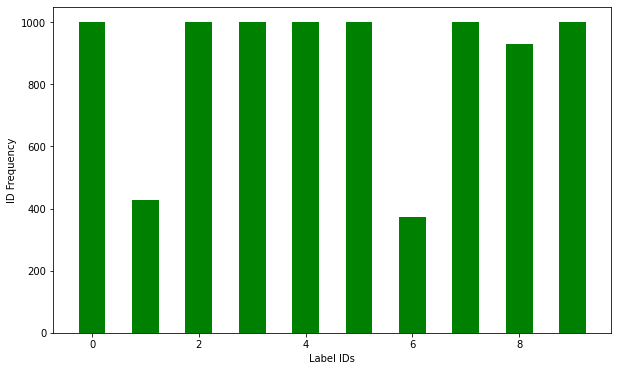

In [ ]:
# Plot the histogram.
bins = np.arange(11) - 0.5
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=bins, color='green', rwidth=0.5)
plt.xlabel('Label IDs')
plt.ylabel('ID Frequency')
plt.show()

Based on the information shown in the histogram, the data is generally well balanced across all label IDs. The number of samples for labels 0, 2, 3, 4, 5, 7, 8 and 9 are around the same. However, labels 1 and 6 are underrepresented with respect to the other labels by a ratio of 2-to-1. From this, we can expect the models to underperform relative to the other classes during validation and testing. Since there is no easy way to oversample these underrepresented classes, and undersampling will eliminate most of the dataset, we will accept these shortcomings and use the dataset the way it came.

## 3. Training, validation and test dataset split

After we have done the EDA, we will now process the audio in the `.wav` files and manipulate the data to prepare it for deep learning. Typically, the training-validation-test split would be 80-10-10 in terms of percentages. To get this data split proportion, we extract every $9^{th}$ `.wav` file for the validation set and every $10^{th}$ `.wav` file for the test set within every class label. This would ensure that the distribution of the labels remain consistent throughout training, validation, and test datasets.

In [ ]:
# We want to seperate the .wav files based on label id.
label_ids = {
     0: [],
     1: [],
     2: [],
     3: [],
     4: [], 
     5: [],
     6: [],
     7: [],
     8: [],
     9: []
}

In [ ]:
def populate_id_dict():
    # This script would return a dictionary that would store the .wav file path based on their label id.
    for sound in AUDIO_DATA:  
        sound_path = os.path.join(AUDIO_DATASET, sound)
        label = extract_id_label(sound)
        label_ids[label].append(sound_path)

In [ ]:
populate_id_dict()

As we said before, we want to split the dataset into a 80-10-10 training-validation-test split.

In [ ]:
# We want to store the file paths of the individual audio file paths for each of the 3 sub datasets.
train_set_files = [] # This is for storing paths of the training set.
valid_set_files = [] # This is for storing paths of the validation set.
test_set_files = [] # This is for storing paths of the test set.

# We want to extract every 9th file for the validation set and every 10th for the test set
# for each label id class.
# This should distribute the data by it's class labels proportionally across all datasets.
for label, files in label_ids.items():
    for i, sound in enumerate(files):   
        if (i+1) % 10 == 9:
            valid_set_files.append(sound)
        elif (i+1) % 10 == 0:
            test_set_files.append(sound)
        else:
            train_set_files.append(sound)

In [ ]:
# We want to shuffle the data paths for each dataset.
# This would allow faster convergence during model training.

# Set random seed as student ID.
random.seed(2082157)

random.shuffle(train_set_files)
random.shuffle(valid_set_files)
random.shuffle(test_set_files)

## 4. Data manipulation

The purpose of the data manipulation is to prepare it for deep learning.
In this case, the Librosa library does a lot of the work extracting the amplitudes from the `.wav` files. We still need to set a number of features for the library to extract to be used for the model. We decided to keep the final dataset simple and make it a 2D array. Each row would represent single `.wav` file. This would also allow us to do batch SGD during training.

Essentially, the main idea is to transform each `.wav` file into a vector of features (MFCCs) with the following shape: (1, `FEATURE_LENGTH`). This was done for computational purposes in order to process the audio data faster into the models we are going to define.

In [ ]:
# In accordance to standard approach, we are going to limit the number of feature measurements to 100.
FEATURE_LENGTH = 100

Now, we are going to set a function to extract the features of each audio file.

In [ ]:
def feature_extraction(sound_path):
    '''
    This helper function extracts the audio amplitudes and features from the .wav 
    file using Librosa. 'None' is passed in as the target_sample_rate since it 
    allows for fast loading and provides automatic normalization of the amplitudes. 
    One key detail that should be noted is that Librosa doesn't return arrays at a
    consistent length. This issue will be addressed later on. 

    The featurs that we are extracting here are the audio's Mel-Frequency Cepstral 
    Coefficients (MFCCS). These are a spectral representation of an audio clip that
    can be analyzed like an image.

    Inputs: the relative path of the .wav file in string type, and the sampling rate.
    Output: the audio file's MFCCS features in a numpy array form.
    '''
    # Audio extraction.
    audio, sample_rate = librosa.load(sound_path, sr=None) 
    # Feature extraction.
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=FEATURE_LENGTH)
    # Averaging among the individual feature coefficient columns.
    mfccs_avg = np.mean(mfccs, axis=1).reshape(-1, FEATURE_LENGTH)
    return mfccs_avg

Then, we will define an helper function in order to create the 2D array datasets.

In [ ]:
def stack_and_concat_data(temp, audio_stack):
    '''
    This is a helper function that is used for the development of the 2D array datasets.
    It stacks the list of feature arrays into a 2D array that can be used for 
    deep learning.

    Inputs: temporary array for holding feature arrays and the final audio stack.
    Output: the final concatenated audio stack used for DL.
    '''
    array_stack = np.stack(temp, axis=0).reshape(-1, FEATURE_LENGTH)
    audio_stack = np.concatenate([audio_stack, array_stack], axis=0)
    return audio_stack

In the following, we will designate a function to extract the audio from the `.wav` files and manipulate them into a format that can be used for deep learning. This function has several key components: label id extraction, amplitude and feature extraction, and concatenation. We want to batch concatenate in feature array batches of 1000 at a time. This is done mainly for computation speed. The speed of the numpy concatenation method doesn't differ that much between a few and 1000 dataframes, and it's much faster to do them in bulk than one at a time.

In [ ]:
def concatenate_audio(audio_files):
    '''
    This function is meant to extract the audio from the .wav files and manipulate 
    them into a format that can be used for deep learning. This function has several
    key components: label id extraction, amplitude and feature extraction, and 
    concatenation.

    Input: relative paths for each of audio file datasets.
    Output: the DL datasets and their labels.
    '''
    audio_stack = np.array([])
    audio_list = []
    audio_label = []

    # Using the GPU:
    with tf.device('/device:GPU:0'):
        # We have to iterate through all the .wav file paths to be processed.
        for audio_file in audio_files:
            # Gets the label ids of each .wav file.
            label_id = extract_id_label(audio_file)
            audio_label.append(label_id)
            # Extracts the audio features from the .wav file.
            processed_audio = feature_extraction(audio_file)
            # We use this temporary list for storing every 1000 feature
            # arrays for speed.
            audio_list.append(processed_audio)
            # We want to be able to initialize the final audio array stack dataset
            # like this due to the nature of numpy concatenate.
            if len(audio_stack) == 0:
                print("Initializing the data stack...")
                audio_stack = processed_audio
                # We reset the temporary list of audio arrays.
                audio_list = []
            # Every 1000 arrays in the temporary list, we would concatenate it
            # to the main data stack and reset the temporary list.
            elif len(audio_list) == 1000:
                print("Adding to data stack...")
                audio_stack = stack_and_concat_data(audio_list, audio_stack)
                # We reset the temporary list of audio arrays.
                audio_list = []
        # If the temporary list doesn't have 1000 arrays, we just concatenate the
        # remaining to the final dataset.
        audio_stack = stack_and_concat_data(audio_list, audio_stack)
        return audio_stack, audio_label

We will first filter out the `UserWarnings` using the following code block. These are not considered useful to display to the reader as they do not add any valuable content. Also, the processing takes place correctly.

In [ ]:
# Filter out the UserWarnings.
warnings.filterwarnings("ignore", category=UserWarning)

Let's create our datasets using `concatenate_audio` function.

In [ ]:
# Creating the training, validation, and test datasets.
training, train_label = concatenate_audio(train_set_files)
validation, valid_label = concatenate_audio(valid_set_files)
test, test_label = concatenate_audio(test_set_files)

Initializing the data stack...
Adding to data stack...
Adding to data stack...
Adding to data stack...
Adding to data stack...
Adding to data stack...
Adding to data stack...
Initializing the data stack...
Initializing the data stack...


In [ ]:
# We want to reshape the training, validation and test sets to fit the dimensions of the models.
training = training.reshape(len(train_set_files), FEATURE_LENGTH, 1)
validation = validation.reshape(len(valid_set_files), FEATURE_LENGTH, 1)
test = test.reshape(len(test_set_files), FEATURE_LENGTH, 1)

Now, we will one-hot encode the labels associated to each dataset.

In [ ]:
# We also want to one-hot encode the labels for all 3 datasets.
train_label = to_categorical(train_label)
valid_label = to_categorical(valid_label)
test_label = to_categorical(test_label)

We also want to check the dimensions of all the datasets that we have created.

In [ ]:
print(training.shape)
print(validation.shape)
print(test.shape)

(6988, 100, 1)
(873, 100, 1)
(871, 100, 1)


In [ ]:
print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)

(6988, 10)
(873, 10)
(871, 10)


## 5. Supervised learning models: CNN and FFNN

### 5.1 Baseline CNN model

We want to start defining a baseline CNN model. It should be simple to interpret and train and we choose a CNN because it is commonly used for audio processing. The latter also has the advantage of being able to capture the unique features of a particular class (in this case, feature patterns at certain areas of the array). The baseline model will have 4 convolutional layers with the following number of filters: 128, 64, 64, and 32. We choose these numbers as it is common to be using filter numbers of 32, 64, 128 and so on initially as default. After each convolution layer, we add a size 4 1D max pooling layer. These max pooling layers are for capturing key amplitude features within the audio arrays for distinct features. Padding is added before each convolution layer if needed for the kernels. All parameters within the layers are Xavier Glorot initialized to prevent gradient explosion or vanishing.

L2 Regularization of the standard 0.01 was added to prevent overfitting. A final connected layer was added after the convolution layers as a final processing layer before the softmax classification at the end. To mitigate overfitting, we are going to apply L2 regularization on each convolution layer and ReLU activation after each convolution layer. This should allow the validation accuracy to progress and keep up with the training accuracy. 

We want also to increase the performance of the neural network by adding a 1D max pooling layer between each convolution layer and a fully connected layer after the convolutions. This theoretically should allow the model to reduce noise and dimensionality of the data in between convolutions and make finding distinctive patterns easier.

In [ ]:
def baseline_CNN():
  # Initialize the model as a Sequential model.
  baseline_CNN = Sequential(name='baseline_CNN')
  # First convolutional layer.
  baseline_CNN.add(Conv1D(128, input_shape=[100, 1],
                          kernel_size=5, strides=2,
                          padding='same',
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(l=0.01), name='conv_layer_1d_1'))
  baseline_CNN.add(Activation('relu'))
  # Adding a max pooling layer to reduce noise and dimensionality.
  baseline_CNN.add(MaxPooling1D(pool_size=2, strides=1,))
  # Second convolutional layer.
  baseline_CNN.add(Conv1D(64, kernel_size=4, strides=1,
                          padding='same', kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(l=0.01), name='conv_layer_1d_2'))
  baseline_CNN.add(Activation('relu'))
  # Adding a max pooling layer to reduce noise and dimensionality.
  baseline_CNN.add(MaxPooling1D(pool_size=2, strides=1))
  # Third convolutional layer.
  baseline_CNN.add(Conv1D(64, kernel_size=4, strides=1,
                          padding='same', kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(l=0.01), name='conv_layer_1d_3'))
  baseline_CNN.add(Activation('relu'))
  # Adding a max pooling layer to reduce noise and dimensionality.
  baseline_CNN.add(MaxPooling1D(pool_size=2, strides=1))
  # Last convolutional layer.
  baseline_CNN.add(Conv1D(32, kernel_size=3, strides=1,
                          padding='same', kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(l=0.01), name='conv_layer_1d_4'))
  baseline_CNN.add(Activation('relu'))
  # Adding a max pooling layer to reduce noise and dimensionality.
  baseline_CNN.add(MaxPooling1D(pool_size=2, strides=1))
  baseline_CNN.add(Reshape((1472,)))
  # Adding a fully connected layer to help with pattern recognition.
  baseline_CNN.add(Dense(1000, activation='relu',  kernel_initializer='glorot_uniform',
                          bias_initializer='zeros', name='dense_1_cnn'))
  baseline_CNN.add(Dropout(0.2))
  # Final softmax layer for final classification over 10 classes.
  baseline_CNN.add(Dense(10, activation='softmax', name='dense_output_cnn'))
  return baseline_CNN

Let's set up the hyperparameters for the CNN model.

We want to start definining the `batch_size` which is chosen in the middle of the typical values that it assumes. Then, we set a number of `epochs` which is meaningful in terms of trade-off between the training process and the time used for training. The learning rate is also specified as a standard value (we will see later that it might change in the training process). As optimizer, we choose `Adam` because it is computationally efficient and requires a small amount of memory. As a loss metric, we consider `CategoricalCrossEntropy` which is the most suitable for multiple one-hot encoded classes. Finally, as accuracy metric, we choose the `CategoricalAccuracy` which is again the most suitable in that situation.

In [ ]:
batch_size = 128 # Batch size: the standard batch sizes are 64, 128, 256. We want to start somewhere in the middle so we can adjust.
epochs = 30 # We can set the number of epochs to train as 30 for now.
l_r = 1e-03 # Learning rate: the learning rate is usually logarithmically changed between 1e-07 to 0.1. 0.001 seems to be a good place to start.

# We need to set the optimizer, loss function, and accuracy metric for each model.
optimizer = Adam(learning_rate=l_r) # Adam is computational efficient and requires little memory.
ce_loss = categorical_crossentropy # This is a good loss metric for multiple one-hot encoded classes.
accuracy_metric = CategoricalAccuracy() # This is a good accuracy metric for multiple one-hot encoded classes.

In [ ]:
# Compiling the model.
baseline_CNN = baseline_CNN()
baseline_CNN.compile(optimizer=optimizer, loss=ce_loss, metrics=[accuracy_metric])

In [ ]:
baseline_CNN.summary()

Model: "baseline_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1d_1 (Conv1D)    (None, 50, 128)           768       
                                                                 
 activation_20 (Activation)  (None, 50, 128)           0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 49, 128)          0         
 g1D)                                                            
                                                                 
 conv_layer_1d_2 (Conv1D)    (None, 49, 64)            32832     
                                                                 
 activation_21 (Activation)  (None, 49, 64)            0         
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 48, 64)           0         
 g1D)                                                 

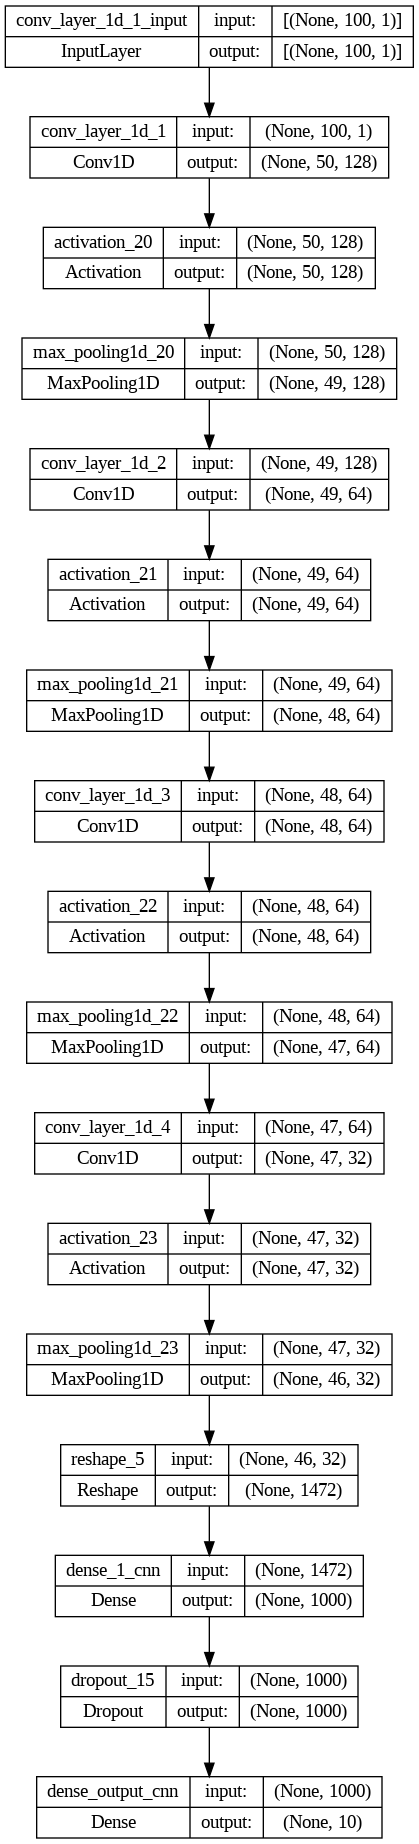

In [ ]:
plot_model(baseline_CNN, show_shapes=True, show_layer_names=True)

We will introduce into the training process two callbacks, as follows.

* `ReduceLROnPlateau`: reduce learning rate when a metric has stopped improving;
* `EarlyStopping`: stop the training process when a monitored metric has stopped improving.

The main reason for introducing the specified callbacks is to control the training process. For example, we do not want the model to continue its training process when the validation loss increases over a certain amount of epochs.

In [ ]:
# This is a callback that reduces the learning rate by a factor of half if the validation accuracy doesn't increase within 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)

# This is a callback that stops the training if the validation loss starts to increase.
early_stopping = EarlyStopping(monitor='val_loss', verbose=True, patience=5, min_delta=0.0001, restore_best_weights=True)

# Commences training of the model.
with tf.device('/device:GPU:0'):
  history_baseline_CNN = baseline_CNN.fit(x=training, y=train_label, batch_size=batch_size, epochs=epochs,
                                          validation_data=(validation, valid_label), 
                                          shuffle=True, initial_epoch=0, callbacks=[reduce_lr, early_stopping])

# We want to define something to store the training and validation loss and accuracy.
training_loss = history_baseline_CNN.history['loss']
training_accuracy = history_baseline_CNN.history['categorical_accuracy']
valid_loss = history_baseline_CNN.history['val_loss']
valid_accuracy = history_baseline_CNN.history['val_categorical_accuracy']

Epoch 1/30
55/55 [==============================] - 2s 15ms/step - loss: 2.9457 - categorical_accuracy: 0.5329 - val_loss: 2.0875 - val_categorical_accuracy: 0.7216 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 0s 7ms/step - loss: 1.8251 - categorical_accuracy: 0.7564 - val_loss: 1.4826 - val_categorical_accuracy: 0.8362 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 0s 7ms/step - loss: 1.3831 - categorical_accuracy: 0.8353 - val_loss: 1.2141 - val_categorical_accuracy: 0.8637 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 0s 8ms/step - loss: 1.1260 - categorical_accuracy: 0.8719 - val_loss: 1.0385 - val_categorical_accuracy: 0.8797 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 0s 7ms/step - loss: 0.9493 - categorical_accuracy: 0.8993 - val_loss: 0.9853 - val_categorical_accuracy: 0.8717 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 0s 7ms/step - loss: 0.8411 - categorical_accuracy: 0.9124 - va

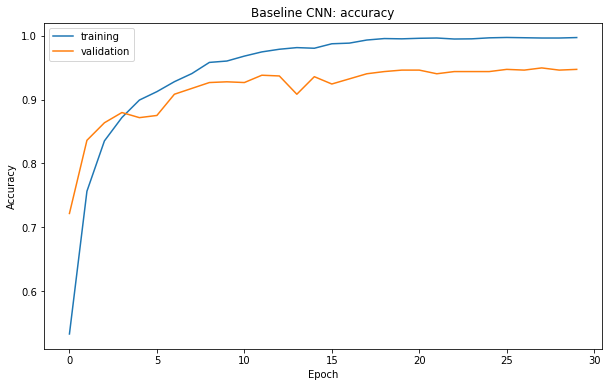

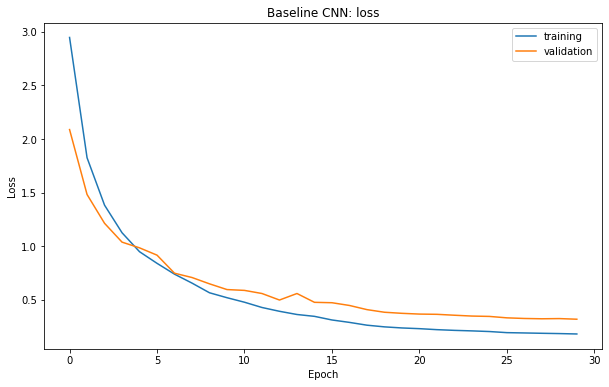

In [ ]:
# Summarize history for accuracy.
plt.figure(figsize=(10, 6))
plt.plot(training_accuracy)
plt.plot(valid_accuracy)
plt.title('Baseline CNN: accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss.
plt.figure(figsize=(10, 6))
plt.plot(training_loss)
plt.plot(valid_loss)
plt.title('Baseline CNN: loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We are getting very high validation accuracy with our model. Also, the training accuracy is at a peak of about 99%. It can be said that the max pooling and final fully connected layer are successful at feature distinction between label IDs.

One thing that should be noted is that we didn't use batch normalization after each convolution layer. Batch normalization is most commonly used to decrease the covariance shift of the output between convolutions to make the model converge faster. However, since the model begin converging early, this doesn't seem necessary.

### 5.2 Baseline CNN: visualizing feature maps

Let's define the training input to visualize feature maps using `keract` module.

In [ ]:
# Keract inputs for visualizing feature maps.
keract_inputs = training[:1]
keract_targets = train_label[:1]

**Note**: this will be the inputs for all the feature maps visualization.

Unfortunately, it is not possible to reconstruct entirely the audio file from MFCCs. In fact, MFCCs are extremely lossy features. Perfect reconstruction is not going to be possible in general.

Note that this is what happens inside MFCCs computation:

* STFT: magnitude spectrum (phase is discarded);
* Mel projection (frequency information is lost);
* Decibel scaling (relatively easy to recover from, though numerical precision issues can creep in for signals with high dynamic range);
* Discrete cosine transform and truncation (cepstrum information is lost).

The inverse function reverses each of these steps, and introduces approximations.

So, as an example, we are going to create a function to "reverse" the MFCCs features using `librosa` library.

In [ ]:
def mfccs_to_audio(mfccs, n_mfccs=FEATURE_LENGTH):
  # Reshape the input MFCCs array into a matrix with n_mfccs rows and 1 column.
  mfccs = mfccs.reshape(n_mfccs, 1)
  # Transpose the matrix to have 1 row and n_mfccs columns.
  mfccs = mfccs.T
  # Reconstruct the audio signal from the MFCCs.
  reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(mfccs, n_mels=n_mfccs, dct_type=2, norm='ortho')
  # Return the reconstructed audio signal.
  return reconstructed_audio

In [ ]:
# Store the converted audio from MFCC features.
reconstructed_audio = mfccs_to_audio(keract_inputs)

# Use the IPython display function to display the audio using reconstructed_audio.
# The audio will be played using the rate 22050.
ipd.display(ipd.Audio(reconstructed_audio, rate=22050))

As can be heard, the reconstruction is noisy and very different from the original audio sample.

Due to the fact that it is extremely difficult to reconstruct an audio from MFCCs features, we are going to plot the feature maps of the training sample for each layer of interest. It's important to underline that this type of representation was chosen in order to be able to visualize the whole process carried out by the model with a given input.

conv_layer_1d_1 (1, 50, 128) 


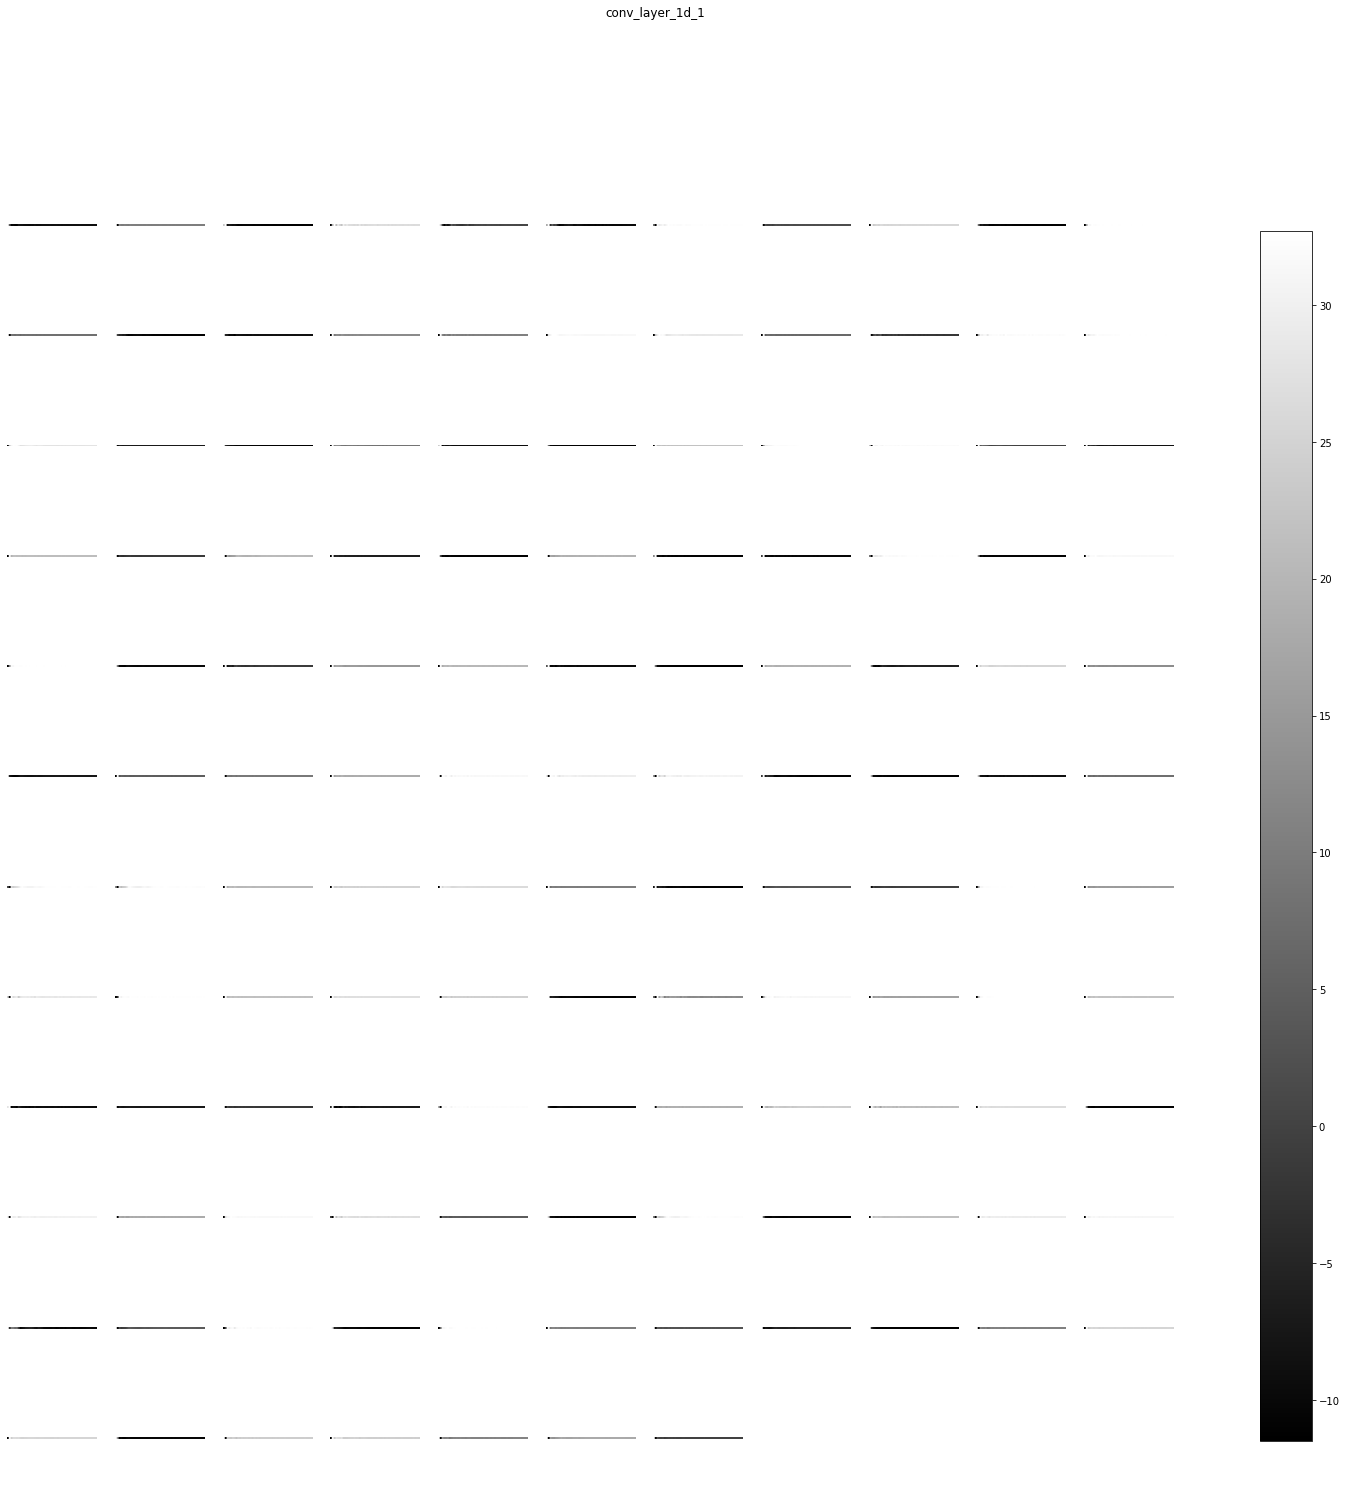

conv_layer_1d_2 (1, 49, 64) 


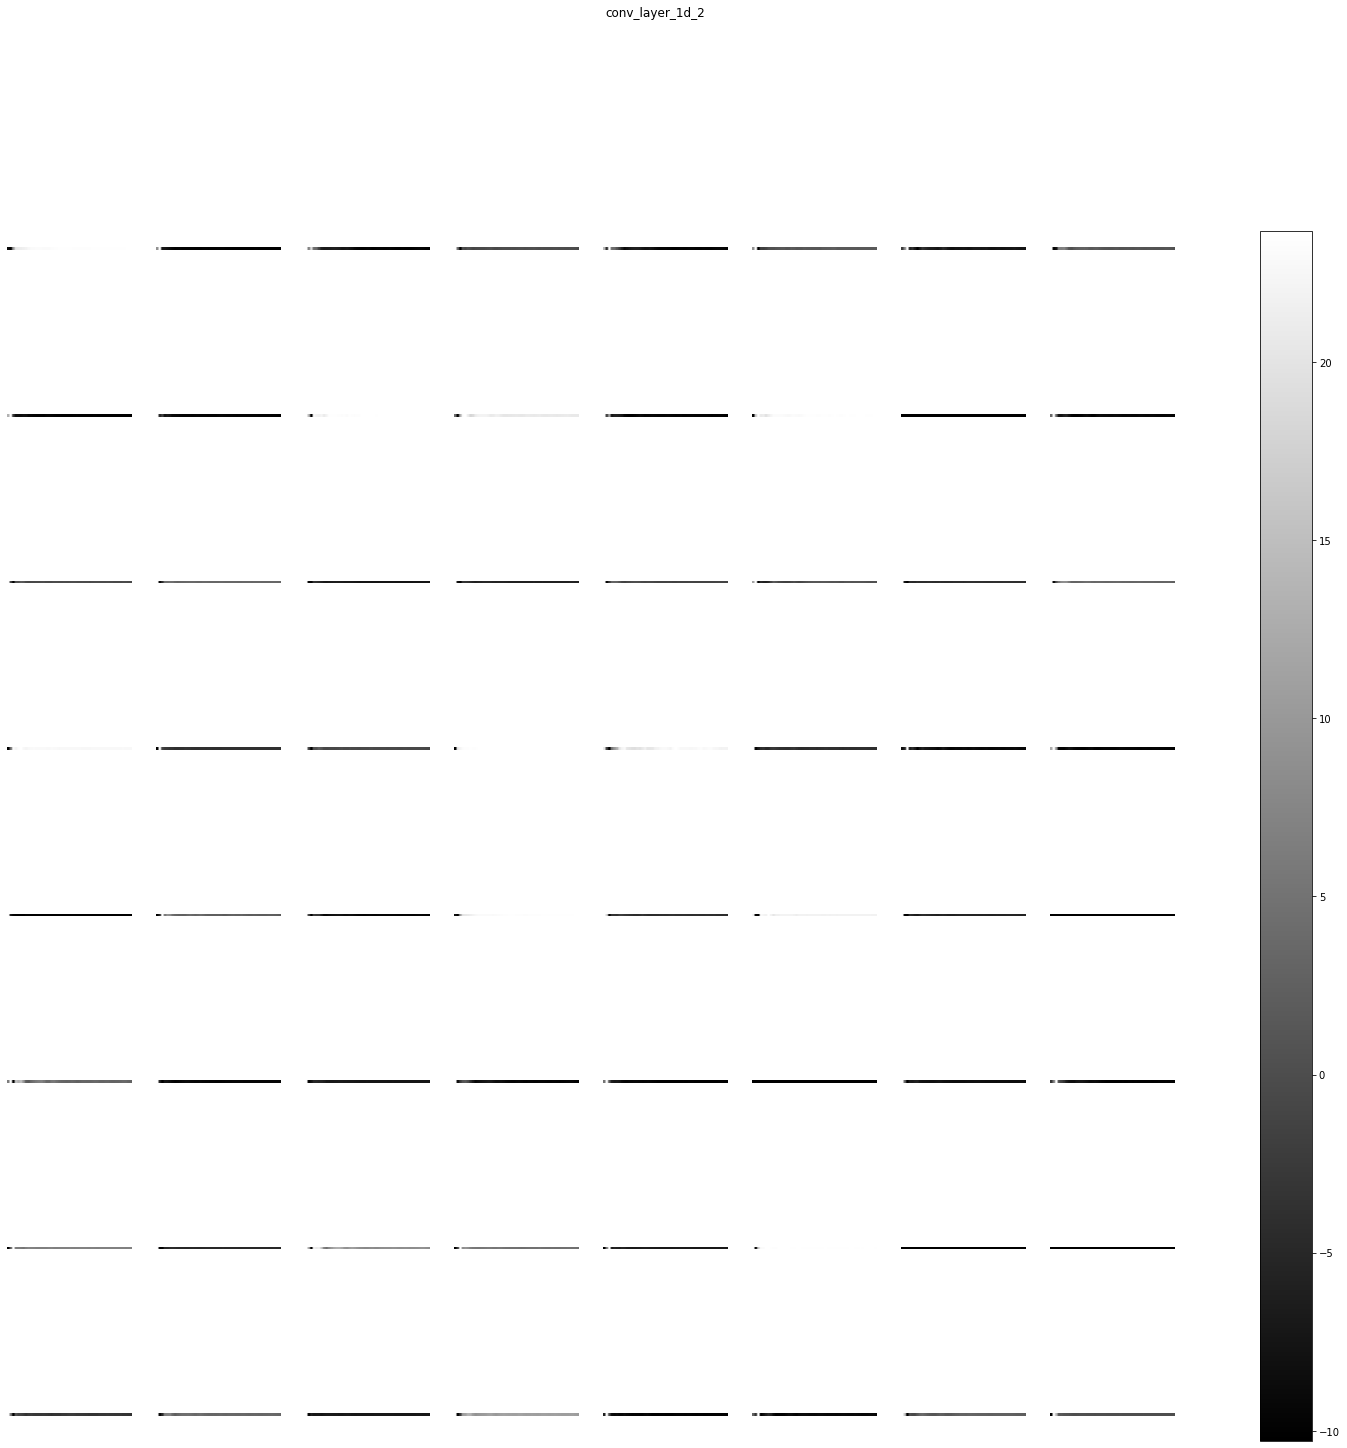

conv_layer_1d_3 (1, 48, 64) 


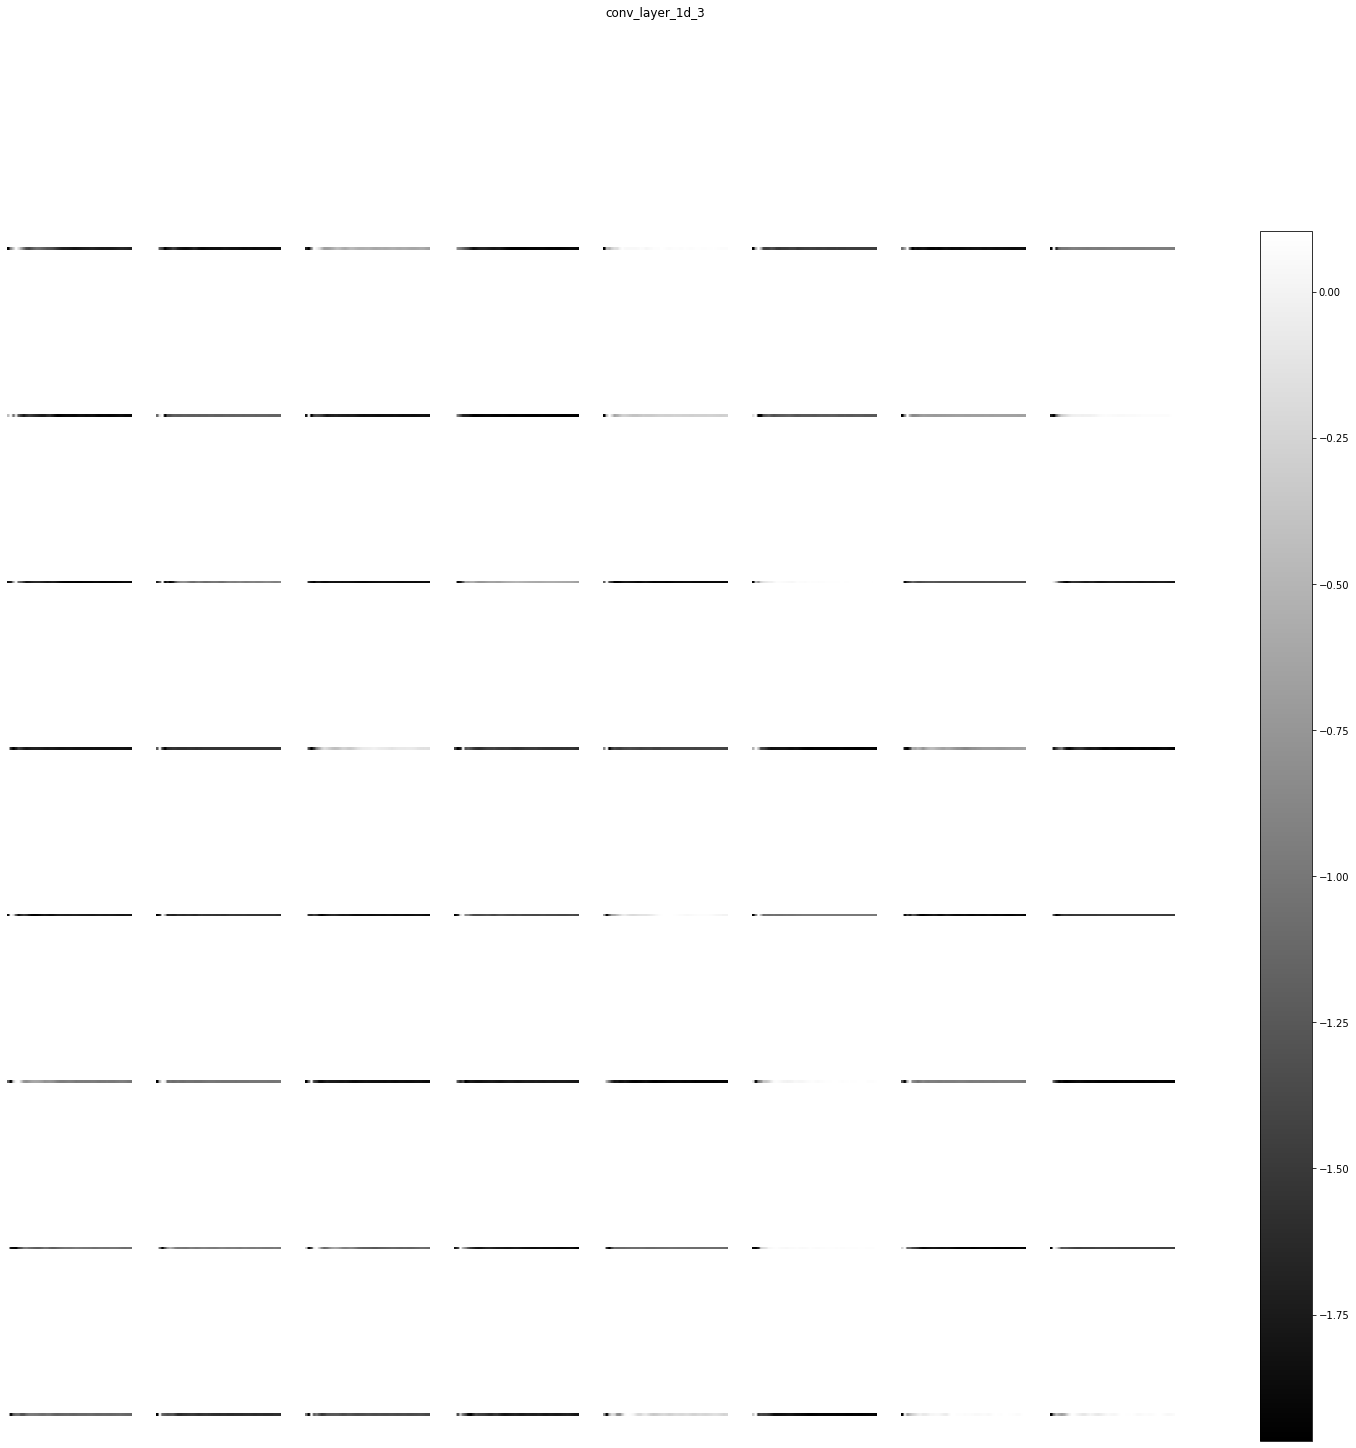

conv_layer_1d_4 (1, 47, 32) 


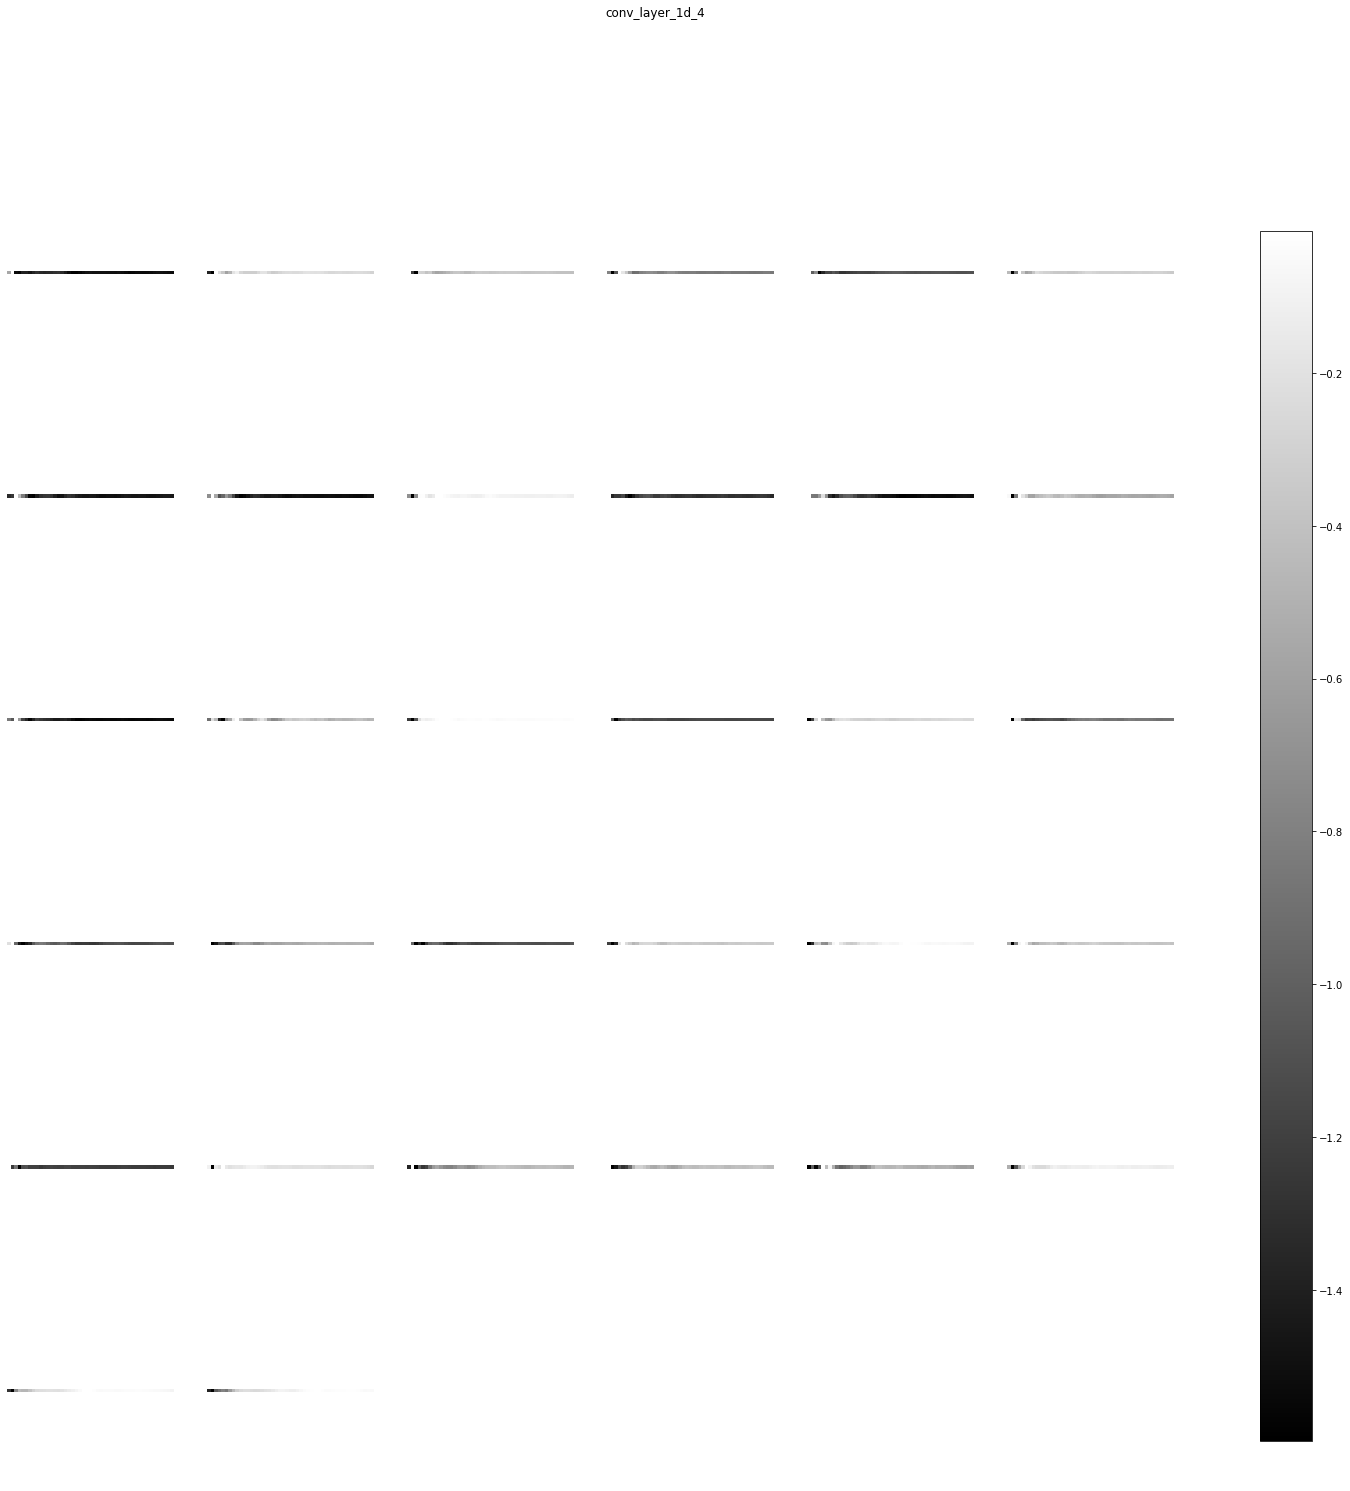

dense_1_cnn (1, 1000) 


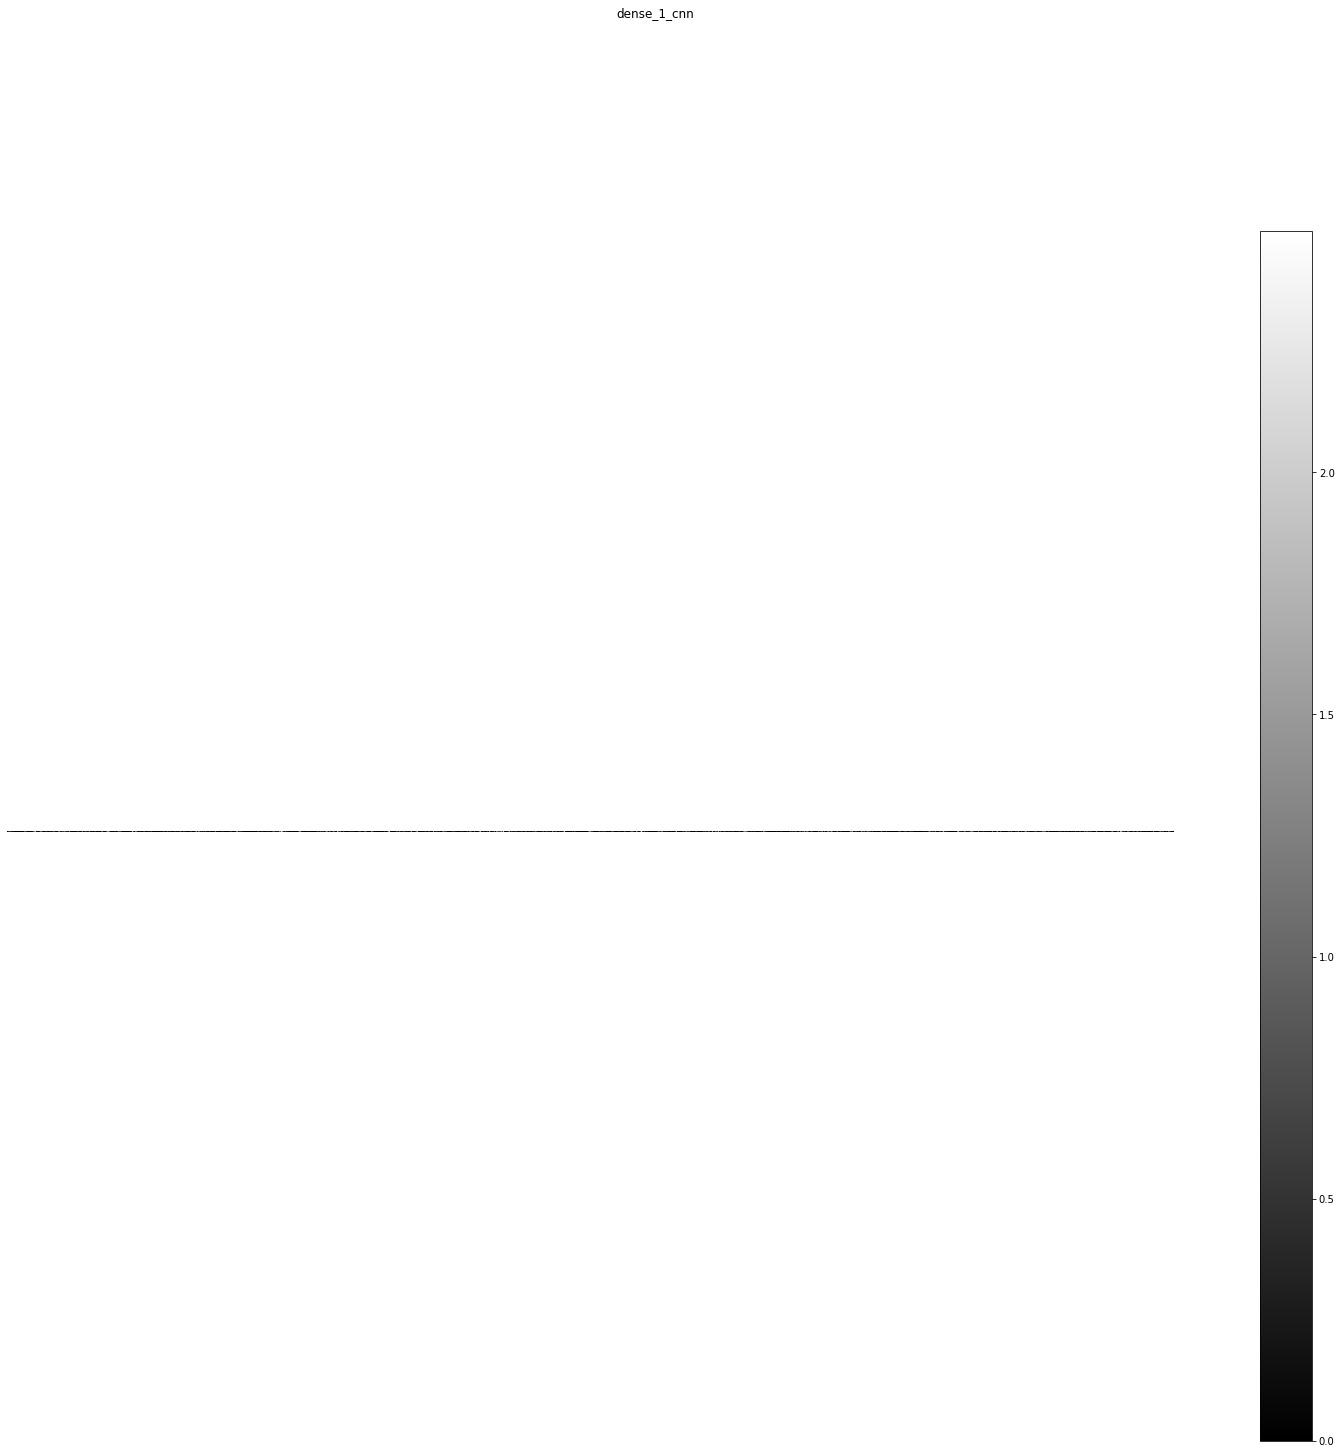

dense_output_cnn (1, 10) 


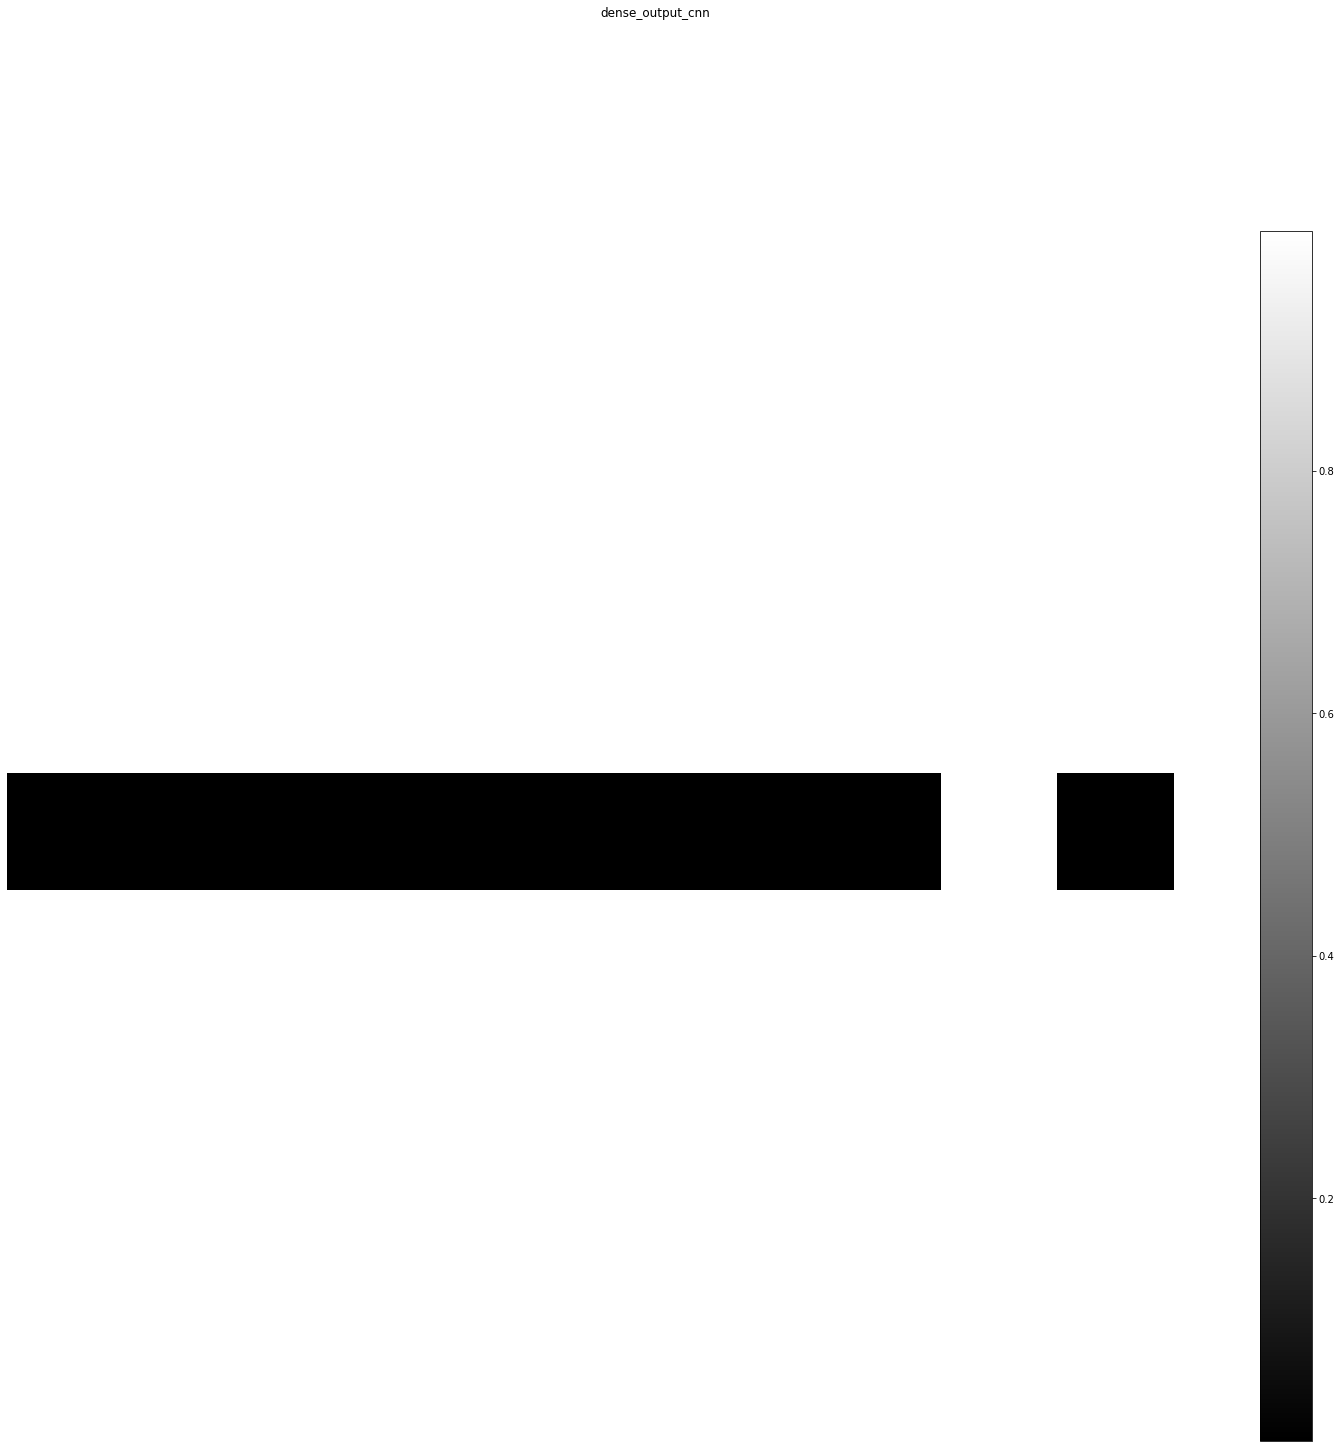

In [ ]:
# Get activations of different layers in the baseline_CNN model.
activations_CNN = get_activations(baseline_CNN, keract_inputs, layer_names=['conv_layer_1d_1', 'conv_layer_1d_2',
                                                                            'conv_layer_1d_3', 'conv_layer_1d_4',
                                                                            'dense_1_cnn', 'dense_output_cnn'])

# Display the activations of the different layers in the model.
display_activations(activations_CNN, cmap="gray", save=False)

As can be seen, the output above is a bit difficult to understand. Anyway, the convolutional layers process the MFCCs vectors as expected, using the number of filters specified. Also, the dense layers process the audio sample in a way that is reasonable with respect to the way the model is defined.

### 5.3 Baseline CNN: defining hidden representations and linear read-outs

We want to get the hidden representations of a model based on a subset of layers.

In [ ]:
def get_hidden_representations(model, layer_names, input_tensor):
    '''
    Given a model, the names of desired layers, and the input tensor,
    returns the hidden representations of the specified layers.

    Parameters: model: the model for which the hidden representations should be computed.
                layer_names: layer names for which we want to extract the hidden representations.
                input_tensor: the input tensor for the model.

    Returns: a dictionary that maps layer names to their hidden representations.
    '''
    hidden_representations = {}
    for layer_name in layer_names:
        # Create a new model that outputs the hidden representations of the desired layer.
        hidden_representation_model = Model(inputs=model.input,
                                            outputs=model.get_layer(layer_name).output)
        # Compute the hidden representations.
        hidden_representation = hidden_representation_model.predict(input_tensor)
        hidden_representations[layer_name] = hidden_representation
    return hidden_representations

It's important to set the layers of our interest to which we would extract the hidden representations.

In [ ]:
layer_names_CNN = ['conv_layer_1d_1', 'conv_layer_1d_2', 'conv_layer_1d_3', 'conv_layer_1d_4', 'dense_1_cnn']

In [ ]:
# Get the hidden representations of the CNN on the training set.
train_hidden_representations_CNN = get_hidden_representations(baseline_CNN, layer_names_CNN, training)

219/219 [==============================] - 2s 6ms/step


Now, we are going to define a linear model to perform linear read-outs for the specified layers of a model. This means that we will use the representations to classify the original data with a simple linear classifier, as a way to assess how much information is contained in each hidden representation. 

The following is the class of our interest.

In [ ]:
class LinearModel(tf.keras.Model):
  # Constructor to initialize the model with specified layer size and number of units.
  def __init__(self, layer_size, n_units=10):
    super(LinearModel, self).__init__()
    # Create a dense layer with the specified number of units and input shape equal to layer size.
    self.linear = Dense(units=n_units, input_shape=(layer_size,), activation='linear')

  # Override the call method to define the forward pass of the model.
  def call(self, x):
    return self.linear(x)

Then, we can instantiate a linear model for each layer of the CNN.

In [ ]:
# Get the input size of the first convolutional layer.
layer_size = baseline_CNN.get_layer(name='conv_layer_1d_1').input_shape[1]
# Initialize a LinearModel with the input size of the first convolutional layer.
linear_conv_1_CNN = LinearModel(layer_size)

# Get the input size of the second convolutional layer.
layer_size = baseline_CNN.get_layer(name='conv_layer_1d_2').input_shape[1]
# Initialize a LinearModel with the input size of the second convolutional layer.
linear_conv_2_CNN = LinearModel(layer_size)

# Get the input size of the third convolutional layer.
layer_size = baseline_CNN.get_layer(name='conv_layer_1d_3').input_shape[1]
# Initialize a LinearModel with the input size of the third convolutional layer.
linear_conv_3_CNN = LinearModel(layer_size)

# Get the input size of the fourth convolutional layer.
layer_size = baseline_CNN.get_layer(name='conv_layer_1d_4').input_shape[1]
# Initialize a LinearModel with the input size of the fourth convolutional layer.
linear_conv_4_CNN = LinearModel(layer_size)

# Get the input size of the dense layer.
layer_size = baseline_CNN.get_layer(name='dense_1_cnn').input_shape[1]
# Initialize a LinearModel with the input size of the dense layer.
linear_dense_1_CNN = LinearModel(layer_size)

Clearly, it does not make sense to instantiate a linear model on the last layer of our CNN, because it is used for the final classification task. Another key aspect to underline, is the fact that we are defining a linear read-out for the second to last layer of our model. This implies that, the linear model should show up performances comparable with the baseline CNN model itself.

Let's train our linear read-outs with those functions in the following. We should separate the training based on the type of layer because the predictions outputs have different shapes with respect to the layer considered. As a loss function, we consider the `CategoricalCrossentropy` which is the most suitable for one-hot encoded labels.

In [ ]:
def train_linear_convolutional(linear, hidden_reprs, targets, epochs=500):
  '''
  Train a linear model (linear read-out) on hidden representations of a convolutional layer.

  Args: linear: an instance of the LinearModel class.
        hidden_reprs: the hidden representations of the convolutional layer.
        targets: the ground truth labels of the samples.
        epochs: the number of training epochs (default 500).

  Returns: None.
  '''
  # Define the Adam optimizer with a learning rate of 1e-03.
  optimizer = Adam(learning_rate=1.0e-03)
  # Define the categorical cross-entropy loss function.
  loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
  # Compile the linear model with the optimizer and loss function.
  linear.compile(optimizer=optimizer, loss=loss_fn)
  
  # Train the model on GPU.
  with tf.device('/device:GPU:0'):
    # Loop over the specified number of epochs.
    for epoch in range(epochs):
      with tf.GradientTape() as tape:
        # Make predictions with the current weights of the model.
        predictions = linear(hidden_reprs)
        predictions_decoded = predictions[:, 0, :]
        loss = loss_fn(targets, predictions_decoded)

      # Compute the gradients of the loss with respect to the model's trainable variables.
      grads = tape.gradient(loss, linear.trainable_variables)
      # Apply the gradients to update the model's parameters.
      optimizer.apply_gradients(zip(grads, linear.trainable_variables))

      # Print the loss every 50 epochs.
      if epoch % 50 == 0:
        print("epoch: {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.numpy()))

In [ ]:
def train_linear_dense(linear, hidden_reprs, targets, epochs=500):
  '''
  Train a linear model (linear read-out) on hidden representations of a dense layer.

  Args: linear: an instance of the LinearModel class.
        hidden_reprs: the hidden representations of the dense layer.
        targets: the ground truth labels of the samples.
        epochs: the number of training epochs (default 500).

  Returns: None.
  '''
  # Define an Adam optimizer with learning rate 1.0e-03.
  optimizer = Adam(learning_rate=1.0e-03)
  # Define the categorical crossentropy loss function.
  loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
  # Compile the linear model with the optimizer and loss function.
  linear.compile(optimizer=optimizer, loss=loss_fn)

  # Train the model on GPU device.
  with tf.device('/device:GPU:0'):
    for epoch in range(epochs):
      # Start recording the computation history in a GradientTape.
      with tf.GradientTape() as tape:
        # Compute the model's predictions.
        predictions = linear(hidden_reprs)
        # Compute the loss based on the targets and predictions.
        loss = loss_fn(targets, predictions)

      # Compute the gradients of the loss with respect to the model's trainable variables.
      grads = tape.gradient(loss, linear.trainable_variables)
      # Apply the gradients to update the model's parameters.
      optimizer.apply_gradients(zip(grads, linear.trainable_variables))

      # Print the loss every 50 epochs.
      if epoch % 50 == 0:
        print("epoch: {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.numpy()))

Let's start the training process for all the linear read-outs previously defined.

In [ ]:
# Training process: linear_conv_1_CNN.
train_linear_convolutional(linear_conv_1_CNN, train_hidden_representations_CNN['conv_layer_1d_1'], train_label)

epoch:   1/500, loss = 39.3421
epoch:  51/500, loss = 3.3384
epoch: 101/500, loss = 1.9564
epoch: 151/500, loss = 1.8507
epoch: 201/500, loss = 1.8445
epoch: 251/500, loss = 1.8438
epoch: 301/500, loss = 1.8433
epoch: 351/500, loss = 1.8427
epoch: 401/500, loss = 1.8421
epoch: 451/500, loss = 1.8415


In [ ]:
# Training process: linear_conv_2_CNN.
train_linear_convolutional(linear_conv_2_CNN, train_hidden_representations_CNN['conv_layer_1d_2'], train_label)

epoch:   1/500, loss = 11.9465
epoch:  51/500, loss = 3.2586
epoch: 101/500, loss = 2.0698
epoch: 151/500, loss = 1.8804
epoch: 201/500, loss = 1.8294
epoch: 251/500, loss = 1.7937
epoch: 301/500, loss = 1.7640
epoch: 351/500, loss = 1.7386
epoch: 401/500, loss = 1.7166
epoch: 451/500, loss = 1.6975


In [ ]:
# Training process: linear_conv_3_CNN.
train_linear_convolutional(linear_conv_3_CNN, train_hidden_representations_CNN['conv_layer_1d_3'], train_label)

epoch:   1/500, loss = 5.6005
epoch:  51/500, loss = 2.2463
epoch: 101/500, loss = 1.7967
epoch: 151/500, loss = 1.6888
epoch: 201/500, loss = 1.6398
epoch: 251/500, loss = 1.6114
epoch: 301/500, loss = 1.5926
epoch: 351/500, loss = 1.5787
epoch: 401/500, loss = 1.5674
epoch: 451/500, loss = 1.5577


In [ ]:
# Training process: linear_conv_4_CNN.
train_linear_convolutional(linear_conv_4_CNN, train_hidden_representations_CNN['conv_layer_1d_4'], train_label)

epoch:   1/500, loss = 3.8471
epoch:  51/500, loss = 2.5620
epoch: 101/500, loss = 1.9928
epoch: 151/500, loss = 1.7797
epoch: 201/500, loss = 1.6975
epoch: 251/500, loss = 1.6545
epoch: 301/500, loss = 1.6262
epoch: 351/500, loss = 1.6049
epoch: 401/500, loss = 1.5878
epoch: 451/500, loss = 1.5735


In [ ]:
# Training process: linear_dense_1_CNN.
train_linear_dense(linear_dense_1_CNN, train_hidden_representations_CNN['dense_1_cnn'], train_label)

epoch:   1/500, loss = 3.0380
epoch:  51/500, loss = 0.2899
epoch: 101/500, loss = 0.1424
epoch: 151/500, loss = 0.0915
epoch: 201/500, loss = 0.0660
epoch: 251/500, loss = 0.0510
epoch: 301/500, loss = 0.0413
epoch: 351/500, loss = 0.0345
epoch: 401/500, loss = 0.0295
epoch: 451/500, loss = 0.0257


As can be seen from the results above, the loss for each linear read-out in the training process decreases with increasing epochs. Furthermore, a key aspect to note, is the lower loss in the layers at the bottom of the defined CNN. We therefore expect better performance on the test set based on the depth of the layer: the deeper the layer is, the better its performance (and therefore lower its loss) will be.

We are going to evaluate the performances on the test set of those trained models in the following sections.

### 5.4 Feed-forward neural network (FFNN) model

We want to define a feed-forward neural network model with three fully-connected (dense) layers and ReLU activation function in order to compare the performances of this model to the CNN defined previously. The model we are going to create uses the Flatten layer to flatten the input data before passing it through the dense layers. Then, the kernel_regularizer parameter of the L2 regularization function is used to prevent overfitting, with a regularization factor of 0.01. After each dense layer, a Dropout layer with a rate of 0.5 is added to randomly drop out 50% of the neurons during training to prevent overfitting as well. The output layer uses the softmax activation function, which is commonly used in classification tasks to predict a probability distribution over the class labels.

In [ ]:
def feed_forward_neural_network():
  # Initialize the model as a Sequential model.
  ffnn = Sequential(name='feed_forward_neural_network')
  # Add a Flatten layer to flatten the input data.
  ffnn.add(Flatten(input_shape=(100, 1)))
  # Add a dense (fully-connected) layer with 128 units and the ReLU activation function.
  ffnn.add(Dense(128, activation='relu', kernel_regularizer=l2(l=0.01), name='dense_1_ffnn'))
  # Add a Dropout layer with a rate of 0.5.
  ffnn.add(Dropout(0.5))
  # Add a second dense layer with 64 units and the ReLU activation function.
  ffnn.add(Dense(64, activation='relu', kernel_regularizer=l2(l=0.01), name='dense_2_ffnn'))
  # Add a second Dropout layer with a rate of 0.5.
  ffnn.add(Dropout(0.5))
  # Final softmax layer for final classification over 10 classes.
  ffnn.add(Dense(10, activation='softmax', name='dense_output_ffnn'))
  return ffnn

Let's set up the hyperparameters of the training process. Note that, in this case, we choose a `batch_size` which is one-third of the batch size defined on the CNN and a number of `epochs` which is higher (those changes will be explained in the following). For the rest of the hyperparameters, we keep the same settings of the CNN.

In [ ]:
batch_size = 32 # Batch size: we want to start with a small batch size smaller than the standard.
epochs = 50 # We can set the number of epochs to train as 50 for now.
l_r = 1e-03 # Learning rate: the learning rate is usually logarithmically changed between 1e-07 to 0.1. 0.001 seems to be a good place to start.

# We need to set the optimizer, loss function, and accuracy metric for each model.
optimizer = Adam(learning_rate=l_r) # Adam is computational efficient and requires little memory.
ce_loss = categorical_crossentropy # This is a good loss metric for multiple one-hot encoded classes.
accuracy_metric = CategoricalAccuracy() # This is a good accuracy metric for multiple one-hot encoded classes.

In [ ]:
# Compiling the model.
feed_forward_neural_network = feed_forward_neural_network()
feed_forward_neural_network.compile(optimizer=optimizer, loss=ce_loss, metrics=[accuracy_metric])

In [ ]:
# Checking the parameters of the model.
feed_forward_neural_network.summary()

Model: "feed_forward_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 100)               0         
                                                                 
 dense_1_ffnn (Dense)        (None, 128)               12928     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_2_ffnn (Dense)        (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_output_ffnn (Dense)   (None, 10)                650       
                                                                 
Total params: 21,834
Trainable params: 

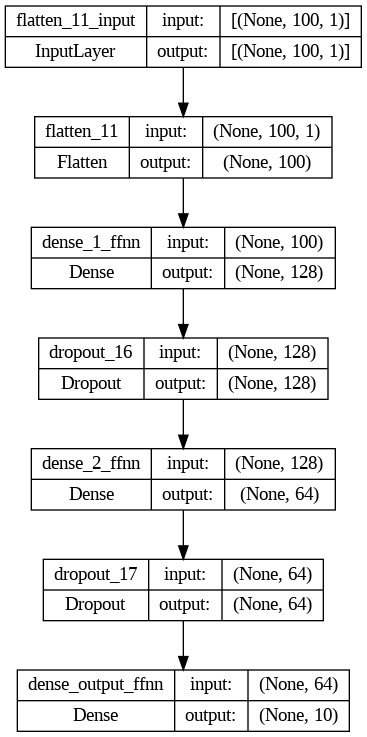

In [ ]:
plot_model(feed_forward_neural_network, show_shapes=True, show_layer_names=True)

Let's define the callbacks used in the training process. They are the same of the CNN model, introduced for the same reasons as well.

In [ ]:
# This is a callback that reduces the learning rate by a factor of half if the validation accuracy doesn't increase within 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)

# This is a callback that stops the training if the validation loss starts to increase.
early_stopping = EarlyStopping(monitor='val_loss', verbose=True, patience=5, min_delta=0.0001, restore_best_weights=True)

# Commences training of the model.
with tf.device('/device:GPU:0'):
  history_ffnn = feed_forward_neural_network.fit(x=training, y=train_label, batch_size=batch_size, epochs=epochs,
                                                 validation_data=(validation, valid_label), 
                                                 shuffle=True, initial_epoch=0, callbacks=[reduce_lr, early_stopping])

# We want to define something to store the training and validation loss and accuracy.
training_loss = history_ffnn.history['loss']
training_accuracy = history_ffnn.history['categorical_accuracy']
valid_loss = history_ffnn.history['val_loss']
valid_accuracy = history_ffnn.history['val_categorical_accuracy']

Epoch 1/50
219/219 [==============================] - 2s 5ms/step - loss: 14.8943 - categorical_accuracy: 0.1195 - val_loss: 3.7192 - val_categorical_accuracy: 0.1157 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - 1s 4ms/step - loss: 3.7452 - categorical_accuracy: 0.1229 - val_loss: 3.4448 - val_categorical_accuracy: 0.1157 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 3.4038 - categorical_accuracy: 0.1178 - val_loss: 3.2324 - val_categorical_accuracy: 0.1157 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 3.1776 - categorical_accuracy: 0.1179 - val_loss: 3.0698 - val_categorical_accuracy: 0.1157 - lr: 0.0010
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 3.0214 - categorical_accuracy: 0.1159 - val_loss: 2.9451 - val_categorical_accuracy: 0.1157 - lr: 0.0010
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 2.9035 - categorical_accuracy:

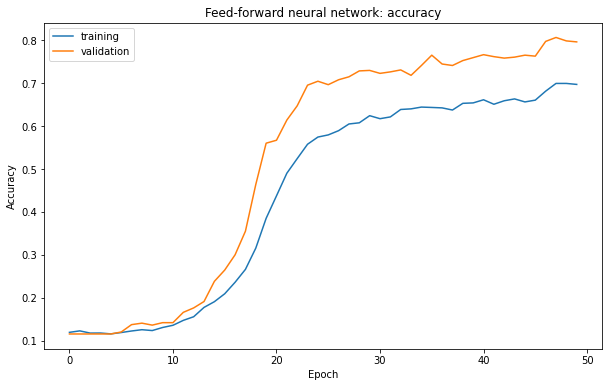

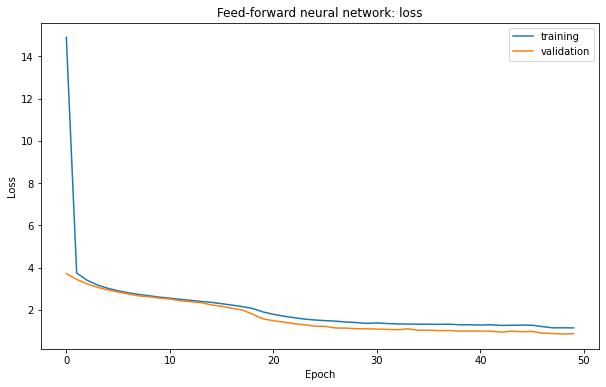

In [ ]:
# Summarize history for accuracy.
plt.figure(figsize=(10, 6))
plt.plot(training_accuracy)
plt.plot(valid_accuracy)
plt.title('Feed-forward neural network: accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss.
plt.figure(figsize=(10, 6))
plt.plot(training_loss)
plt.plot(valid_loss)
plt.title('Feed-forward neural network: loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

The above log suggest that the feed-forward neural network model is overfitting the dataset. Overfitting occurs when a model starts to learn the noise in the training data rather than the underlying relationship, leading to a decline in its performance on unseen data. Overall, it shows good performances in terms of categorical accuracy and also on the test dataset (as shown in the following sections).

Even if a larger number of `epochs` was used, the model does not perform as the CNN. This was a try to understand if that "simple" model could reach the performances of the model defined previously simply "augmenting" the training process. For the same reason, we changed the `batch_size` founding out that this one is the best possible for that specific model.

Now, we will consider the same steps presented previously with the CNN.

### 5.5 Feed-forward neural network: visualizing feature maps

Let's get the activations of the feed-forward neural network model, showing up the feature maps of the same training sample taken into account before.

dense_1_ffnn (1, 128) 


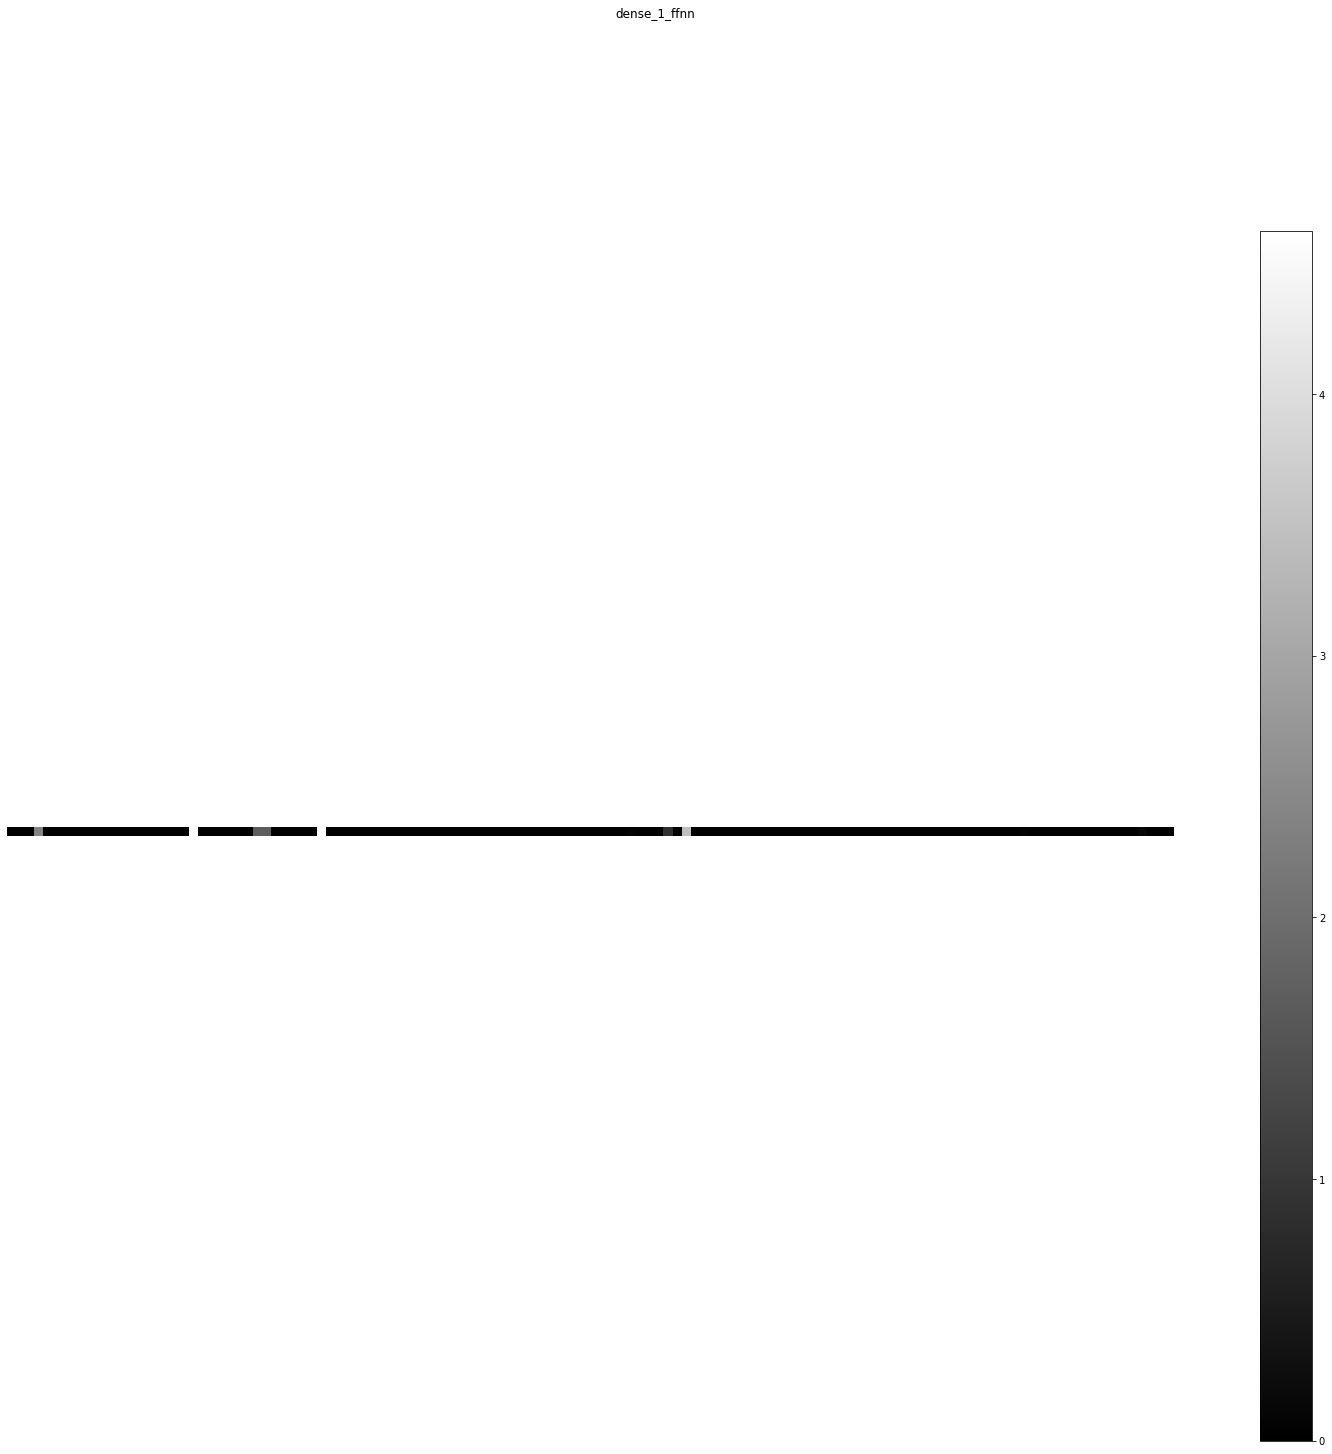

dense_2_ffnn (1, 64) 


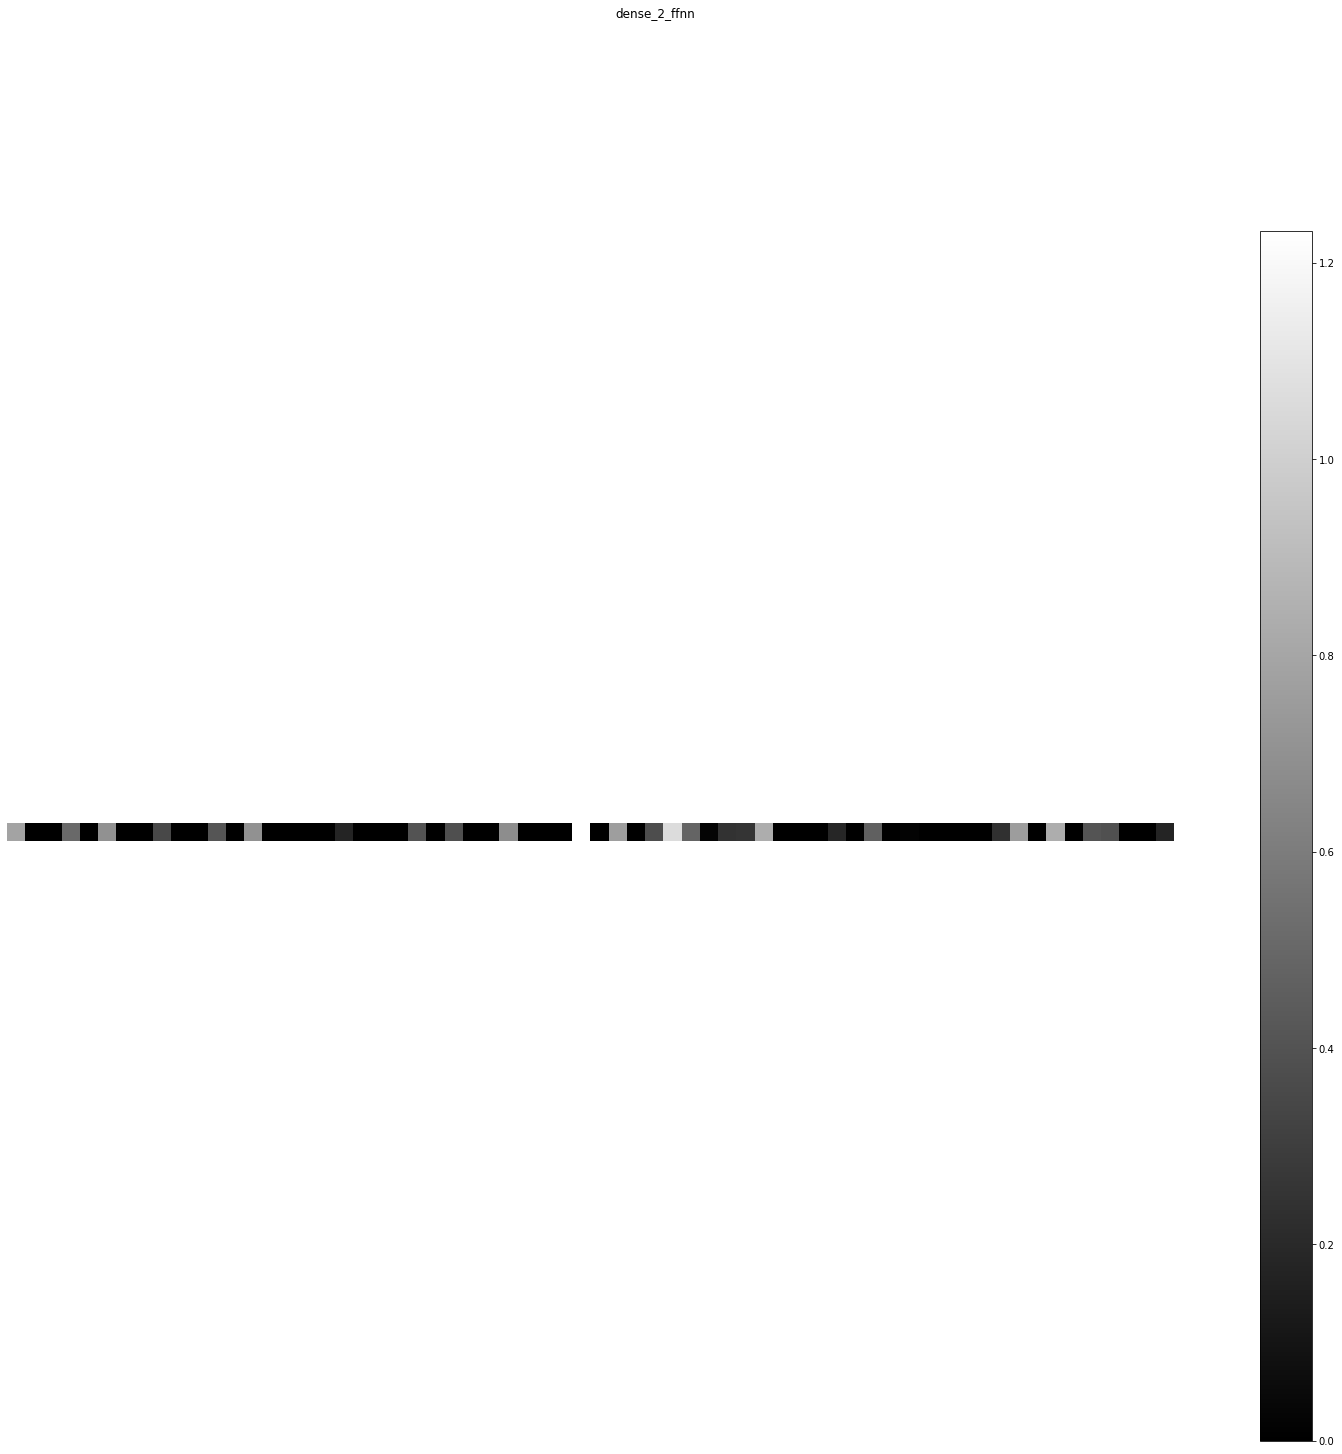

dense_output_ffnn (1, 10) 


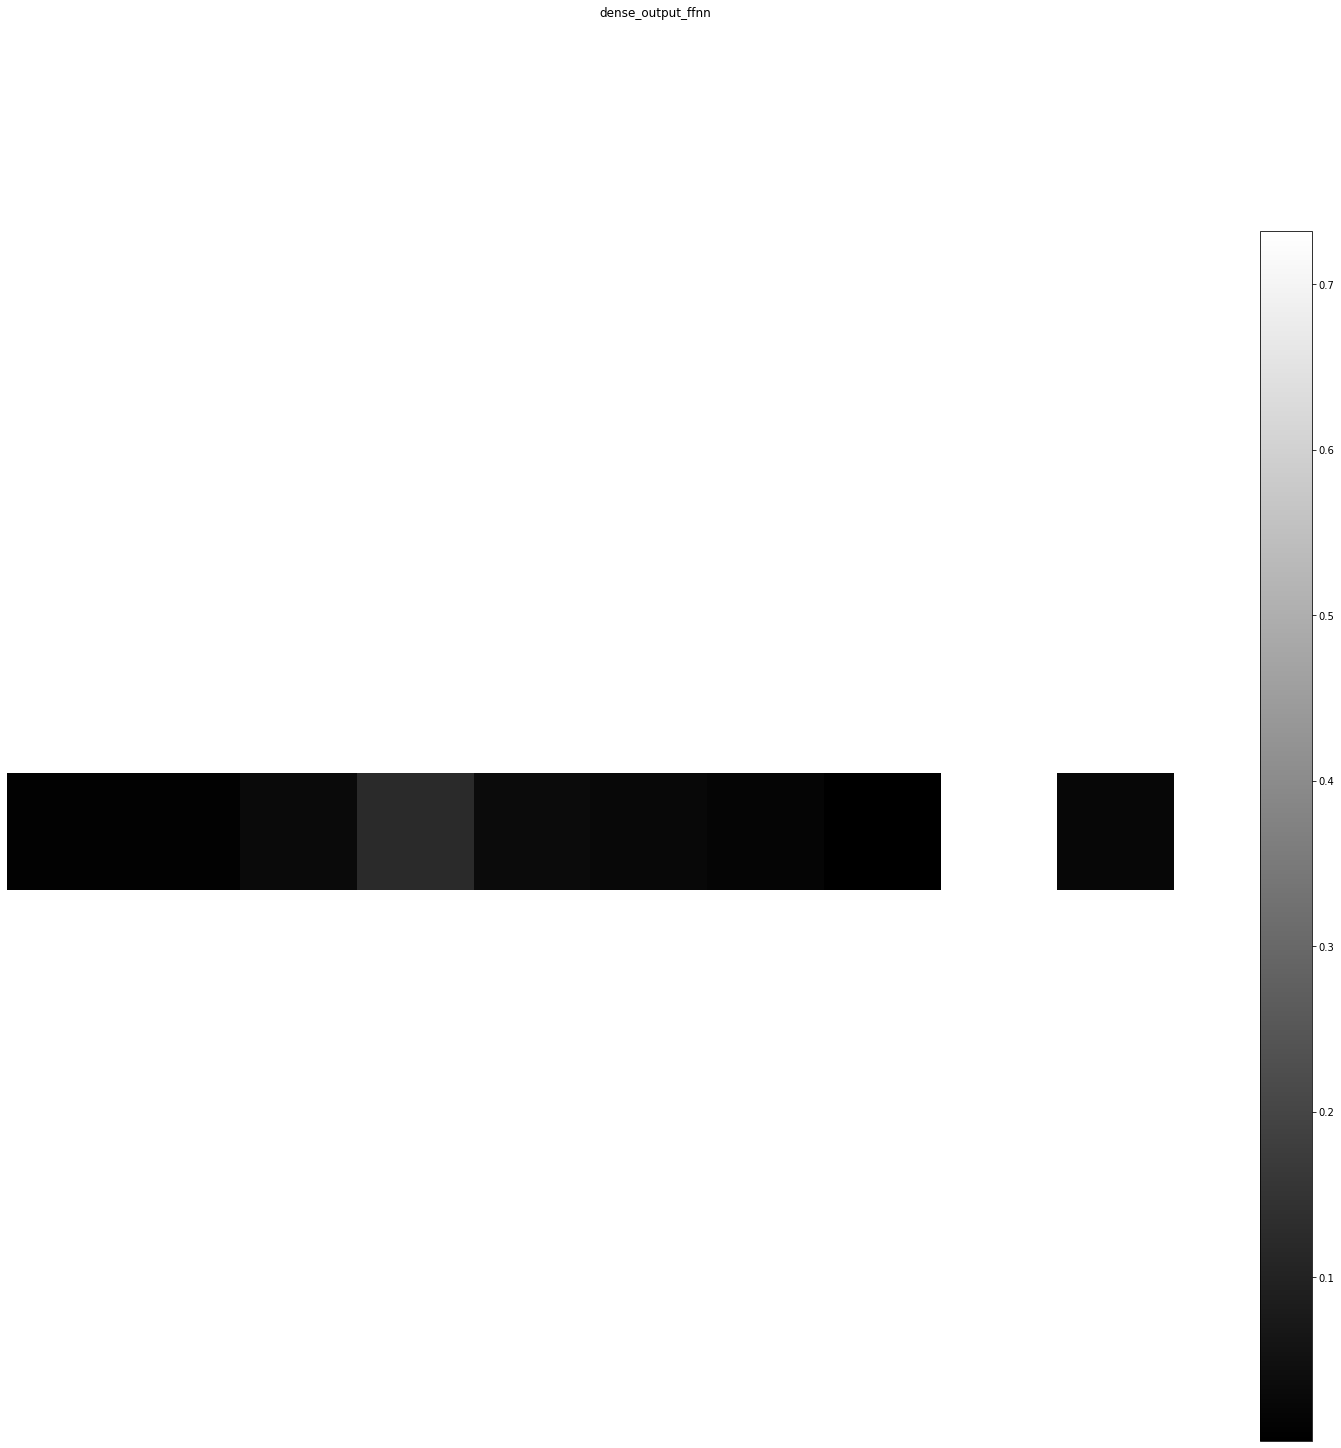

In [ ]:
# Get activations of different layers in the feed-forward neural network model.
activations_ffnn = get_activations(feed_forward_neural_network, keract_inputs, layer_names=['dense_1_ffnn',
                                                                                            'dense_2_ffnn',
                                                                                            'dense_output_ffnn'])
# Display the activations of the different layers in the model.
display_activations(activations_ffnn, cmap="gray", save=False)

Also in this case, the output is a bit difficult to understand. Anyway, the dense layers process the audio sample in a way that is reasonable with respect to how the model is defined.

### 5.6 Feed-forward neural network: defining hidden representations and linear read-outs

Let's now consider the hidden representations for the "internal" layers of the model.

In [ ]:
layer_names_ffnn = ['dense_1_ffnn', 'dense_2_ffnn']

In [ ]:
# Get the hidden representations of the feed-forward neural network on the training set.
train_hidden_representations_ffnn = get_hidden_representations(feed_forward_neural_network, layer_names_ffnn, training)

219/219 [==============================] - 1s 2ms/step


Then, as done previously, we instantiate the linear read-outs for each layer considered.

In [ ]:
# Get the size of the input for the first dense layer in the feed-forward neural network.
layer_size = feed_forward_neural_network.get_layer(name='dense_1_ffnn').input_shape[1]
# Instantiate the LinearModel class with the layer size for the first dense layer.
linear_dense_1_ffnn = LinearModel(layer_size)

# Get the size of the input for the second dense layer in the feed-forward neural network.
layer_size = feed_forward_neural_network.get_layer(name='dense_2_ffnn').input_shape[1]
# Instantiate the LinearModel class with the layer size for the second dense layer.
linear_dense_2_ffnn = LinearModel(layer_size)

Also in this case, it does not make sense to introduce a linear read-out for the last layer of the feed-forward neural network.

In the following, we start the training process.

In [ ]:
# Training process: linear_dense_1_ffnn.
train_linear_dense(linear_dense_1_ffnn, train_hidden_representations_ffnn['dense_1_ffnn'], train_label)

epoch:   1/500, loss = 2.9413
epoch:  51/500, loss = 1.4751
epoch: 101/500, loss = 1.0393
epoch: 151/500, loss = 0.8664
epoch: 201/500, loss = 0.7711
epoch: 251/500, loss = 0.7092
epoch: 301/500, loss = 0.6652
epoch: 351/500, loss = 0.6319
epoch: 401/500, loss = 0.6056
epoch: 451/500, loss = 0.5841


In [ ]:
# Training process: linear_dense_2_ffnn.
train_linear_dense(linear_dense_2_ffnn, train_hidden_representations_ffnn['dense_2_ffnn'], train_label)

epoch:   1/500, loss = 2.7315
epoch:  51/500, loss = 1.8144
epoch: 101/500, loss = 1.3281
epoch: 151/500, loss = 1.0759
epoch: 201/500, loss = 0.9260
epoch: 251/500, loss = 0.8299
epoch: 301/500, loss = 0.7644
epoch: 351/500, loss = 0.7172
epoch: 401/500, loss = 0.6818
epoch: 451/500, loss = 0.6544


Also here, the loss for each linear read-out in the training process decreases with increasing epochs. Furthermore, we have a lower loss in the layers at the bottom of the feed-forward neural network. As as consequence, we expect better performance on the test set based on the depth of the layer: the deeper the layer is, the better its performance and therefore lower its loss will be (as in the CNN case).

## 6. Inference: supervised models and linear read-outs

In this section, we want to see how well the supervised models and the linear read-outs perform on the test dataset that we created.

### 6.1 Testing set accuracies: supervised models

In [ ]:
# Testing the baseline CNN model on the test set.
test_pred_baseline_CNN = baseline_CNN.predict(test)
accuracy_baseline_CNN = CategoricalAccuracy()
accuracy_baseline_CNN.update_state(test_label, test_pred_baseline_CNN)
accuracy_baseline_CNN = accuracy_baseline_CNN.result().numpy()

28/28 [==============================] - 0s 3ms/step


In [ ]:
# Printing the test accuracy.
accuracy_baseline_CNN

0.9414466

As can be seen from the result above, the baseline CNN model performs extremely well on the test dataset.

In [ ]:
# Testing the feed-forward neural network model on the test set.
test_pred_ffnn = feed_forward_neural_network.predict(test)
accuracy_ffnn = CategoricalAccuracy()
accuracy_ffnn.update_state(test_label, test_pred_ffnn)
accuracy_ffnn = accuracy_ffnn.result().numpy()

28/28 [==============================] - 0s 2ms/step


In [ ]:
# Printing the test accuracy.
accuracy_ffnn

0.7979334

Considering the feed-forward neural network, it also performs fairly well on the test dataset.

### 6.2 Testing set accuracies: linear read-outs

Now, we will consider linear read-outs performances in terms of test accuracy.

#### 6.2.1 Testing set accuracies: baseline CNN linear read-outs

Let's first get the hidden representations of the CNN for the previously specified layers on the test set.

In [ ]:
# Get the hidden representations of the CNN on the test set.
test_hidden_representations_CNN = get_hidden_representations(baseline_CNN, layer_names_CNN, test)

28/28 [==============================] - 0s 3ms/step


Then, we are going to generate the predictions for all the layers considered.

In [ ]:
# Generate predictions for the hidden representations from the first 1D convolutional layer in the CNN.
predictions_test_conv_1_CNN = linear_conv_1_CNN(test_hidden_representations_CNN['conv_layer_1d_1'])

# Generate predictions for the hidden representations from the second 1D convolutional layer in the CNN.
predictions_test_conv_2_CNN = linear_conv_2_CNN(test_hidden_representations_CNN['conv_layer_1d_2'])

# Generate predictions for the hidden representations from the third 1D convolutional layer in the CNN.
predictions_test_conv_3_CNN = linear_conv_3_CNN(test_hidden_representations_CNN['conv_layer_1d_3'])

# Generate predictions for the hidden representations from the fourth 1D convolutional layer in the CNN.
predictions_test_conv_4_CNN = linear_conv_4_CNN(test_hidden_representations_CNN['conv_layer_1d_4'])

# Generate predictions for the hidden representations from the first dense layer in the CNN.
predictions_test_dense_1_CNN = linear_dense_1_CNN(test_hidden_representations_CNN['dense_1_cnn'])

We need to define a function in order to compute the accuracies on the test set. As we did before for the training, let's create two different functions to compute the `CategoricalAccuracy` based on the type of layer we are considering.

In [ ]:
def compute_accuracy_linear_convolutional(predictions_test, targets):
  '''
  Compute the accuracy of predictions made by a linear model applied to the output of a convolutional layer.

  Input: predictions_test (numpy.ndarray): the predictions made by the linear read-outs on the test set.
         targets (numpy.ndarray): the true labels for the test set.
         
  Output: float: the accuracy of the predictions, as a fraction of correct predictions.
  '''
  # Initialize the accuracy metric.
  accuracy = CategoricalAccuracy()
  # Update the accuracy metric with the predicted labels and true labels for the test set.
  accuracy.update_state(targets, predictions_test[:, 0, :])
  # Get the accuracy as a numpy array.
  accuracy = accuracy.result().numpy()
  # Return the accuracy.
  return accuracy

In [ ]:
def compute_accuracy_linear_dense(predictions_test, targets):
  '''
  Compute the accuracy of predictions made by a linear model applied to the output of a dense layer.

  Input: predictions_test (numpy.ndarray): the predictions made by the linear read-outs on the test set.
         targets (numpy.ndarray): the true labels for the test set.
         
  Output: float: the accuracy of the predictions, as a fraction of correct predictions.
  '''
  # Initialize the accuracy metric.
  accuracy = CategoricalAccuracy()
  # Update the accuracy metric with the predicted labels and true labels for the test set.
  accuracy.update_state(targets, predictions_test)
  # Get the accuracy as a numpy array.
  accuracy = accuracy.result().numpy()
  # Return the accuracy.
  return accuracy

Now, we are going to finally compute the accuracies for the linear read-outs defined in the previous sections.

In [ ]:
compute_accuracy_linear_convolutional(predictions_test_conv_1_CNN, test_label)

0.3455798

In [ ]:
compute_accuracy_linear_convolutional(predictions_test_conv_2_CNN, test_label)

0.39265212

In [ ]:
compute_accuracy_linear_convolutional(predictions_test_conv_3_CNN, test_label)

0.46498278

In [ ]:
compute_accuracy_linear_convolutional(predictions_test_conv_4_CNN, test_label)

0.4477612

In [ ]:
compute_accuracy_linear_dense(predictions_test_dense_1_CNN, test_label)

0.94833523

As can be seen from the results above, we obtain an increasing accuracy based on the depth of the layer considered. In fact, the accuracies of the linear read-outs related to the convolutional layers are lower than the one computed by the penultimate layer. Another important aspect to consider is that the accuracy of the last linear read-out is comparable with the one computed by the model itself. This is exactly what we expected.

#### 6.2.2 Testing set accuracies: feed-forward neural network linear read-outs

We repeat the same procedure for the feed-forward neural network linear read-outs.

Firstly, we get the hidden representations of the model for the previously specified layers on the test set.

In [ ]:
# Get the hidden representations of the feed-forward neural network on the test set.
test_hidden_representations_ffnn = get_hidden_representations(feed_forward_neural_network, layer_names_ffnn, test)

28/28 [==============================] - 0s 1ms/step


Then, we generate predictions for each linear read-out, using on the hidden representations computed above.

In [ ]:
# Generate predictions for the hidden representations from the first dense layer in the feed-forward neural network.
predictions_test_dense_1_ffnn = linear_dense_1_ffnn(test_hidden_representations_ffnn['dense_1_ffnn'])

# Generate predictions for the hidden representations from the second dense layer in the feed-forward neural network.
predictions_test_dense_2_ffnn = linear_dense_2_ffnn(test_hidden_representations_ffnn['dense_2_ffnn'])

Finally, we are going to compute the accuracies.

In [ ]:
compute_accuracy_linear_dense(predictions_test_dense_1_ffnn, test_label)

0.81171066

In [ ]:
compute_accuracy_linear_dense(predictions_test_dense_2_ffnn, test_label)

0.7807118

In this case, it's interesting the fact that the first (in terms of depth) dense layer shows up an accuracy which is better than the second one. Also here, the last linear read-out accuracy is comparable to the one computed by the model itself. All these aspects reflect the hypotheses made in the previous sections.

### 6.3 Confusion matrices: supervised models

It would also be very interesting to see how different classes in the test dataset performed.

In order to do so, we are going to plot confusion matrices with the following function.

In [ ]:
def plot_confusion_matrix(confusion_matrix):
    '''
    Plots a confusion matrix.

    Args: confusion_matrix: a 2D numpy array representing the confusion matrix.
    Returns: None.
    '''
    # Convert the confusion matrix into a Pandas DataFrame.
    df_cm = pd.DataFrame(np.array(confusion_matrix),
                         index=[i for i in range(10)],
                         columns=[i for i in range(10)])

    plt.figure(figsize=(10, 7))
    # Create a heatmap of the confusion matrix data.
    heatmap = sn.heatmap(df_cm, annot=True)
    # Add x-axis and y-axis labels to the heatmap.
    heatmap.set(xlabel='Prediction', ylabel='Ground Truth Label')
    # Display the heatmap.
    plt.show()

Let's plot the confusion matrix for the baseline CNN model with respect to its predictions on the test set.

In [ ]:
# Test labels decoded.
test_label_decoded = tf.math.argmax(test_label, axis=1)

In [ ]:
# Test predictions decoded for baseline CNN.
test_pred_baseline_CNN_decoded = tf.math.argmax(test_pred_baseline_CNN, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_baseline_CNN_decoded)

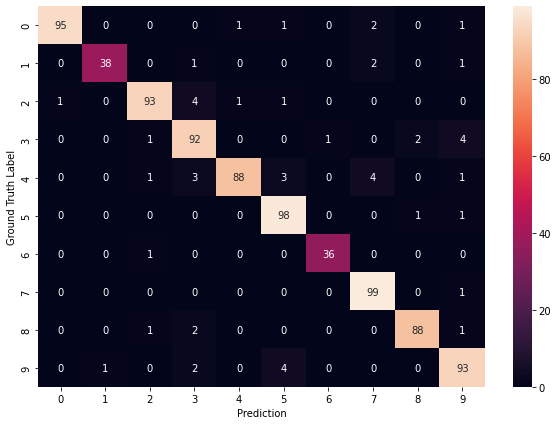

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

It can be said that the baseline CNN model has performed very well across all classes. One detail that should be noted is that classes 1 and 6 seemed to underperform a little bit relative to the other classes. This is likely due to the dataset imbalance that we already seen on EDA section of this project.

Let's do the same procedure with the feed-forward neural network.

In [ ]:
# Test predictions decoded for feed-forward neural network.
test_pred_ffnn_decoded = tf.math.argmax(test_pred_ffnn, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_ffnn_decoded)

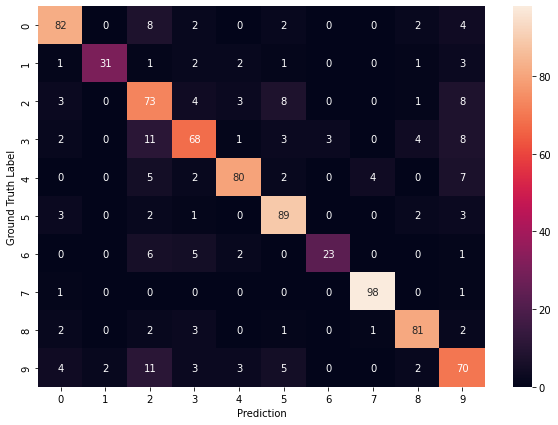

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

Also the feed-forward neural network model has performed well across all classes. The dataset imbalance shows up also in this case.

## 7. Robustness to noise

We will now inject some noise in the input data in order to see how much the representations learned by the CNN and the feed-forward network are robust to perturbations injected in the dataset.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curves describing the decrease in classification accuracy with respect to the noise level.

Let's add Gaussian noise to the test data using a well defined noise factor.

In [ ]:
# Add Gaussian noise to the test data.
noise_factor = 1.0
noisy_test = test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test.shape)

Let's test our supervised models on the "noisy" test set.

In [ ]:
# Testing the baseline CNN model on the noisy test set.
test_pred_noisy_CNN = baseline_CNN.predict(noisy_test)
noisy_accuracy_CNN = CategoricalAccuracy()
noisy_accuracy_CNN.update_state(test_label, test_pred_noisy_CNN)
noisy_accuracy_CNN = noisy_accuracy_CNN.result().numpy()

28/28 [==============================] - 0s 3ms/step


In [ ]:
noisy_accuracy_CNN

0.8381171

As expected, the performances of the CNN model decrease as the noise factor increases.

In [ ]:
# Testing the ffnn model on the noisy test set.
test_pred_noisy_ffnn = feed_forward_neural_network.predict(noisy_test)
noisy_accuracy_ffnn = CategoricalAccuracy()
noisy_accuracy_ffnn.update_state(test_label, test_pred_noisy_ffnn)
noisy_accuracy_ffnn = noisy_accuracy_ffnn.result().numpy()

28/28 [==============================] - 0s 2ms/step


In [ ]:
noisy_accuracy_ffnn

0.7749713

The same can be said for the feed-forward neural network. In this case, it seems that the model is less sensible to the noise with respect to the CNN, as its accuracy does not decrease so much even if the noise factor is fairly high.

### 7.1 Confusion matrices: noise injection

Let's plot confusion matrices in both cases to see how the performances decrease with respect to the noise factor.

In [ ]:
# Test noisy perturbed decoded for baseline CNN.
test_pred_noisy_CNN_decoded = tf.math.argmax(test_pred_noisy_CNN, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_noisy_CNN_decoded)

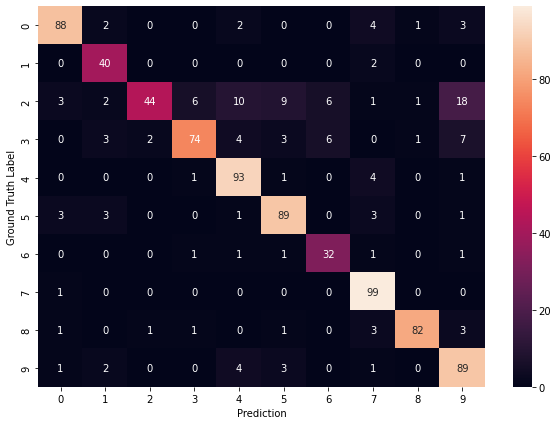

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

With respect to the previous analisys, the CNN performances accross all classes undergo a noticeable decrease.

In [ ]:
# Test noisy predictions decoded for feed-forward neural network.
test_pred_noisy_ffnn_decoded = tf.math.argmax(test_pred_noisy_ffnn, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_noisy_ffnn_decoded)

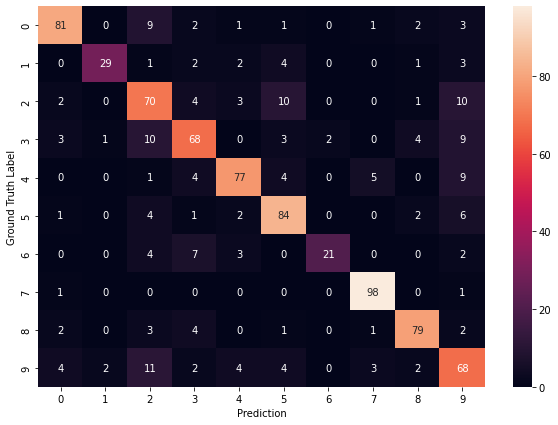

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

At the same time, the same analisys repeated for the feed-forward neural network model does not show a visible decrease. The two confusion matrices seems to be more similar than the CNN ones.

This result could be considered as a preview of the next section: we will see the noise sensitivity compared in the two supervised models.

### 7.2 Psychometric curves: noise injection

Let's consider the pychometric curves in this specific case for an increasing noise factor.

Before plotting the curves, we need a function that computes the accuracies of both the supervised models on the pertubed test set, given a specific noise factor.

In [ ]:
def compute_noisy_accuracy(model, x_test, y_test, noise_factor):
  '''
  Compute the noisy accuracy of the model on the test dataset, given a certain noise factor value.

  Inputs: model: a TensorFlow model.
          x_test: the test data.
          y_test: the true labels for the test data.
          noise_factor: Gaussian noise injection factor.

  Output: noisy_accuracy: noisy accuracy after the Gaussian noise injection.
  '''
  # Generate Gaussian noise to perturb the dataset.
  noisy_data = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

  # Use the model to predict the labels for the noisy examples.
  noisy_predictions = model.predict(noisy_data)
  noisy_accuracy = CategoricalAccuracy()
  noisy_accuracy.update_state(y_test, noisy_predictions)
  noisy_accuracy = noisy_accuracy.result().numpy()

  return noisy_accuracy

The following block of code is defining a range of noise factors to be tested and evaluating the accuracy of the two supervised models. First, it sets up a range of values for the noise factors by defining a start, end, and interval. It then creates a list of `noise_factors` by multiplying the range of values by the interval. Next, two lists are initialized to store the accuracy values of each model. Then, for each iteration, it computes the accuracy of both models by calling the above function. Finally, the accuracy for each model is appended to the corresponding list. After the loop is completed, these lists will contain the accuracy values of each model under all the different noise factors.

In this case, we are considering a wide range of noise factors values as can be seen in the following.

In [ ]:
# Define a range of noise_factor values to test.
start = 0.0
end = 10.0
interval = 0.1
noise_factors = [x * interval for x in range(int(start / interval), int(end / interval))]

# Initialize two lists to store the accuracy values.
accuracies_ffnn = []
accuracies_baseline_CNN = []

# Iterate over the noise_factors values.
for noise_factor in noise_factors:
  # Compute the accuracy for the current noise_factor value.
  accuracy_baseline_CNN = compute_noisy_accuracy(baseline_CNN, test, test_label, noise_factor)
  accuracy_ffnn = compute_noisy_accuracy(feed_forward_neural_network, test, test_label, noise_factor)
  # Append the each accuracy on the correlated list.
  accuracies_baseline_CNN.append(accuracy_baseline_CNN)
  accuracies_ffnn.append(accuracy_ffnn)

28/28 [==============================] - 0s 2ms/step


Let's plot the two psychometric curves.

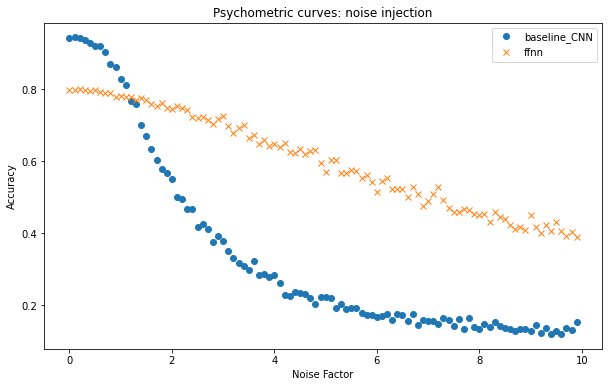

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(noise_factors, accuracies_baseline_CNN, 'o', noise_factors, accuracies_ffnn, 'x')
plt.legend(['baseline_CNN', 'ffnn'], loc='upper right')
plt.title('Psychometric curves: noise injection')
plt.xlabel('Noise Factor')
plt.ylabel('Accuracy')
plt.show()

As expected, with an increase in the noise factor, the supervised models' accuracies decrease. An interesting aspect to underline is related to the better performances obtained by the feed-forward neural network model with respect to the baseline CNN. As a consequence, the baseline CNN model seems to be more sensible to noise. It's important to underline that the noise factor considered is fairly high in terms of its absolute value.

## 8. Perturbing the models with adversarial attacks

At this point of the project, we are going to create adversial samples to see how the two supervised models perform on a perturbed dataset.

### 8.1 Fast Gradient Sign Method (FGSM)

In order to perform adversarial attacks, we are going to use the [FGSM](https://jaketae.github.io/study/fgsm/).

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction with respect to the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 

1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

where:
* $\tilde{x}$: output adversarial data;
* $x$: original input data;
* $y$: ground-truth label of the input data;
* $\epsilon$: small value that we multiply by the signed gradients to ensure that the perturbations are small enough that the human eye cannot detect them but large enough that they fool the neural network;
* $w$: model;
* $J$: loss function.

Let's define a function to implement FGSM attack. The following block of code first converts the input dataset and true labels into tensors. Then, it uses TensorFlow's `tf.GradientTape()` method to compute the gradients of the loss with respect to the input data. The tape is watched over the input tensor (`x_tensor`). The model is used to predict the labels for the input data and the loss is computed using the `loss_function` between the true labels and the predicted labels. Finally, the gradients of the loss with respect to the input data are computed using the `tape.gradient` method. The adversarial samples are then generated by adding the perturbation (`epsilon`) multiplied by the sign of the gradients to the input tensor. The function returns the adversarial samples (`x_adv`).

In [ ]:
def fgsm_attack(model, dataset, labels, loss_function, epsilon):
  '''
  Generate adversarial samples for the input datset using FGSM.

  Inputs: model: a TensorFlow model.
          x: input data.
          y: true labels.
          loss_function: computes the loss given the model's predictions and the true labels.
          epsilon: the size of the perturbation to add to the input.
          
  Output: x_adv: adversarial samples.
  '''
  # Transform input data and true labels into tensors.
  x_tensor = tf.convert_to_tensor(dataset)
  true_labels_tensor = tf.convert_to_tensor(labels)
  # Use tf.GradientTape() to compute the gradients.
  with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    # Predict labels with the model in input.
    labels_predicted = model(x_tensor)
    # Compute the loss between the true labels and the predicted labels.
    loss = loss_function(true_labels_tensor, labels_predicted)
    # Compute the gradients: loss w.r.t. the input data.
    gradients = tape.gradient(loss, x_tensor)
  x_adv = x_tensor + epsilon * tf.sign(gradients)
  return x_adv

Let's define an `epsilon` value to test the attack on both models.

In [ ]:
# Define an epsilon value to test.
epsilon = 0.2

Let's perform the FGSM attack on both models using the `epsilon` value defined above.

**Note**: in this case, we are going to generate adversarial samples all over the test set.

In [ ]:
# Baseline CNN: FGSM attack.

# Generate adversarial examples using FGSM.
perturbed_test_CNN = fgsm_attack(baseline_CNN, test, test_label, ce_loss, epsilon)

# Use the model to predict the labels for the adversarial examples.
test_pred_perturbed_CNN = baseline_CNN.predict(perturbed_test_CNN)
perturbed_accuracy_CNN = CategoricalAccuracy()
perturbed_accuracy_CNN.update_state(test_label, test_pred_perturbed_CNN)
perturbed_accuracy_CNN = perturbed_accuracy_CNN.result().numpy()

28/28 [==============================] - 0s 3ms/step


In [ ]:
perturbed_accuracy_CNN

0.7772675

As can be seen, the CNN accuracy is even worse than the one computed considering the noise injection. Additionally, we have an `epsilon` value which is lower than the noise factor specified previously.

In [ ]:
# Feed-forward neural network: FGSM attack.

# Generate adversarial examples using FGSM.
perturbed_test_ffnn = fgsm_attack(feed_forward_neural_network, test, test_label, ce_loss, epsilon)

# Use the model to predict the labels for the adversarial examples.
test_pred_perturbed_ffnn = feed_forward_neural_network.predict(perturbed_test_ffnn)
perturbed_accuracy_ffnn = CategoricalAccuracy()
perturbed_accuracy_ffnn.update_state(test_label, test_pred_perturbed_ffnn)
perturbed_accuracy_ffnn = perturbed_accuracy_ffnn.result().numpy()

28/28 [==============================] - 0s 2ms/step


In [ ]:
perturbed_accuracy_ffnn

0.70149255

The same considerations done previously applies with the feed-forward neural network. Once again, the model seems to be less sensible to adversarial attacks with respect to the CNN, as its accuracy does not decrease drastically.

### 8.2 Confusion matrices: FGSM attack

Let's plot the confusion matrices for both supervised models in order to better understand the performances after the adversarial attacks.

In [ ]:
# Test predictions perturbated decoded for baseline CNN.
test_pred_perturbed_CNN_decoded = tf.math.argmax(test_pred_perturbed_CNN, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_perturbed_CNN_decoded)

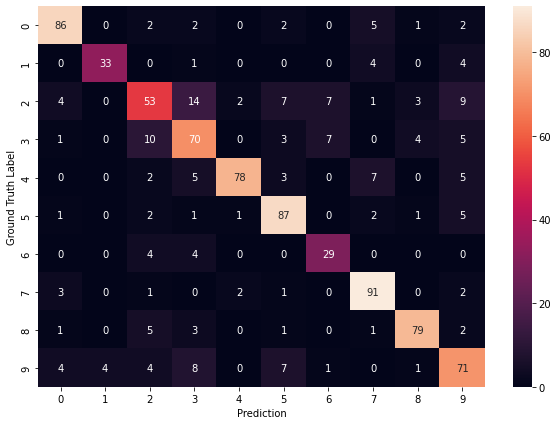

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

In [ ]:
# Test predictions perturbed decoded for feed-forward neural network.
test_pred_perturbed_ffnn_decoded = tf.math.argmax(test_pred_perturbed_ffnn, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_perturbed_ffnn_decoded)

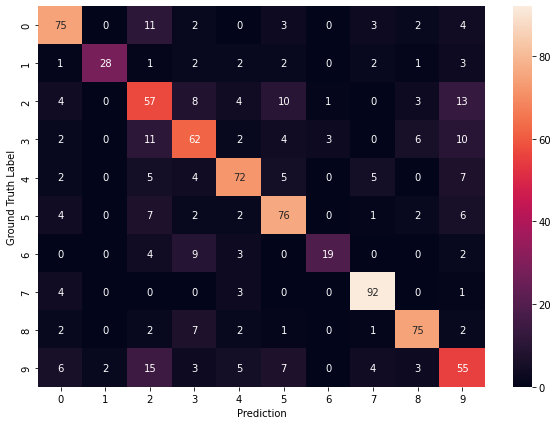

In [ ]:
# Plot the confusion matrix.
plot_confusion_matrix(confusion_matrix)

As can be seen from the confusion matrices above, the difference between the noise injection confusion matrices is fairly high, even if we are considering a low `epsilon` value.

### 8.3 Psychometric curves: FGSM attack

Now, we want to understand how the models perform with respect to a variation of `epsilon` coefficients. We would consider the same approach used for plotting the psychometric curves in noise injection case.

Let's define a function to compute the perturbed accuracy of a model considering FSGM. Firstly, we create the adversarial samples for specific data given in input. Then, we compute the accuracy of the model over the created samples.

In [ ]:
def compute_perturbed_accuracy(model, x_test, y_test, loss_function, epsilon):
  '''
  Compute the perturbed accuracy of the model on the test dataset, given a certain epsilon value (after a FSGM attack).
  
  Inputs: model: a TensorFlow model.
          x_test: the test data.
          y_test: the true labels for the test data.
          epsilon: the size of the adversarial perturbation.

  Output: perturbed_accuracy: perturbed accuracy after the FSGM attack.
  '''
  # Generate adversarial examples using FGSM.
  x_adv = fgsm_attack(model, x_test, y_test, loss_function, epsilon)

  # Use the model to predict the labels for the adversarial examples.
  perturbed_predictions = model.predict(x_adv)
  perturbed_accuracy = CategoricalAccuracy()
  perturbed_accuracy.update_state(y_test, perturbed_predictions)
  perturbed_accuracy = perturbed_accuracy.result().numpy()

  return perturbed_accuracy

The following block of code uses the same ideas introduced in the noise injection section to plot the psychometric curves on a range of increasing `epsilon` values. The main difference is related to the smallest range we are defining in the following.

In [ ]:
# Define a range of epsilon values to test.
start = 0.0
end = 2.0
interval = 0.05
epsilons = [x * interval for x in range(int(start / interval), int(end / interval))]

# Initialize two lists to store the accuracy values.
accuracies_ffnn = []
accuracies_baseline_CNN = []

# Iterate over the epsilon values.
for epsilon in epsilons:
  # Compute the accuracy for the current epsilon value.
  accuracy_ffnn = compute_perturbed_accuracy(feed_forward_neural_network, test, test_label, ce_loss, epsilon)
  accuracy_baseline_CNN = compute_perturbed_accuracy(baseline_CNN, test, test_label, ce_loss, epsilon)
  # Append the each accuracy on the correlated list.
  accuracies_ffnn.append(accuracy_ffnn)
  accuracies_baseline_CNN.append(accuracy_baseline_CNN)

28/28 [==============================] - 0s 3ms/step


Let's plot the psychometric curves based on what we computed above.

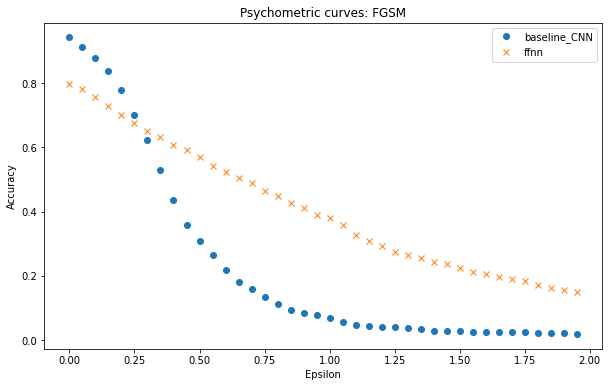

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies_baseline_CNN, 'o', epsilons, accuracies_ffnn, 'x')
plt.legend(['baseline_CNN', 'ffnn'], loc='upper right')
plt.title('Psychometric curves: FGSM')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

As expected, the accuracies of both models decrease with respect to an increasing value of epsilon. The most interesting aspect of the plot is that the CNN's curve decreases more rapidly than the feed-forward neural network one. This observation means that the baseline CNN model, that we previously defined, is more sensible to noise than the feed-forward neural network model.

As we said previously, the main distinction between the noise injection psychometric curves and those ones is related to the difference of absolute values of `epsilon` and `noise_factor`. In fact, with lower epsilon values, we obtain a huge decrease in terms of performances with respect to the same values for noise injection.

## 9. Exploring unsupervised learning models: Convolutional Variational Autoencoder (CVAE)

In this last part of the project, we are going to explore an unsupervised learning model: Convolutional Variational Autoencoder (CVAE).

In general, an autoencoder has an encoder and a decoder where the encoder maps the input data to a latent space, and the decoder maps back the latent representations to the original input data.

A Convolutional Variational Autoencoder (CVAE) is an extension of the traditional Variational Autoencoder (VAE), which is a probabilistic model that learns a compact representation of the input data by encoding it into a latent space and then decoding it back to the original space.

The main differences between a Convolutional Autoencoder (CAE) and a Convolutional Variational Autoencoder (CVAE) are as follows:

* **latent space**: the main difference between CAE and CVAE is the way they learn the compact representation of the input data. A CAE learns a deterministic encoding and decoding mapping, while a CVAE learns a probabilistic encoding and decoding mapping. In other words, a CAE maps the input data to a fixed representation in the latent space, while a CVAE maps the input data to a probabilistic distribution in the latent space;

* **loss function**: the loss function used in CAE is the reconstruction loss, which measures the difference between the input data and the reconstructed data. In contrast, the loss function used in CVAE is a combination of reconstruction loss and a regularization term that encourages the latent space to follow a Gaussian distribution;

* **sampling**: in CAE, the encoding and decoding functions are deterministic, so there is no need for sampling. In contrast, in CVAE, the encoding function maps the input data to a distribution in the latent space, and the decoding function maps a sample from this distribution back to the original space.

* **generative model**: a CVAE can be used as a generative model, meaning that it can generate new samples from the learned distribution in the latent space. This is not possible with a CAE, as it only learns a deterministic encoding and decoding mapping.

In summary, a CVAE is a more powerful and flexible model compared to a CAE, as it can handle probabilistic representations of the input data, has a regularization term that encourages the learned representation to be meaningful, and can be used as a generative model.






### 9.1 CVAE: reparameterization trick


The reparameterization trick is a method for obtaining random samples from a differentiable distribution, such as a Gaussian distribution, in a way that allows the gradients to be backpropagated through the random samples during training.

The following function takes in `args`, which are the mean and log variance of the latent space, and returns a random sample from the latent space using the reparameterization trick. It first unpacks `z_mean` and `z_log_var` from `args`, which represent the mean and log variance of the latent space. Then it calculates the batch size and dimensionality of the latent space from the shapes of `z_mean` and `z_log_var`. Next, it generates random normal noise with shape (batch, dim) using the `K.random_normal` function from the Keras library. The generated noise has a mean of 0 and a standard deviation of 1. Finally, the function returns a sample from the latent space by adding the random normal noise to the `z_mean`, scaled by the exponential of the half of `z_log_var`. The purpose of this scaling is to ensure that the variance of the latent space is equal to the exponential of `z_log_var`.

In [ ]:
def sampling(args):
  # Unpacking the mean and log variance of the latent space from the input args.
  z_mean, z_log_var = args
  # Getting the batch size from the shape of z_mean.
  batch = K.shape(z_mean)[0]
  # Getting the dimensionality of the latent space from the shape of z_mean.
  dim = K.int_shape(z_mean)[1]
  # By default, random_normal has mean=0 and std=1.0;
  # Generating random normal noise with shape (batch, dim).
  epsilon = K.random_normal(shape=(batch, dim))
  # Sampling from the latent space using the reparameterization trick.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

The following code lines define the parameters for the input of a Convolutional Variational Autoencoder (CVAE). The CVAE takes in a tensor of shape (`batch_size`, `n_features`, `channels`) as input, where `batch_size` is the number of samples in a batch, `n_features` is the number of features in each sample, and `channels` is the number of channels in each feature.

In [ ]:
# Defining parameters of the CVAE input.
n_features = training.shape[1]
channels = training.shape[2]

Now, we are going to set up the latent dimensionality of the Convolutional Variational Autoencoder (CVAE). The latent dimensionality, also known as the number of latent variables or latent features, determines the size of the compact representation of the input data in the latent space.

In [ ]:
# Defining the latent dimensions.
latent_dim = 2

### 9.2 CVAE: encoder model


The encoder network is responsible for encoding the input data into the latent space, where it can be compactly represented by a small number of latent variables.

The following code starts by defining an input tensor with shape (`n_features`, `channels`) using the Input layer. This tensor represents the input data to the encoder network.

Next, the code applies a series of Conv1D, Flatten, and Dense layers to the input tensor to construct the encoder network. The Conv1D layers perform 1D convolutions on the input data to extract features, the Flatten layer flattens the feature maps into a vector, and the Dense layers perform fully connected operations on the flattened feature vector to produce the final encoding.

The final layer of the encoder network produces a tensor of shape (`batch_size`, `2 * latent_dim`), where `batch_size` is the number of samples in a batch and `latent_dim` is the number of latent variables. This tensor represents the mean and log variance of the latent space.

The tensor is then split into two parts using the `tf.split` function, with one part representing the mean and the other representing the log variance. These two parts are used to sample a point in the latent space using the sampling function, which is applied to the split tensor using the Lambda layer. The resulting tensor `z` represents a sample from the latent space and has shape (`batch_size`, `latent_dim`).

In [ ]:
# Defining the encoder model.

# Input layer with the shape of (n_features, channels).
input = Input(shape=(n_features, channels), name='encoder_input')
# First 1D convolutional layer with 64 filters of size 3 and stride 2, using ReLU activation function.
x = Conv1D(64, kernel_size=3, strides=2, activation='relu', name='encoder_conv_1')(input)
# Second 1D convolutional layer with 128 filters of size 3 and stride 1, using ReLU activation function.
x = Conv1D(128, kernel_size=3, strides=1, activation='relu', name='encoder_conv_2')(x)
# Flatten layer to flatten the output from the previous layer.
x = Flatten(name='encoder_flatten')(x)
# First dense layer with 100 neurons using ReLU activation function.
x = Dense(100, activation='relu', name='encoder_dense_1')(x)
# Second dense layer with 10 neurons using ReLU activation function.
x = Dense(10, activation='relu', name='encoder_dense_2')(x)
# Third dense layer with 2 * latent_dim neurons.
x = Dense(2 * latent_dim, name='encoder_dense_3')(x)
# Split layer to split the output from the previous layer into two equal parts.
x_split = tf.split(x, num_or_size_splits=2, axis=1, name='split')
# Lambda layer to apply the sampling function to the previous split layer, with the shape of (latent_dim,).
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(x_split)

In [ ]:
# Defining the encoder model using the intermediate outputs from the previous layers.
encoder = Model(input, [x_split[0], x_split[1], z], name='encoder')
# Summarizing the encoder model to view the number of parameters and shapes of the intermediate outputs.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 1)]     0           []                               
                                                                                                  
 encoder_conv_1 (Conv1D)        (None, 49, 64)       256         ['encoder_input[0][0]']          
                                                                                                  
 encoder_conv_2 (Conv1D)        (None, 47, 128)      24704       ['encoder_conv_1[0][0]']         
                                                                                                  
 encoder_flatten (Flatten)      (None, 6016)         0           ['encoder_conv_2[0][0]']         
                                                                                            

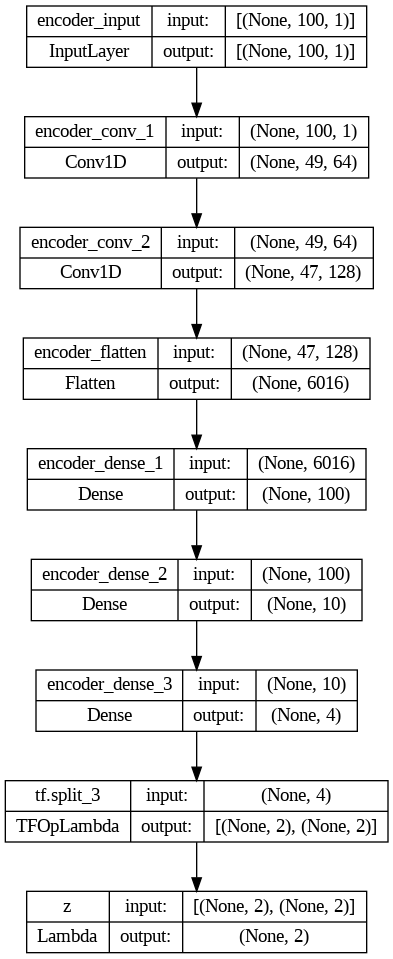

In [ ]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

### 9.3 CVAE: decoder model

The following code defines the decoder model of the Convolutional Variational Autoencoder (CVAE) model.

The decoder takes a latent space vector as input and transforms it into a reconstructed input. The input to the decoder is created using the Input layer and has the shape (`latent_dim`,). The input is then passed through a series of dense layers, with each layer transforming the input and learning a new representation.

The output of the dense layers is then reshaped using the Reshape layer into a tensor with shape (100, 1). This tensor is then passed through a series of 1D transposed convolutional layers, each with different number of filters, kernel sizes and strides, and ReLU activation functions. These layers learn to reverse the operations of the encoder and return the reconstructed input.

Finally, it outputs the reconstructed input with shape (`n_features`, `channels`).

In [ ]:
# Defining the decoder model.

# Create an input layer with shape (latent_dim,).
input_gen = Input(shape=(latent_dim,), name='decoder_input')
# Dense layer with 10 neurons, activation function as ReLU.
y = Dense(10, activation='relu', name='decoder_dense_1')(input_gen)
# Another Dense layer with 100 neurons, activation function as ReLU.
y = Dense(100, activation='relu', name='decoder_dense_2')(y)
# Reshape the output to (100, 1).
y = Reshape((100, 1), name='decoder_reshape')(y)
# 1D Convolutional Transpose layer with 128 filters.
y = Conv1DTranspose(128, kernel_size=3, strides=1, padding='same', activation='relu', name='decoder_conv_T_1')(y)
# 1D Convolutional Transpose layer with 64 filters.
y = Conv1DTranspose(64, kernel_size=3, strides=1, padding='same', activation='relu', name='decoder_conv_T_2')(y)
# Final 1D Convolutional Transpose layer with 1 filter.
y = Conv1DTranspose(1, kernel_size=3, strides=1, padding='same', name='decoder_conv_T_3')(y)

In [ ]:
# Defining the decoder model which takes as input the encoder output.
decoder = Model(input_gen, y, name='decoder')
# Display a summary of the decoder model.
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_dense_1 (Dense)     (None, 10)                30        
                                                                 
 decoder_dense_2 (Dense)     (None, 100)               1100      
                                                                 
 decoder_reshape (Reshape)   (None, 100, 1)            0         
                                                                 
 decoder_conv_T_1 (Conv1DTra  (None, 100, 128)         512       
 nspose)                                                         
                                                                 
 decoder_conv_T_2 (Conv1DTra  (None, 100, 64)          24640     
 nspose)                                                   

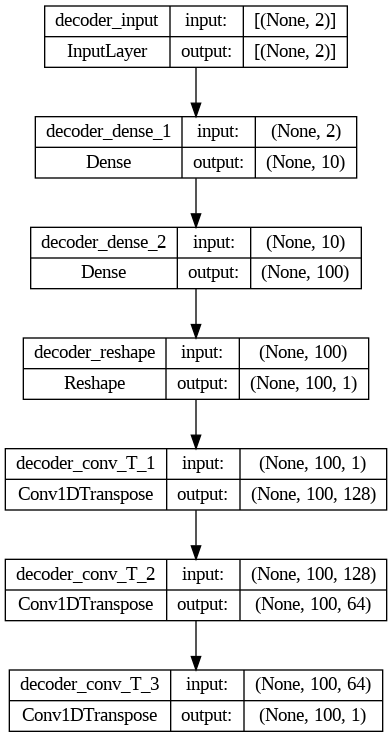

In [ ]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

### 9.4 Convolutional Variational Autoencoder model

The CVAE is created by passing the input through the encoder model and then the output of the encoder model is passed as input to the decoder model. The final CVAE model is defined by connecting the input to the output of the decoder model, with the encoder model in between.

In [ ]:
# Defining CVAE model.

# CVAE: passing the input data through the encoder model and then passing the encoder's output to the decoder model.
output = decoder(encoder(input)[2])
# The resulting output from the decoder is the final output of the CVAE.
conv_variational_autoencoder = Model(input, output, name='conv_variational_autoencoder')
# Print a summary of the CVAE model.
conv_variational_autoencoder.summary()

Model: "conv_variational_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 100, 1)]          0         
                                                                 
 encoder (Functional)        [(None, 2),               627714    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 100, 1)            26475     
                                                                 
Total params: 654,189
Trainable params: 654,189
Non-trainable params: 0
_________________________________________________________________


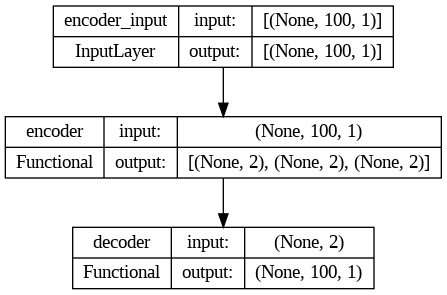

In [ ]:
plot_model(conv_variational_autoencoder, show_shapes=True, show_layer_names=True)

### 9.5 CVAE: defining the reconstruction loss

The following code block is defining the loss for the convolutional variational autoencoder (CVAE) model. The loss is calculated as the **reconstruction loss**.

The latter is computed using mean squared error (MSE) between the input and the output of the decoder. To calculate the MSE, the input and output are flattened and passed as arguments to the MSE function.

For our purposes, we just need to define this type of loss since we are going to test the CVAE on denoising the test data and generation of new samples.

In [ ]:
# Computing the reconstruction loss: MSE.
reconstruction_loss = mse(Flatten()(input), Flatten()(output))

Now, let's add the reconstruction loss to the CVAE model.

In [ ]:
# Add the reconstruction loss to the convolutional variational autoencoder model.
conv_variational_autoencoder.add_loss(reconstruction_loss)

In the following, we will define the hyperparameters for the training process. An increased number of `epochs` was set with respect to the supervised model. This was done in order to decrease the loss associated to the unsupervised model. With regard to the learning rate and the `batch_size`, we will use the same approach for the supervised models. As optimizer, we will consider `Adam` as in the previous sections.

In [ ]:
batch_size = 128 # Batch size: the standard batch sizes are 64, 128, 256. We want to start from 128.
epochs = 150 # We can set the number of epochs to train as 150 for now.
l_r = 1.0e-03 # Learning rate: the learning rate is usually logarithmically changed between 1e-07 to 0.1. 0.001 seems to be a good place to start.

# We need to set the optimizer for the CVAE.
optimizer = Adam(learning_rate=l_r) # Adam is computational efficient and requires little memory.

In [ ]:
# Compile the CVAE model.
conv_variational_autoencoder.compile(optimizer=optimizer)

In [ ]:
# Plot the CVAE model summary.
conv_variational_autoencoder.summary()

Model: "conv_variational_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          627714      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 100, 1)       26475       ['encoder[0][2]']                
                                                                       

We are going to set up only the `EarlyStopping` callback in order to control the training process. In particular, we want to see if the training could be stopped earlier than the number of `epochs` defined.

In [ ]:
# This is a callback that stops the training if the validation loss starts to increase.
early_stopping = EarlyStopping(monitor='val_loss', verbose=True, patience=12,
                               min_delta=0.0001, restore_best_weights=True)

# Commences training of the model.
with tf.device('/device:GPU:0'):
  history_cvae = conv_variational_autoencoder.fit(x=training, y=train_label,
                                                  batch_size=batch_size,
                                                  epochs=epochs, shuffle=True,
                                                  validation_data=(validation, valid_label),
                                                  callbacks=[early_stopping])

# We want a place to store the training and validation loss.
training_loss = history_cvae.history['loss']
valid_loss = history_cvae.history['val_loss']

Epoch 1/150
55/55 [==============================] - 2s 14ms/step - loss: 1039.6699 - val_loss: 264.6977
Epoch 2/150
55/55 [==============================] - 0s 8ms/step - loss: 126.1495 - val_loss: 101.7615
Epoch 3/150
55/55 [==============================] - 0s 8ms/step - loss: 98.3978 - val_loss: 98.3837
Epoch 4/150
55/55 [==============================] - 0s 8ms/step - loss: 97.1368 - val_loss: 96.8288
Epoch 5/150
55/55 [==============================] - 0s 8ms/step - loss: 96.5091 - val_loss: 96.6729
Epoch 6/150
55/55 [==============================] - 1s 11ms/step - loss: 96.3524 - val_loss: 96.4104
Epoch 7/150
55/55 [==============================] - 1s 11ms/step - loss: 95.6040 - val_loss: 95.3053
Epoch 8/150
55/55 [==============================] - 1s 10ms/step - loss: 90.3905 - val_loss: 77.4250
Epoch 9/150
55/55 [==============================] - 1s 11ms/step - loss: 54.9167 - val_loss: 45.7615
Epoch 10/150
55/55 [==============================] - 1s 11ms/step - loss: 43.600

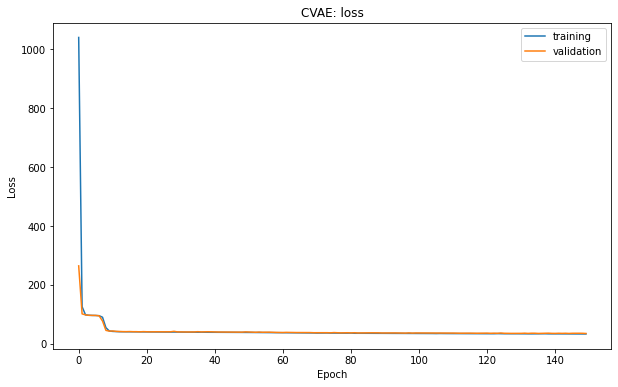

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.legend()
plt.title('CVAE: loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

As we can see from the figure above, training and validation losses decrease monototically as the epochs increase. However, in terms of absolute value, they are fairly high.

**Note**: unfortunately, even considering a different arrangement of the layers that construct the encoder and the decoder, we get comparable performance with this one above. Therefore, in this project, we report the best result obtained with the best hyperparameters set.

### 9.6 CVAE: visualizing feature maps

As in the previous sections, we will now plot the feature maps associated to a training sample for the encoder and the decoder model. Once again, this type of representation was chosen in order to be able to visualize the whole process carried out by the model with a given input.

Let's define the layers of interest for the encoder model.

In [ ]:
layer_names_cvae_encoder = ['encoder_conv_1', 'encoder_conv_2', 'encoder_dense_1', 'encoder_dense_2']

encoder_conv_1 (1, 49, 64) 


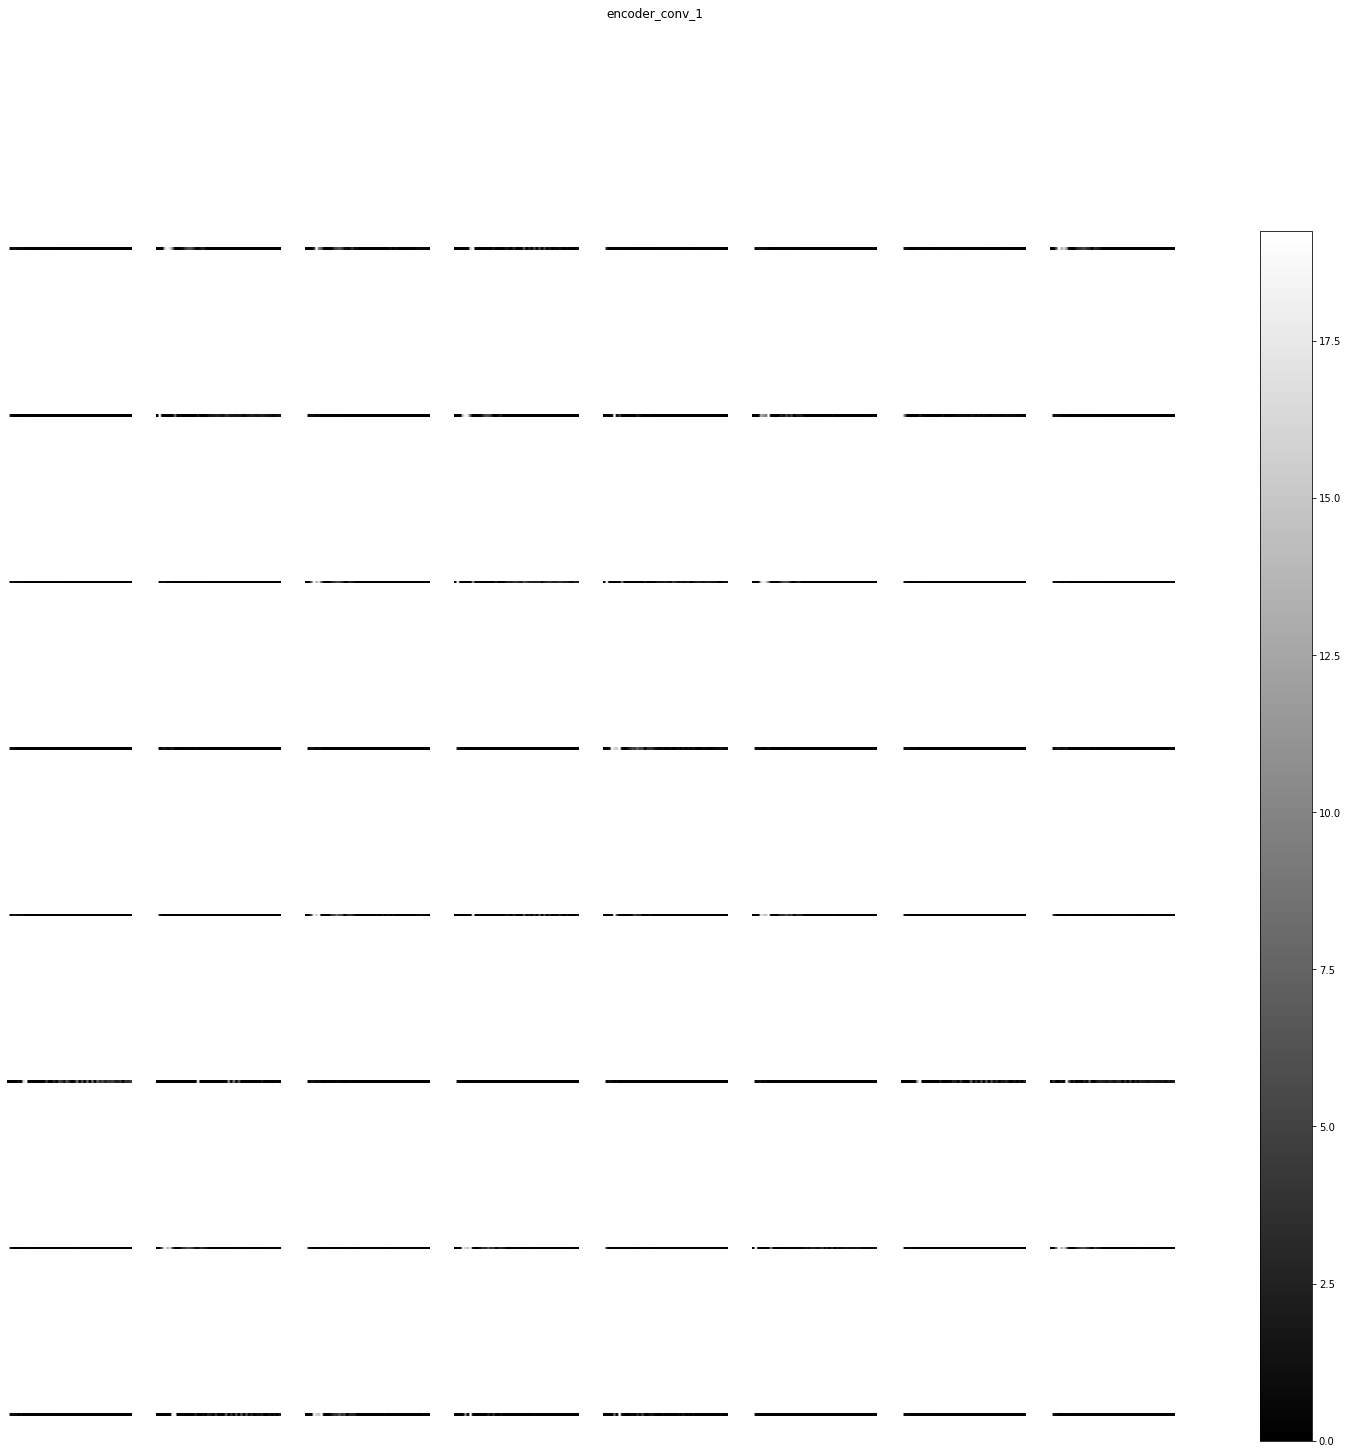

encoder_conv_2 (1, 47, 128) 


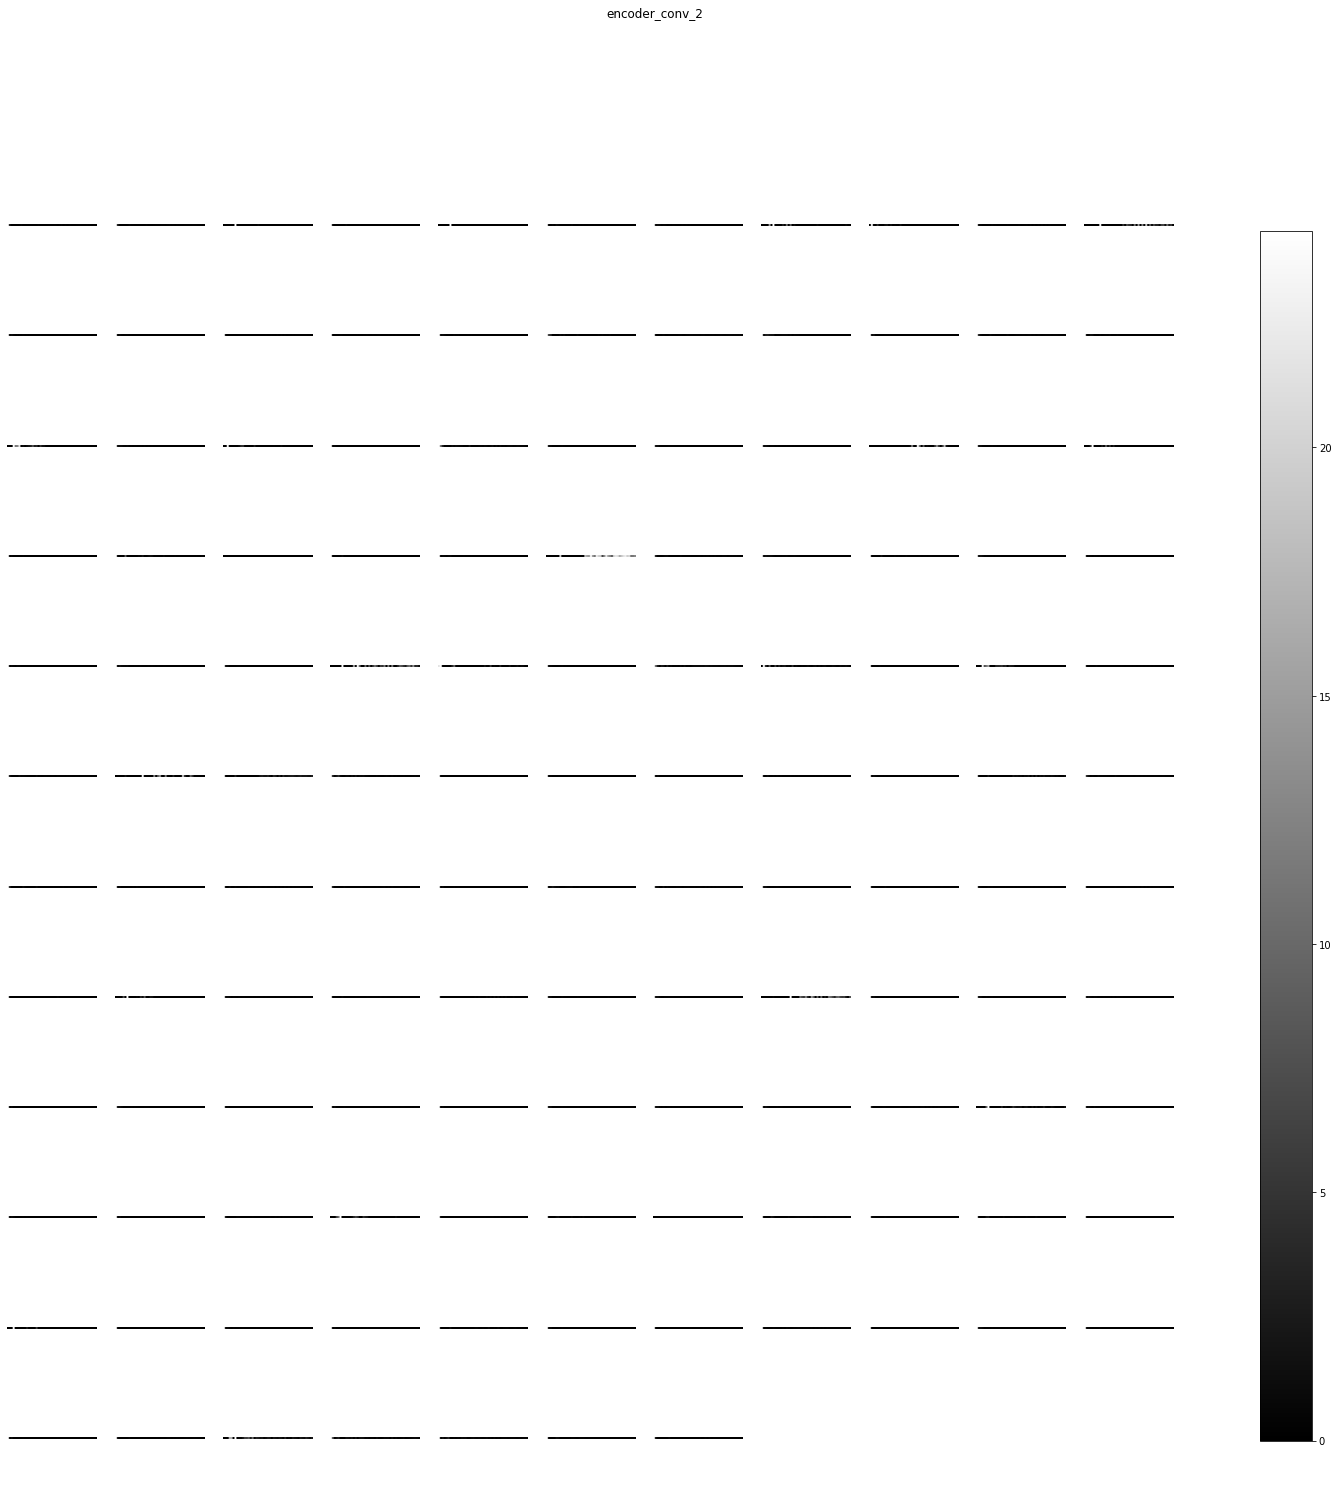

encoder_dense_1 (1, 100) 


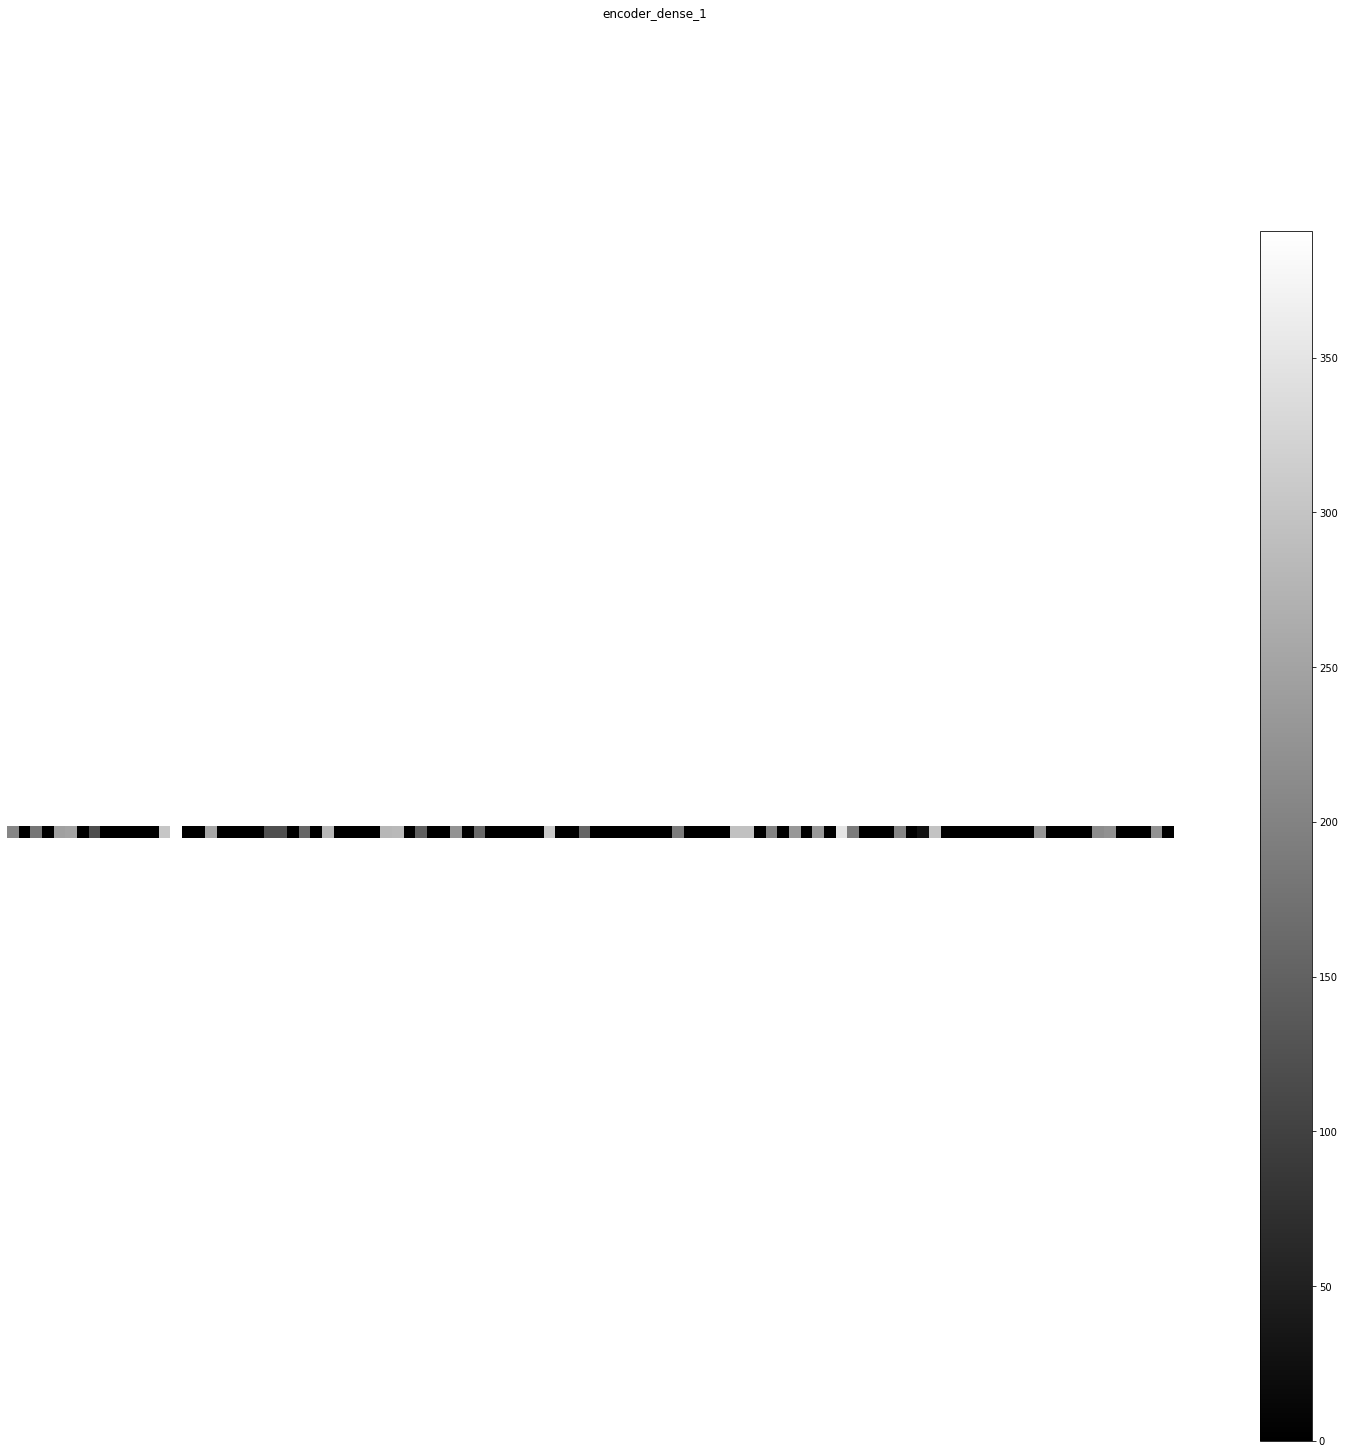

encoder_dense_2 (1, 10) 


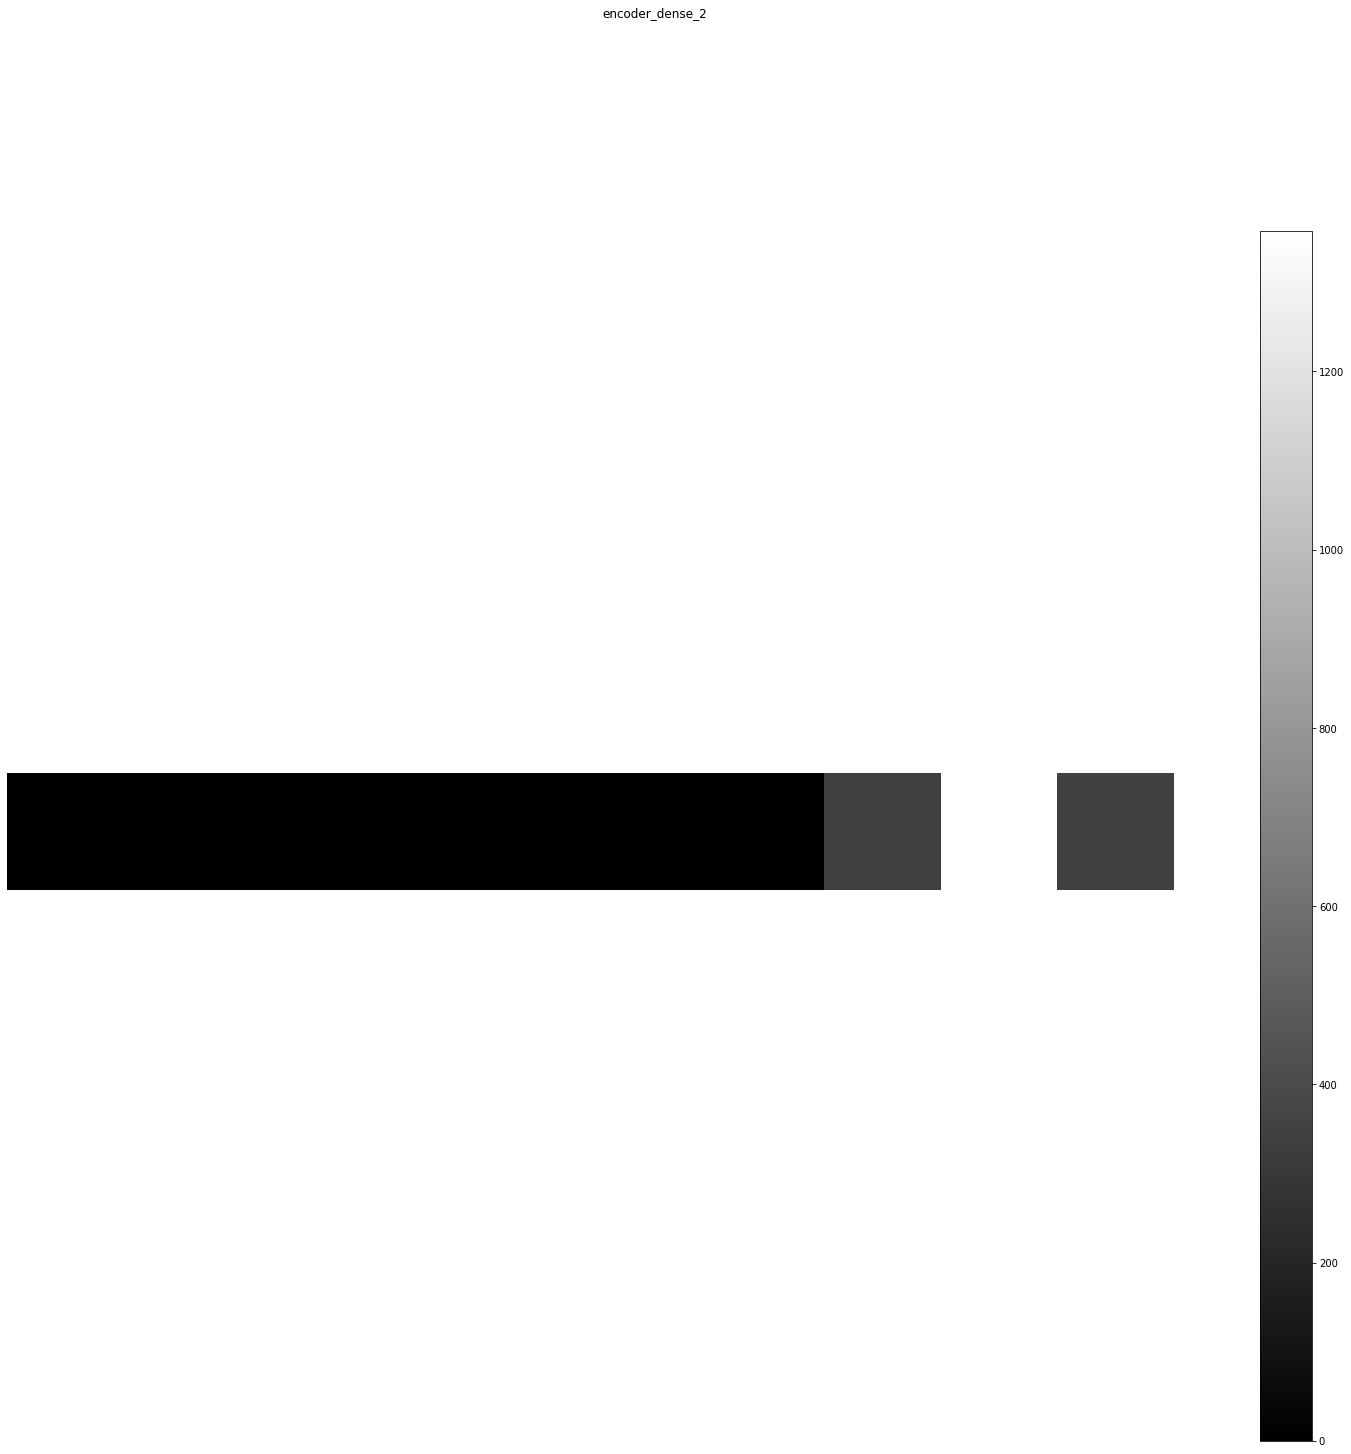

In [ ]:
# Get activations of the selected layers in the encoder model.
activations_cvae_encoder = get_activations(encoder, keract_inputs, layer_names=layer_names_cvae_encoder)

# Display the activations of the selected layers in the encoder model.
display_activations(activations_cvae_encoder, cmap="gray", save=False)

As can be seen from the figure above, the processing of the considered input follows exactly the pattern defined by the encoder.

Let's reapeat the same procedure for the decoder model.

In [ ]:
layer_names_cvae_decoder = ['decoder_dense_1', 'decoder_dense_2', 'decoder_conv_T_1', 'decoder_conv_T_2', 'decoder_conv_T_3']

In this case, we need to consider the decoder input as the encoder output.

decoder_dense_1 (1, 10) 


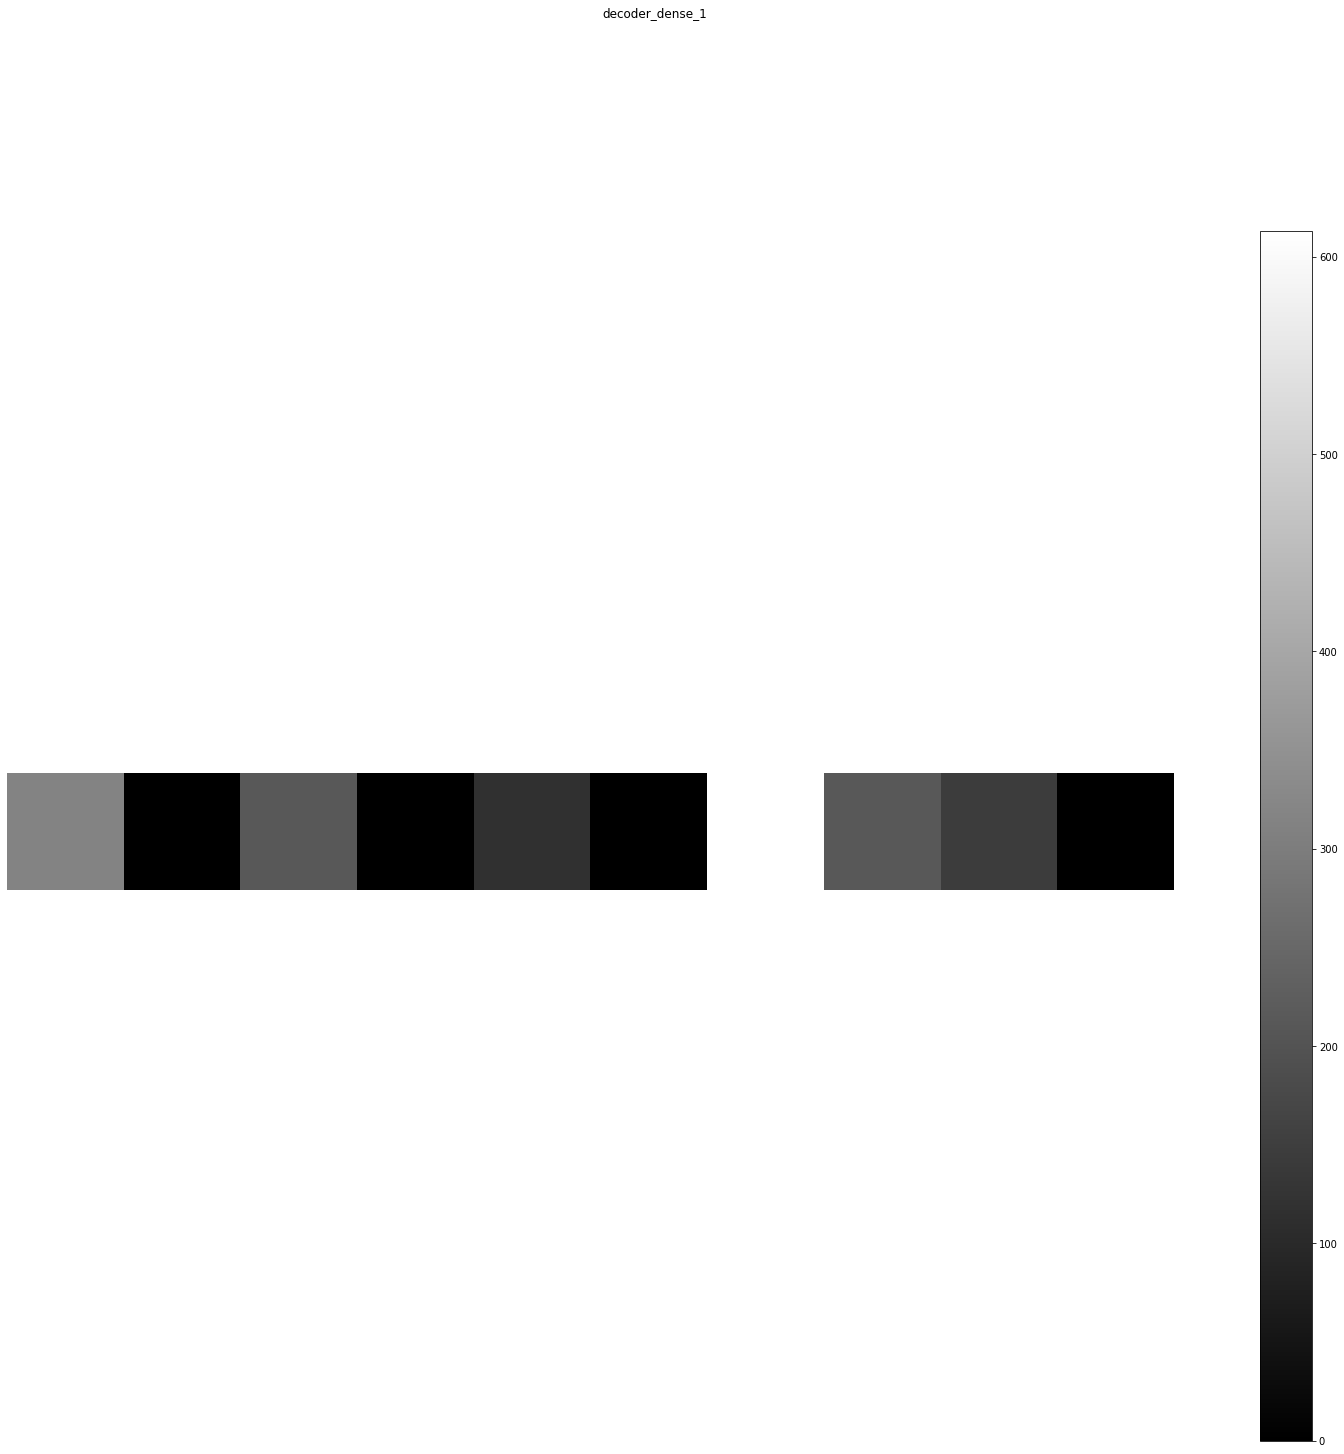

decoder_dense_2 (1, 100) 


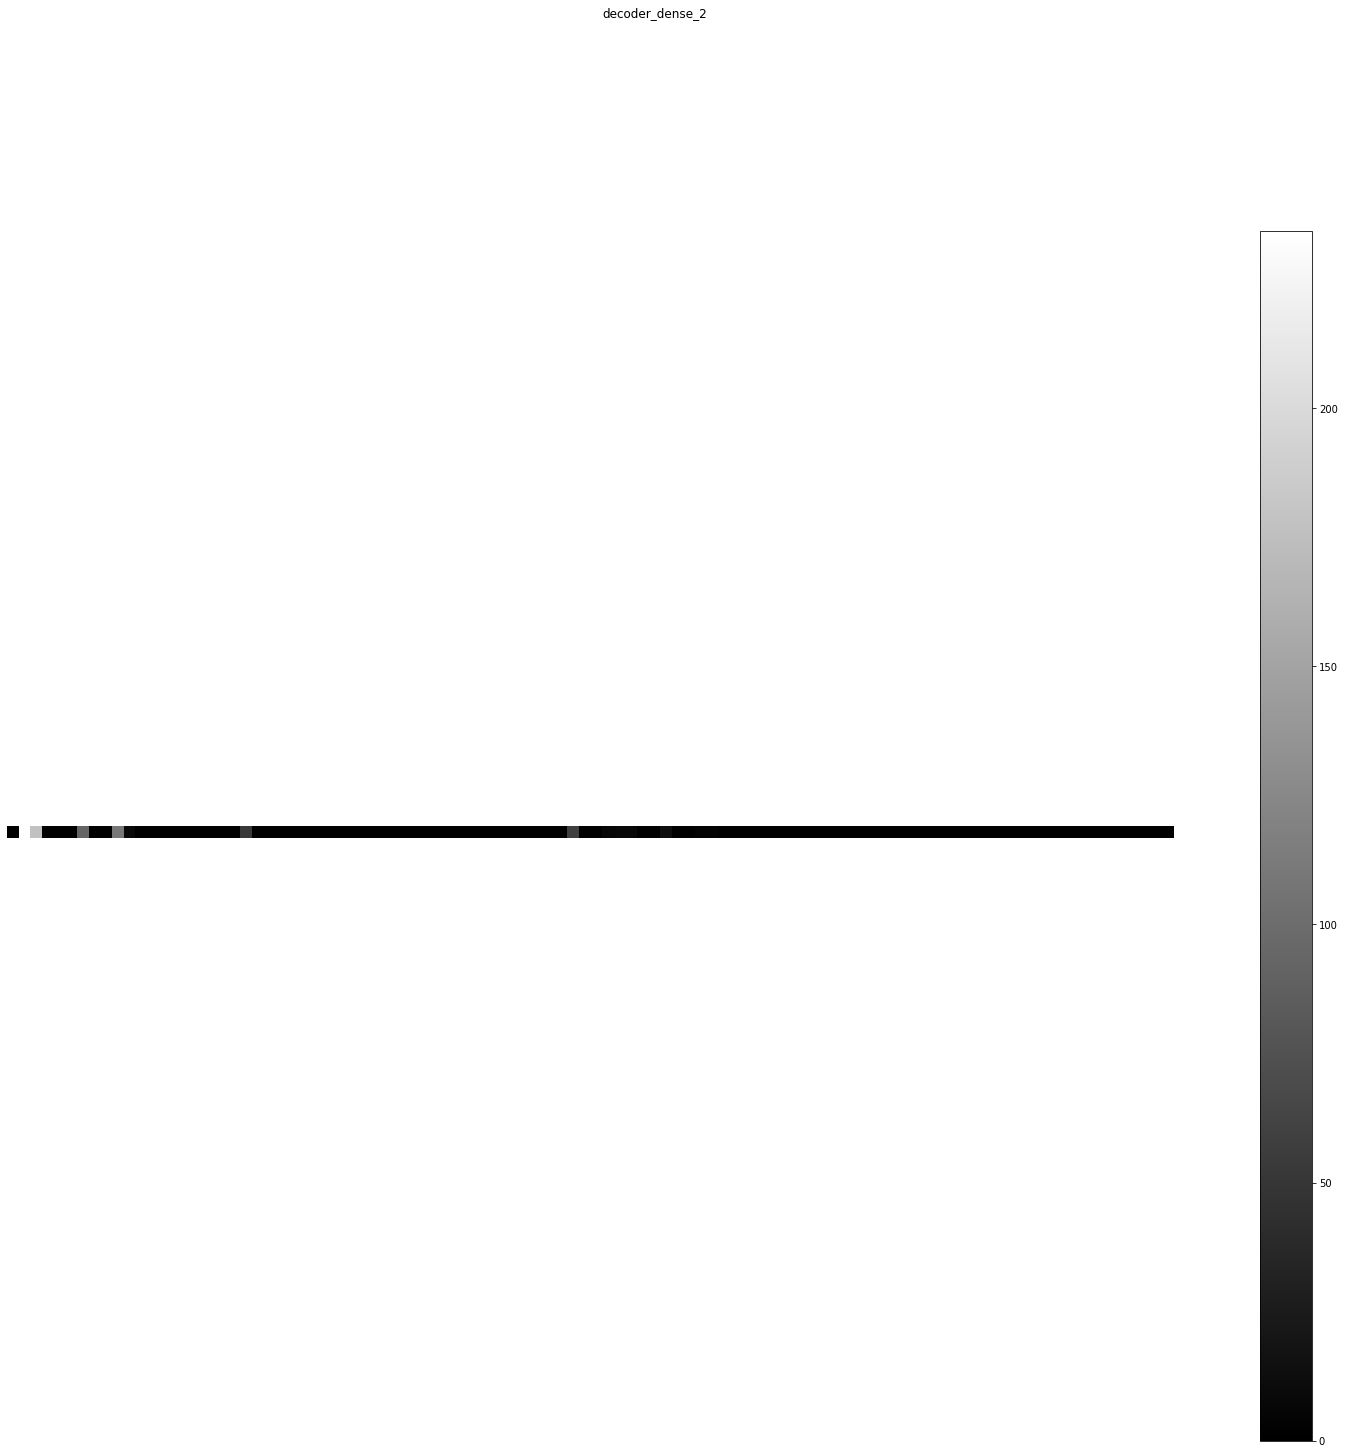

decoder_conv_T_1 (1, 100, 128) 


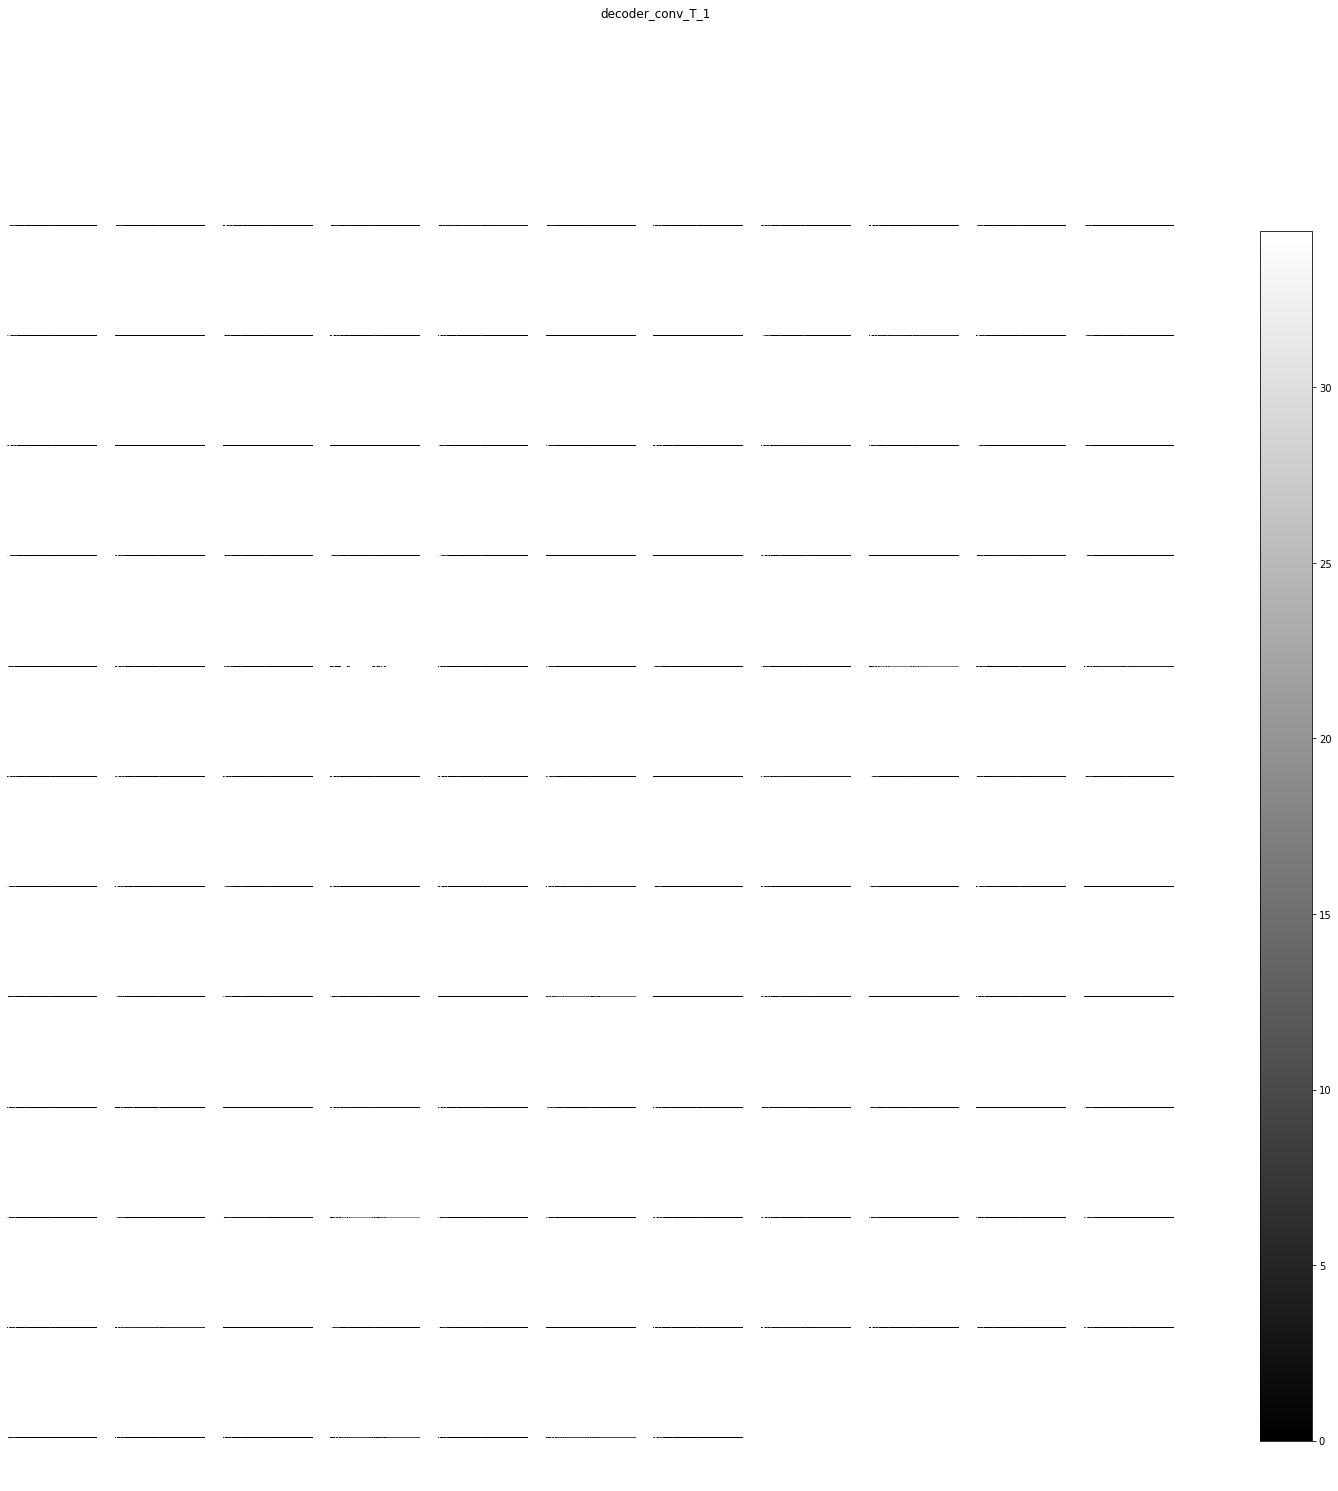

decoder_conv_T_2 (1, 100, 64) 


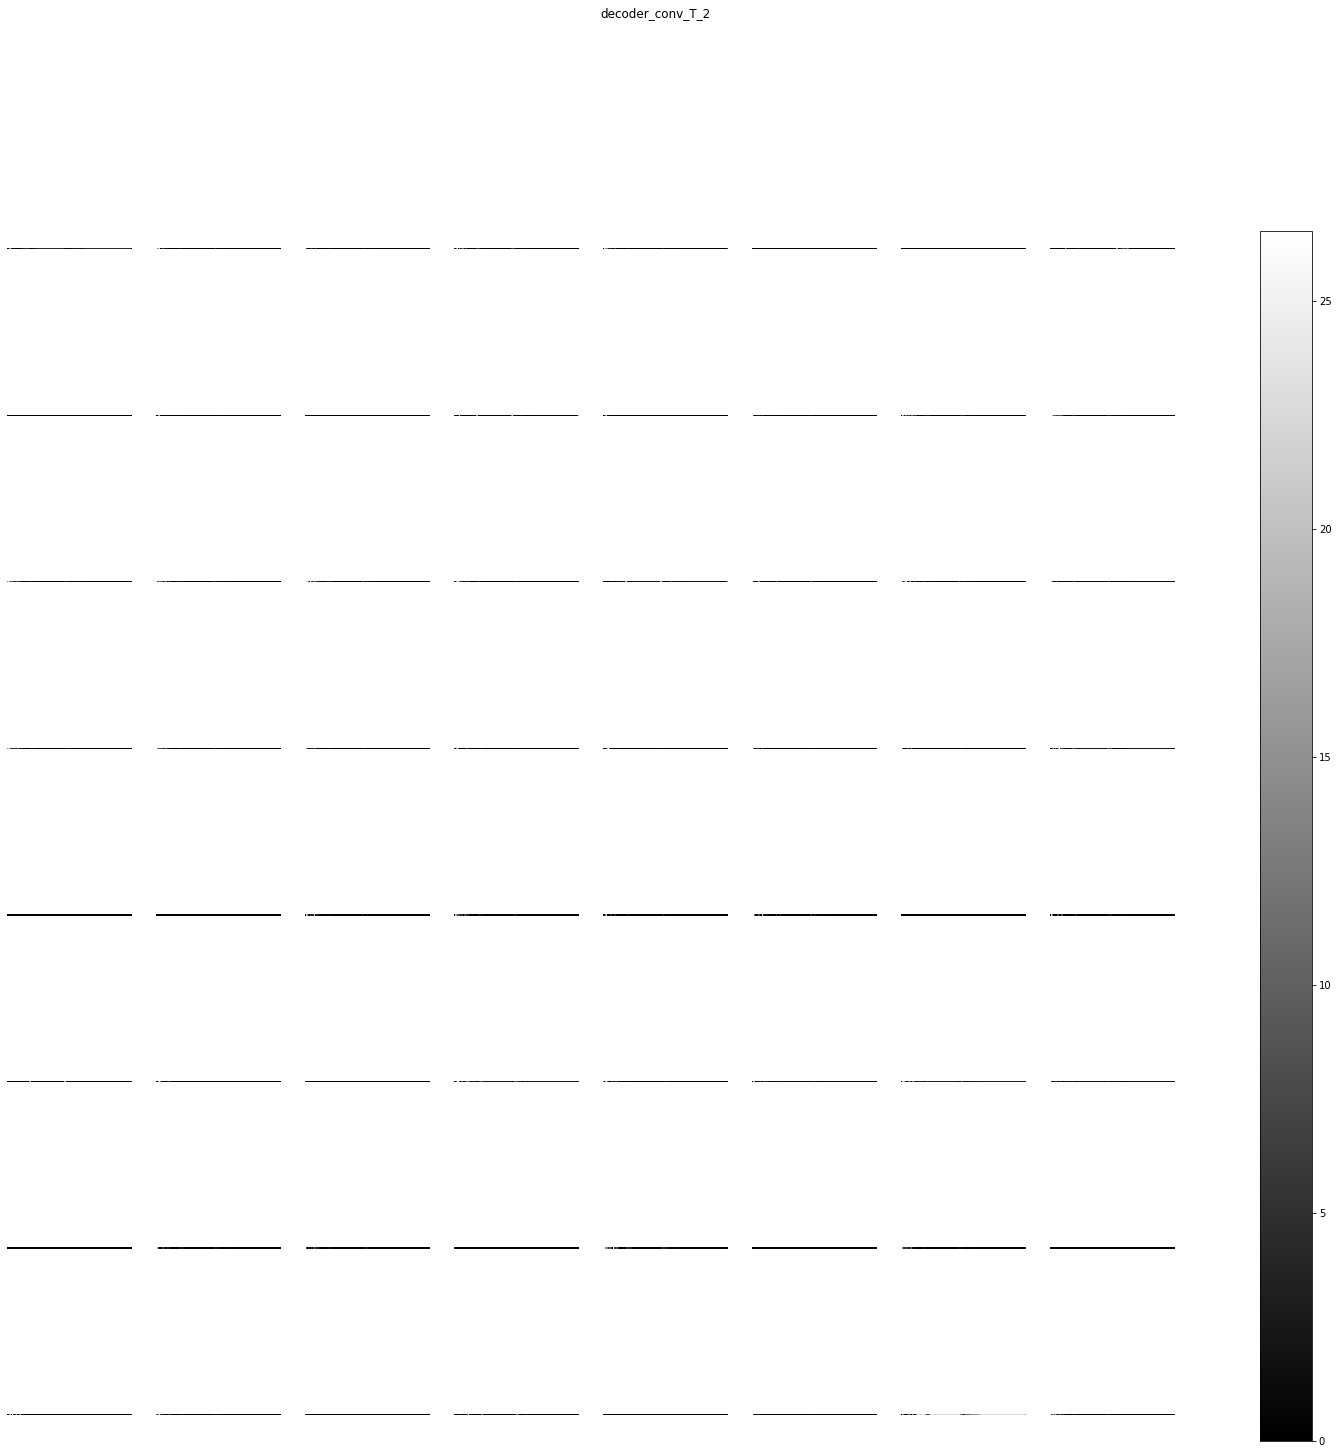

decoder_conv_T_3 (1, 100, 1) 


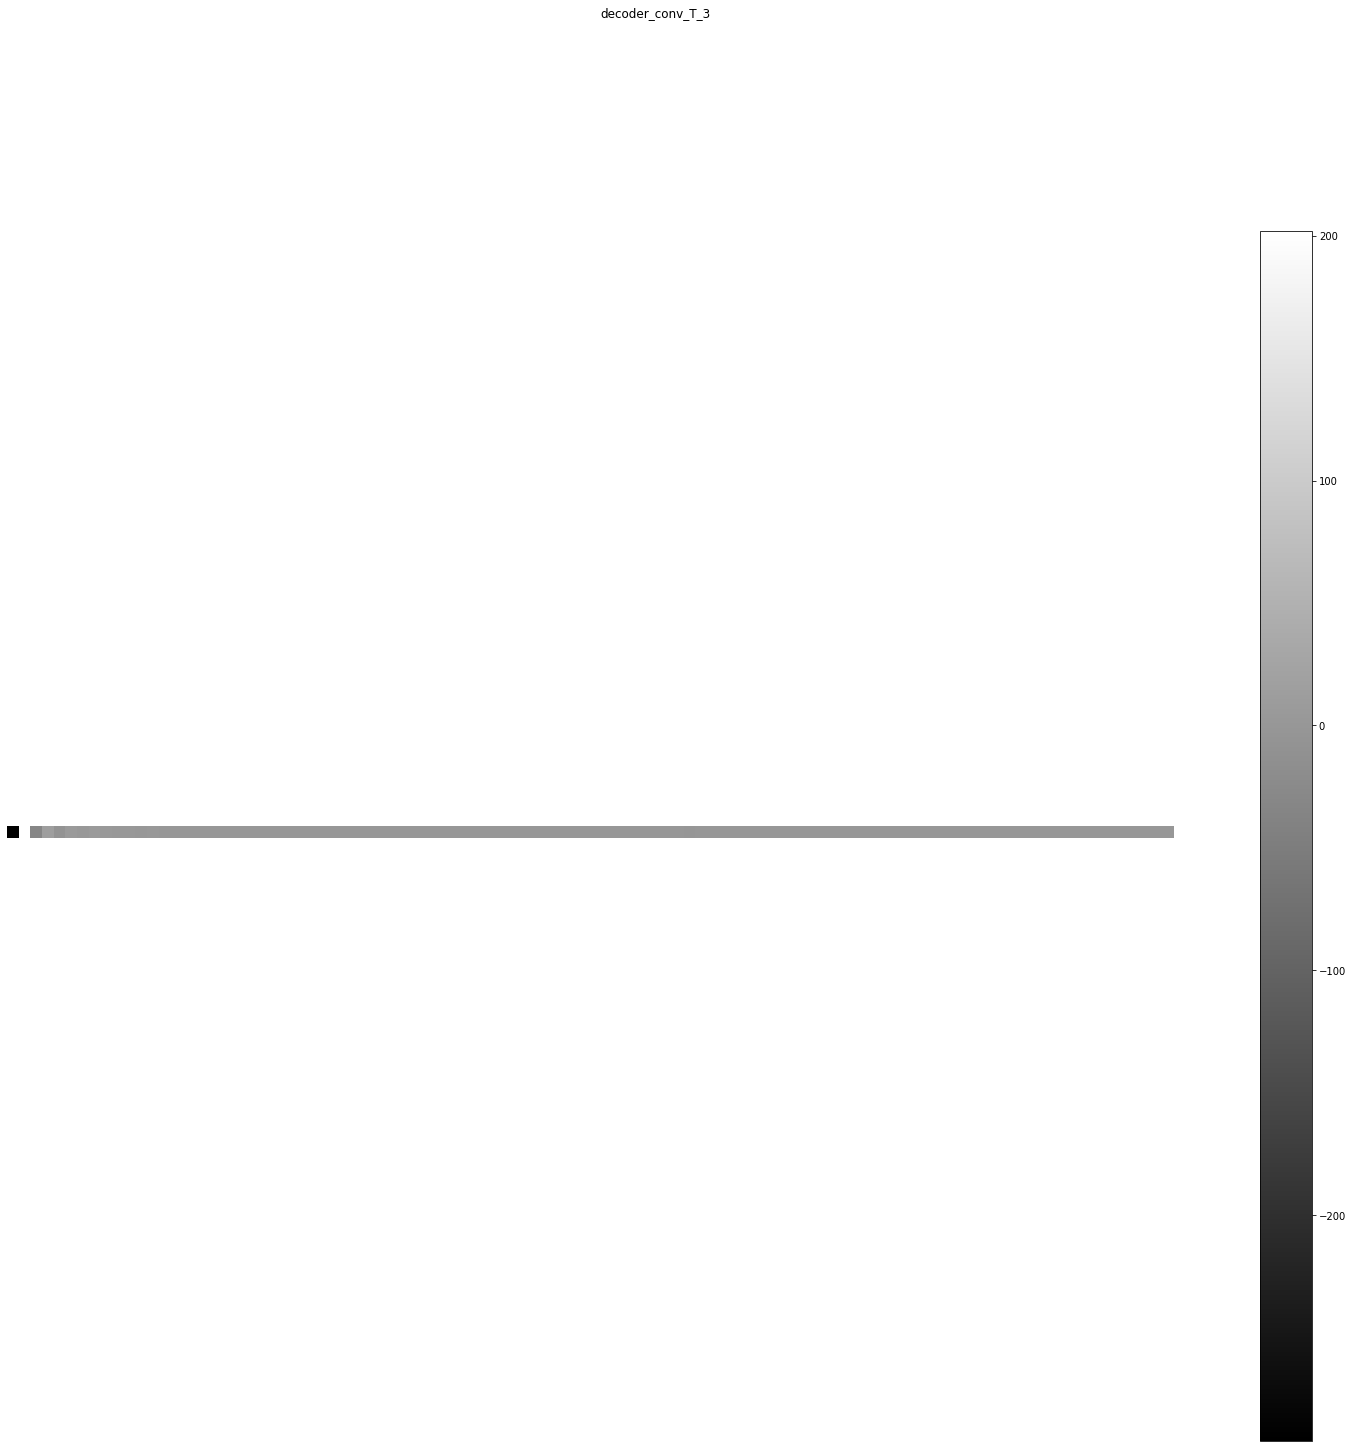

In [ ]:
# Compute the decoder input as the encoder output.
decoder_keract_input = encoder(keract_inputs)[2]

# Get activations of the selected layers in the decoder model.
activations_cvae_decoder = get_activations(decoder, decoder_keract_input, layer_names=layer_names_cvae_decoder)

# Display the activations of the selected layers in the decoder model.
display_activations(activations_cvae_decoder, cmap="gray", save=False)

In the plot above, we observe that the encoder output is transformed back (passing though a series of layers) into a vector like the original input of the CVAE unless reconstruction loss. This is exactly what should happen in the decoder defined.

### 9.7 CVAE: visualizing latent space

Visualizing the latent space of a CVAE (Conditional Variational Autoencoder) model is important for several reasons:

* understanding the structure of the latent space: by visualizing the latent space, it's possible to determine how well the model has captured the underlying structure of the data. A well-structured latent space should allow to separate different classes or data points easily;

* interpreting the model: visualizing the latent space can also help to understand how the model is encoding information from the input data. By observing the positions of the data points in the latent space, it's possible to determine which factors of the input data are most important to the model;

* generating new samples: the latent space is also useful for generating new samples. By sampling values from the latent space and decoding them back into the input space, it's possible to generate new data points that are similar to the ones in the original data.

The following code block uses the encoder model to make predictions on a given test data set. The `encoder.predict()` method is applied to the test data, which returns the predicted means (`latent_mu`), variances (`latent_var`), and latent variables (`latent_z`) of the test data in the CVAE's latent space. These values represent the compact representation of the input data in the latent space, which captures the most important features and relationships in the data.

In [ ]:
# Use the encoder model to predict on the test data.
latents = encoder.predict(test)

# Unpack the results of the encoder prediction into 3 separate variables.
latent_mu, latent_var, latent_z = latents[0], latents[1], latents[2]

# Predicted class labels for the input data in the test set.
test_labels = np.argmax(test_label, axis=1)

28/28 [==============================] - 0s 4ms/step


Then, we take the output of the CVAE encoder, which is stored in the latents variable, and process it for visualization. For each iteration, it checks if the latent dimension is equal to 2. If the latent dimension is already equal to 2, it assigns the `data` to the `latent_tsne` variable. If the latent dimension is not equal to 2, it uses t-SNE to reduce the data to 2 dimensions and assigns the result to `latent_tsne`. After that, we create a dataframe per visualization, as specifed in the following. The purpose of this code block is to prepare the data for visualization in 2 dimensions so that it can be plotted and analyzed.

In [ ]:
latents_tsnes = {}
# Loop through the elements of the latents list and the ['mu', 'var', 'z'] list.
for data, latent_key in zip(latents, ['mu', 'var', 'z']):
    # Check if the latent dimension is equal to 2.
    if latent_dim == 2:
        latent_tsne = data
    else:
        # If the latent dimension is not equal to 2, use t-SNE to reduce the data to 2 dimensions.
        latent_tsne = TSNE(n_components=2, random_state=2082157).fit_transform(data)
    # Create a Pandas DataFrame with columns 'x', 'y', and 'label'.
    latent_df = pd.DataFrame({'x': latent_tsne[:, 0], 'y': latent_tsne[:, 1], 'label': test_labels})
    # Store the t-SNE transformed data in the latents_tsnes dictionary.
    latents_tsnes[latent_key] = latent_df

Then, the silhouette score for each latent variable is calculated using the `silhouette_score` function from the scikit-learn library. This score measures how well-separated the data points are in the feature space defined by the `x` and `y` columns of the `latent_data` dataframe. The `label` column of the dataframe is used as the ground-truth label information. The calculated silhouette score is then printed along with the corresponding key name.

In [ ]:
for latent_key in ['mu', 'var', 'z']:
    # Get the corresponding data from the latents_tsnes dictionary.
    latent_data = latents_tsnes[latent_key]
    # Calculate the silhouette score for the latent data, using the 'x' and 'y' columns as the feature data and the 'label' column as the label data.
    score = silhouette_score(latent_data[['x', 'y']].values, latent_data['label'].values)
    # Print the calculated silhouette score, along with the key name.
    print('Score {}: {}'.format(latent_key, score))

Score mu: -0.15805526077747345
Score var: -0.16908356547355652
Score z: -0.15805529057979584


In this case, the scores for all three latent representations (`mu`, `var`, `z`) are negative, indicating that the samples are not well-matched to their own clusters, and are probably misclassified. This could mean that the clustering of the latent representations is not very clear, or that the latent representation is not well-suited to the task of clustering the input data into different classes.

Let's now consider a scatter plot of the t-SNE transformed latent variables stored in the `latents_tsnes` dictionary. 

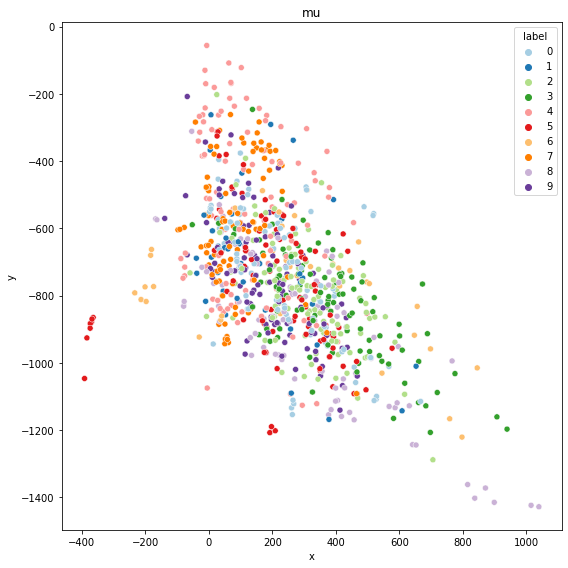

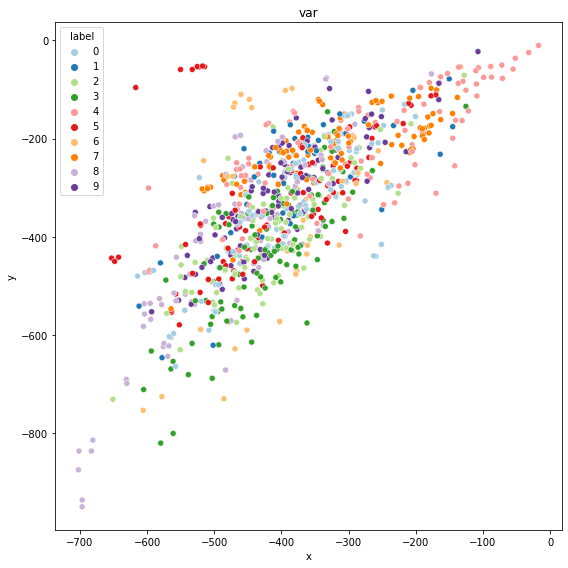

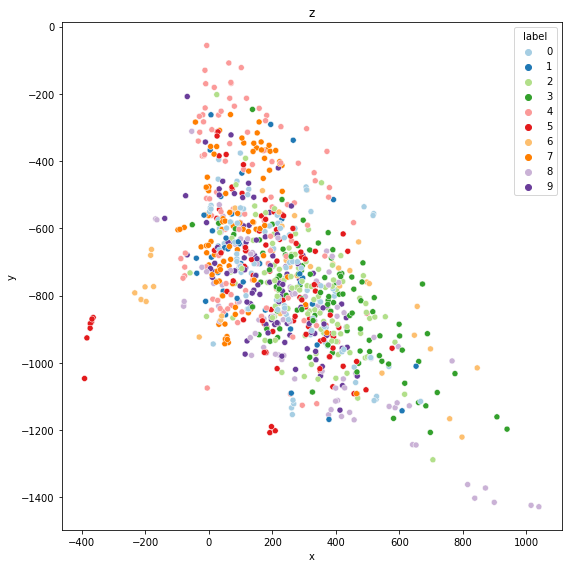

In [ ]:
for latent_key in ['mu', 'var', 'z']:
  # Get the corresponding data from the latents_tsnes dictionary.
  latent_data = latents_tsnes[latent_key]
  # Plot a figure based on the current latent key.
  fig = plt.figure(figsize=(8, 8))
  # Scatter plot using the seaborn library's scatterplot function
  ax = sn.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')
  # Set the title of the plot to the current latent key.
  ax.set_title(latent_key)
  plt.tight_layout()

These results could be interpreted as a confirmation that the model probably does not work very well even on the tasks we will do later. In fact, as mentioned after the training process, the loss in absolute value is fairly high.

Unfortunately, as mentioned, several possible configurations associated with encoder and decoder models have been tried without obtaining better results than this one.

### 9.8 CVAE: denoising test data

Now, we are going to denoise test samples using our CVAE model. The reconstruction loss was considered as a custom loss for the CVAE for this specific purpose.

Let's add Gaussian noise to the test data considering a high noise factor.

In [ ]:
# Add Gaussian noise to the test data.
noise_factor = 10
noisy_test = test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test.shape)

We are now considering the fist sample of the test set: the original sample is kept unchanged, the noisy sample is the one characterized by the noise injection and the denoised sample represents the output of the CVAE which should be similar to the original sample.

In [ ]:
# Original sample: test sample without noise injection.
original_test_sample = test[:1]

# Noisy sample: test sample considering noise injection.
noisy_test_sample = noisy_test[:1]

# CVAE: denoising test sample.
denoised_test_sample = conv_variational_autoencoder.predict(noisy_test_sample)

# Reshape the sample in order to plot them.
original_test_sample = original_test_sample.reshape(-1, 1)
noisy_test_sample = noisy_test_sample.reshape(-1, 1)
denoised_test_sample = denoised_test_sample.reshape(-1, 1)

1/1 [==============================] - 0s 397ms/step


Let's plot the samples to see if there are visible differences between them.

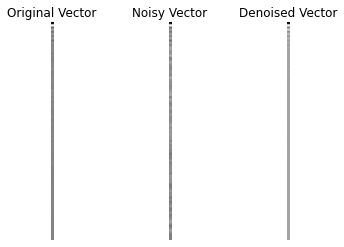

In [ ]:
# Plot the original, noisy and denoised test sample.
plt.subplot(1, 3, 1)
plt.imshow(original_test_sample, cmap='gray')
plt.title('Original Vector')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(noisy_test_sample, cmap='gray')
plt.title('Noisy Vector')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(denoised_test_sample, cmap='gray')
plt.title('Denoised Vector')
plt.axis('off')
plt.show()

From the figure above, we could see some differences between the vectors. In fact, the original is different from the noisy and the denoised vector seems to be not too similar to the original one.

In order to better understand the performances of the CVAE on the reconstruction, we could compute the MSE between the noisy and the denoised vector. As a comparison, we compute also the MSE between the original and the noisy sample.

In [ ]:
print('MSE between denoised test sample and noisy test sample: '+str(np.mean((denoised_test_sample - noisy_test_sample)**2)))

MSE between denoised test sample and noisy test sample: 122.91190624740302


In [ ]:
print('MSE between original test sample and noisy test sample: '+str(np.mean((original_test_sample - noisy_test_sample)**2)))

MSE between original test sample and noisy test sample: 94.8554819293322


From the results above, we could note that the CVAE is not learning anything basically. In fact, the first MSE is higher than the second one, while it should be close to 0 if it worked properly.

### 9.7 CVAE: generate new samples

Let's use our unsupervised model to generate new samples.

Differently from a traditional autoencoder, where some points of the latent do not generate meaningful results, all the latent space of the variational autoencoder should generate meaningful results.

Additionally we force the latent space to be a $\mathcal{N}(0,1$), so if we draw samples from this distribution and we use them to as the input of the decoder, the decoder should generate meaningful outputs.

In [ ]:
# Set the number of samples to be generated.
n_examples = 100

# Generate random values from a normal distribution.
examples = tf.random.normal(shape=[n_examples, latent_dim])

# Generate samples using the decoder model.
generated_samples = decoder.predict(examples)

4/4 [==============================] - 0s 5ms/step


Let's plot the generated samples.

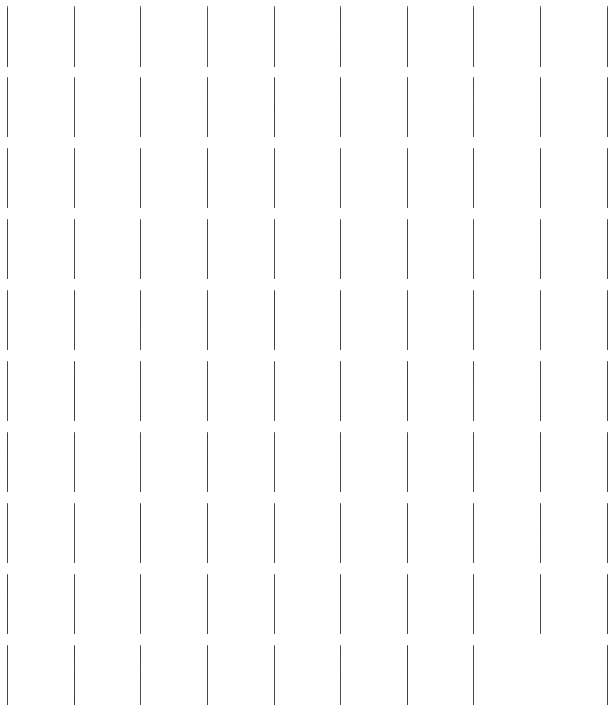

In [ ]:
# Plot the generated samples.
plt.figure(figsize=(10, 10))
for i, generated in enumerate(generated_samples):
    ax = plt.subplot(10, 10, i+1)
    plt.imshow(generated[:, :], cmap='gray')
    ax.axis('off')
    plt.tight_layout()

Now, we will consider their shape to understand if the output produced is meaningful.

In [ ]:
# Print the shape of the generated samples.
print(generated_samples.shape)

(100, 100, 1)


As can be seen, the generated samples have the correct shape representing vectors of MFCCs features. As these samples have no associated labels, there is no way to generate predictions on this "new" dataset.

We could also try to reconstruct and display one of the generated audio using the function defined in the previous sections. 

In [ ]:
# Reconstructing the generated audio from the MFCCs.
reconstructed_generated_audio = mfccs_to_audio(generated_samples[98])

# Use the IPython display function to display the audio.
# The audio will be played using the rate 22050.
ipd.display(ipd.Audio(reconstructed_generated_audio, rate=22050))

Unfortunately, as before, this audio sample is not meaningful in terms of its reconstruction.

Overall, we could state that the unsupervised model does not perform well in noise cleaning the audio features, while it generates meaningful new samples probably with some errors associated with.

## 10. Conclusions

This concludes this project. We could say that, when the audio sounds are sufficiently clean, in terms of supervised learning, the baseline CNN can accurately classify them. Also the feed-forward neural network is capable to classify the audio sounds in a satisfactory way. When we consider a situation of noise injection or generation of adverarial attacks, both the models' performances decrease drastically (even if the feed-forward model seems to be less sensible to these types of attacks). Considering the unsupervised learning model (CVAE), it is not capable to accurately denoise test data but, probably, it can be used for generating new meaningful samples.

With more time and hardware resources, it would be possible to experiment more on how batch size, batch normalization, and different optimizers affect model performance on the validation and testing set. It would also be insightful to experiment more with model architecture and different types of models for time, such as LSTMs. Also, it would be interesting to train the models for more epochs to see how it behaves the more it trains. Another interesting aspect that could be explored is to experiment other unsupervised models, such as DBN, to understand if it's possible to use them to obtain better performances on these tasks than the CVAE.

## 11. References

* UrbanSound8K dataset: https://urbansounddataset.weebly.com/urbansound8k.html;
* UrbanSound8K taxonomy: https://urbansounddataset.weebly.com/taxonomy.html;
* Keract: https://pypi.org/project/keract/;
* Librosa library: https://librosa.org/doc/latest/index.html;
* MFCCs: https://www.analyticsvidhya.com/blog/2021/06/mfcc-technique-for-speech-recognition/;
* Tensorflow MFCCs: https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html;
* Fast Gradient Sign Method (FGSM): https://jaketae.github.io/study/fgsm/.